In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
NUM_IMAGES_TRAIN = 13000*21
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
from torchvision.io import read_image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import os


# These numbers are mean and std values for channels of natural images. 
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Inverse transformation: needed for plotting.
unnormalize = transforms.Normalize(
   mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
   std=[1/0.229, 1/0.224, 1/0.225]
)

motion_transform_train = transforms.Compose([
                                    # transforms.Resize((256, 256)),
                                    # transforms.RandomHorizontalFlip(),
                                    # transforms.ColorJitter(hue=.2, saturation=.2, contrast=.2),
                                    # transforms.RandomRotation(20, interpolation=Image.BILINEAR),
                                    # transforms.GaussianBlur(7, sigma=(0.1, 1.0)),
                                    normalize,
                                ])

content_transform_train = transforms.Compose([
                                    transforms.RandomResizedCrop(size=(160,240)),
                                    # transforms.Resize((256, 256)),
                                    transforms.RandomHorizontalFlip(),
                                    # transforms.ColorJitter(hue=.2, saturation=.2, contrast=.2),
                                    transforms.RandomRotation(20, interpolation=Image.BILINEAR),
                                    transforms.GaussianBlur(7, sigma=(0.1, 1.0)),
                                    normalize,
                                ])

class CompDataset(Dataset):
    def __init__(self, data_dir, size=NUM_IMAGES_TRAIN, motion_transform=motion_transform_train, content_transform=content_transform_train):
        self.data_dir = data_dir
        self.motion_transform = motion_transform
        self.content_transform = content_transform
        self.size = size
        self.frame_list = []

        self.count = 0
        for vid_dir in os.listdir(self.data_dir):
            for i in range(21):
                self.frame_list.append(self.data_dir+"/"+vid_dir+"/image_"+str(i)+".png")
                self.count +=1

    def __len__(self):
        return self.count

    def __getitem__(self, idx):
        image1 = read_image(self.frame_list[idx])
        image2 = read_image(self.frame_list[idx+1])
        label = -1
        
        
        par_dir = os.path.dirname(self.frame_list[idx])
        if os.path.isfile(par_dir+"/mask.npy"):
            try:
                label = read_image(par_dir+"/mask.npy")
            except:
                return None, None, None, None
        
        image1= image1/255.0
        image2 = image2/255.0

        if self.motion_transform:
            image1 = self.motion_transform(image1)
            image2 = self.motion_transform(image2)
        
        if self.content_transform:
          image3 = self.content_transform(image1)

        return image1, image2, image3, label

def collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))
    return torch.utils.data.dataloader.default_collate(batch)



unlabeled_data = CompDataset("/dataset/dataset/unlabeled")
train_dataloader = DataLoader(unlabeled_data, batch_size=2, shuffle=True, collate_fn = collate_fn)

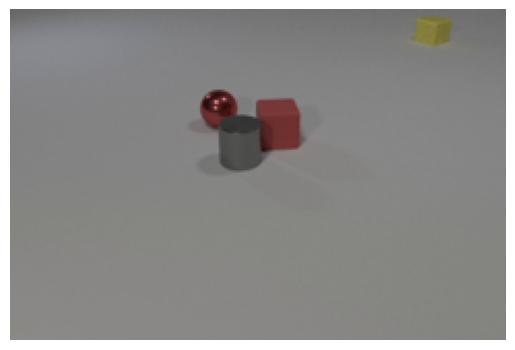

In [ ]:
from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 100 # change dpi to make plots bigger

def show_normalized_image(img, title=None):
    plt.imshow(unnormalize(img).detach().cpu().permute(1, 2, 0).numpy())
    plt.title(title)
    plt.axis('off')

show_normalized_image(unlabeled_data[10][0])

In [ ]:
def warp(x, flo):
    """
    warp an image/tensor (im2) back to im1, according to the optical flow
    x: [B, C, H, W] (im2)
    flo: [B, 2, H, W] flow
    """

    B, C, H, W = x.size()
    # mesh grid 
    xx = torch.arange(0, W).view(1,-1).repeat(H,1)
    yy = torch.arange(0, H).view(-1,1).repeat(1,W)
    xx = xx.view(1,1,H,W).repeat(B,1,1,1)
    yy = yy.view(1,1,H,W).repeat(B,1,1,1)
    grid = torch.cat((xx,yy),1).float().to(device)
    
    if torch.is_tensor(flo): 
        vgrid = torch.autograd.Variable(grid) + flo
    else:
        vgrid = torch.autograd.Variable(grid)

    # scale grid to [-1,1] 
    vgrid[:,0,:,:] = 2.0*vgrid[:,0,:,:].clone() / max(W-1,1)-1.0
    vgrid[:,1,:,:] = 2.0*vgrid[:,1,:,:].clone() / max(H-1,1)-1.0

    vgrid = vgrid.permute(0,2,3,1)        
    output = nn.functional.grid_sample(x, vgrid)
    mask = torch.autograd.Variable(torch.ones(x.size())).to(device)
    mask = nn.functional.grid_sample(mask, vgrid)

    # if W==128:
      # np.save('mask.npy', mask.cpu().data.numpy())
      # np.save('warp.npy', output.cpu().data.numpy())

    mask[mask<0.9999] = 0
    mask[mask>0] = 1
    return output*mask

In [ ]:
class FEA(nn.Module):
    def __init__ (self, in_features, out_features):
        super().__init__()
        self.cnn = nn.Conv2d(in_features, out_features, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.bn = nn.BatchNorm2d(out_features)
        self.relu = nn.ReLU()
        self.maxPool = nn.MaxPool2d(2)

    def forward(self, X_tnext, X_hat_tnext, f_tprev_t):
        correlation = self.corr4D(X_tnext, X_hat_tnext)
        batch_size, out_channels, ht, wd = X_tnext.shape
#         mat_mul = torch.matmul(correlation.view(batch_size, 1, ht*wd, ht*wd), X_tnext.view(batch_size, ht*wd, out_channels, 1))
#         print(correlation.shape)
        mat_mul = torch.matmul(correlation, X_tnext.view(batch_size, out_channels, ht*wd, 1))
        mat_mul = mat_mul.view(batch_size, out_channels, ht, wd)
        x = self.maxPool(self.relu(self.bn(self.cnn(mat_mul))))
        x = self.upsample(x)
        x += f_tprev_t
        x.requires_grad
        return x
    
    @staticmethod
    def corr4D(X_tnext, X_hat_tnext):
        batch, dim, ht, wd = X_tnext.shape
        X_tnext = X_tnext.view(batch, dim, ht*wd)
        X_hat_tnext = X_hat_tnext.view(batch, dim, ht*wd) 

        corr = torch.matmul(X_tnext.transpose(1,2), X_hat_tnext)
#         corr = corr.view(batch, ht, wd, 1, ht, wd)
        corr = corr.view(batch, 1, ht*wd, ht*wd)
        corr = corr/torch.sqrt(torch.tensor(dim).float())
        return corr
    
    @staticmethod
    def upsample(flow, scale = 2, mode='bilinear'):
        new_size = (scale * flow.shape[2], scale * flow.shape[3])
        return  scale * F.interpolate(flow, size=new_size, mode=mode, align_corners=True)

In [ ]:
class Encoder(nn.Module):
    def __init__ (self, in_features, out_features):
        super().__init__()
        self.cnn = nn.Conv2d(in_features, out_features, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.bn = nn.BatchNorm2d(out_features)
        self.maxPool = nn.MaxPool2d(2)
        self.relu = nn.ReLU()
        
        self.cnn2 = nn.Conv2d(out_features, out_features, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.bn2 = nn.BatchNorm2d(out_features)
        self.maxPool2 = nn.MaxPool2d(2)

    def forward(self, I):
        x = self.maxPool(self.relu(self.bn(self.cnn(I))))
        x = self.maxPool2(self.relu(self.bn2(self.cnn2(x))))
        return x

In [ ]:
class MCJepa(nn.Module):
    def __init__(self, numLayers, in_features, out_features, out_features_fea):
        super().__init__()
        self.numLayers = numLayers;
        self.enc1 = nn.ModuleList([Encoder(in_features, out_features) for i in range(numLayers)])
        # self.enc2 = [Encoder(in_features, out_features) for i in range(numLayers)]
        self.fea = nn.ModuleList([FEA(out_features, out_features_fea) for i in range(numLayers)])
        self.f_tprev_t = 0.0 # TODO: this has to be a tensor
        self.f_tnext_t = 0.0 # TODO: this has to be a tensor

        # content

        self.expander_in_features = self.numLayers*out_features*80*120
        
        self.expander = nn.Sequential(
            nn.Linear(self.expander_in_features,self.expander_in_features*2)
        )

    def forward(self, I_t, I_tnext, I_tcrop):
        X_hat_tnext = []
        X_hat_t = []
        X_t = []
        X_tnext = []
        f_t_tnext = []
        f_tnext_t = []
        X_tcrop = torch.tensor()
        X_tconcat = torch.tensor()

        
        # motion component

        for i in range(self.numLayers): # Feature extracting layer
            X_t.append(self.enc1[i](I_t))
            X_tnext.append(self.enc1[i](I_tnext))

        for i in range(self.numLayers): # Finding the flow t -> t + 1
            if i == 0:
                f_t_tnext.append(self.fea[i](X_tnext[i], X_t[0], self.f_tprev_t))
            else:
                X_hat_tnext.append(warp(X_t[i], f_t_tnext[i-1]))
                f_t_tnext.append(self.fea[i](X_tnext[i], X_hat_tnext[i-1], f_t_tnext[i-1]))

        self.f_tprev_t = torch.detach(f_t_tnext[-1]) # Remembering the flow info across frames
        
        I_hat_tnext = warp(I_t, FEA.upsample(f_t_tnext[-1], 4)) # Predicting future frame

        for i in range(self.numLayers): # Finding the flow t + 1 -> t
            if i == 0:
                f_tnext_t.append(self.fea[i](X_t[i], X_tnext[0], self.f_tnext_t))
            else:
                X_hat_t.append(warp(X_tnext[i], f_tnext_t[i-1]))
                f_tnext_t.append(self.fea[i](X_t[i], X_hat_t[i-1], f_tnext_t[i-1]))

        self.f_tnext_t = torch.detach(f_tnext_t[-1]) # Remembering the flow info across backward frames

        I_hat_t = warp(I_tnext, FEA.upsample(f_tnext_t[-1], 4)) # Predicting past frame
        
        # content component

        for i in range(self.numLayers): # Feature extracting layer
            X_tcrop = torch.concat(X_tcrop,self.enc1[i](I_tcrop),dim=1)
            X_tconcat = torch.concat(X_tconcat,X_t[i],dim=1)
        
        X_tcrop_flattened = X_tcrop.view(X_tcrop.shape[0],-1)
        X_tconcat = X_tconcat.view(X_tconcat.shape[0],-1)

        Y1 = self.expander(X_tcrop_flattened)
        Y2 = self.expander(X_tconcat)
        
        return X_t, X_tnext, X_hat_t, X_hat_tnext, f_t_tnext, f_tnext_t, I_hat_t, I_hat_tnext, Y1, Y2, X_tcrop, X_tconcat


In [ ]:
# Constants to figure out later
numLayers = 10
in_features = 3 
out_features = 8
out_features_fea = 2
lm, mu, nu, lambda_a, lambda_b = 0.002, 0.002, 0.001, 5, 5

model = MCJepa(numLayers, in_features, out_features, out_features_fea).to(device)
optimizer = optim.SGD(model.parameters(), lr = 0.0001)


In [ ]:
def off_diagonal(M):
    res = M.clone()
    res.diagonal(dim1=-1, dim2=-2).zero_()
    return res

def vc_reg(X_t, X_tnext, lm, mu, nu):
    N = X_t.shape[0]
    C = X_t.shape[1]
    H = X_t.shape[2]
    W = X_t.shape[3] 
    D = C + H + W 
    mse_loss = nn.MSELoss()
    sim_loss = mse_loss(X_t, X_tnext)
    
    std_z_a = torch.sqrt(X_t.var(dim=0) + 1e-04)
    std_z_b = torch.sqrt(X_tnext.var(dim=0) + 1e-04)
    std_loss = torch.mean(F.relu(1-std_z_a)) + torch.mean(F.relu(1-std_z_b))

    X_t = X_t - X_t.mean(dim=0)
    X_tnext = X_tnext - X_tnext.mean(dim=0)
    cov_z_a = torch.matmul(X_t.view(N, C, W, H), X_t)/ (N-1)
    cov_z_b = torch.matmul(X_tnext.view(N, C, W, H), X_tnext)/ (N-1)
    conv_loss = (off_diagonal(cov_z_a).pow_(2).sum()/D) + (off_diagonal(cov_z_b).pow_(2).sum()/D) 
        
    loss = lm*sim_loss + mu*std_loss + nu*conv_loss
    return loss

def cycle_loss_fn(f_t_tnext, f_tnext_t, X_t, X_tnext, lambda_a, lambda_b):
    loss_cycle_A = torch.tensor(0.0).to(device)
    loss_cycle_B = torch.tensor(0.0).to(device)
    for i in range(1, len(X_t)):
        loss_cycle_A += F.l1_loss(warp(X_t[i], f_t_tnext[i]), X_tnext[i]) * lambda_a
        loss_cycle_B += F.l1_loss(warp(X_tnext[i], f_tnext_t[i]), X_t[i]) * lambda_b

    return loss_cycle_A + loss_cycle_B

In [ ]:
def criterion(X_t, X_tnext, X_hat_t, X_hat_tnext, f_t_tnext, f_tnext_t, I_hat_t, I_hat_tnext, img1, img2, Y1, Y2, X_tcrop, X_tconcat, lm, mu, nu, lambda_a, lambda_b, label):
  
    mse_loss = nn.MSELoss()
    regress_loss_forward = torch.tensor(0.0).to(device)
    regress_loss_backward = torch.tensor(0.0).to(device)
    for i in range(len(X_hat_tnext)):
        regress_loss_forward += mse_loss(X_hat_tnext[i], X_tnext[i+1])
        regress_loss_backward += mse_loss(X_hat_t[i], X_t[i+1])
        
    reconst_loss_forward = mse_loss(I_hat_tnext, img2) 
    reconst_loss_backward = mse_loss(I_hat_t, img1) 
    vc_reg_loss = torch.tensor(0.0).to(device)
    
    for i in range(len(X_t)):
        vc_reg_loss += vc_reg(X_t[i], X_tnext[i], lm, mu, nu)

    cycle_loss = cycle_loss_fn(f_t_tnext, f_tnext_t, X_t, X_tnext, lambda_a, lambda_b)
#     print(regress_loss_forward)
#     print(regress_loss_backward)
#     print(reconst_loss_forward)
#     print(reconst_loss_backward)
#     print(vc_reg_loss)
#     print(cycle_loss)


    # content 

    vc_content_loss = vc_reg(X_tcrop, X_tconcat, lm, mu, nu)
    vc_content_expander_loss = vc_reg(Y1, Y2, lm, mu, nu)

    content_regress_loss = mse_loss(Y1,Y2)

    

    return regress_loss_forward + regress_loss_backward + reconst_loss_forward + reconst_loss_backward + vc_reg_loss + cycle_loss + vc_content_loss + vc_content_expander_loss + content_regress_loss



In [ ]:
from tqdm import tqdm

def train_model(model, epochs, dataloader, criterion, optimizer):
    model.train()

    pbar = tqdm(range(epochs))

    train_losses = []

    best_loss = float("inf")
    best_model = model.state_dict()

    for i in pbar:
        total_train_loss = 0.0
        total_train_correct = 0.0

        model.train()

        for i,batch in enumerate(tqdm(dataloader, leave=False)):
            img1 = batch[0].to(device)
            img2 = batch[1].to(device)
            img3 = batch[2].to(device)
            label = batch[3].to(device)

            X_t, X_tnext, X_hat_t, X_hat_tnext, f_t_tnext, f_tnext_t, I_hat_t, I_hat_tnext, Y1, Y2, X_tcrop, X_tconcat = model(img1, img2, img3)

            loss = criterion(X_t, X_tnext, X_hat_t, X_hat_tnext, f_t_tnext, f_tnext_t, I_hat_t, I_hat_tnext, img1, img2, Y1, Y2, X_tcrop, X_tconcat, lm, mu, nu, lambda_a, lambda_b, label)
            
            total_train_loss += loss.item()/len(label)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            print("Loss :", loss.item())

            if loss < best_loss:
              best_loss = loss
              best_model = model.state_dict()
            
            if i%1000 == 0 and i > 0:
              torch.save(best_model,"best_model.pth")

      train_losses.append(total_train_loss/len(dataloader))

      pbar.set_postfix({'train_loss': train_losses[-1]})
    
    torch.save(best_model,"best_model.pth")

In [ ]:
train_model(model, 1, train_dataloader, criterion, optimizer)

  0%|          | 0/136500 [00:00<?, ?it/s]/home/sd5313/.local/lib/python3.10/site-packages/torch/nn/functional.py:4236: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(

  0%|          | 1/136500 [00:01<65:32:31,  1.73s/it]

Loss : 661.6904296875



  0%|          | 2/136500 [00:01<31:51:48,  1.19it/s]

Loss : 323.0740661621094



  0%|          | 4/136500 [00:02<15:36:15,  2.43it/s]

Loss : 315.6795349121094
Loss : 156.00816345214844



  0%|          | 6/136500 [00:02<10:56:21,  3.47it/s]

Loss : 131.97161865234375
Loss : 223.88006591796875



  0%|          | 8/136500 [00:03<8:48:30,  4.30it/s]

Loss : 189.8662109375
Loss : 167.68768310546875



  0%|          | 9/136500 [00:03<8:16:37,  4.58it/s]


Loss : 196.47891235351562
Loss : 166.23910522460938


  0%|          | 12/136500 [00:03<7:41:30,  4.93it/s]

Loss : 149.6726837158203
Loss : 123.00396728515625



  0%|          | 13/136500 [00:04<7:31:00,  5.04it/s]

Loss : 210.8074951171875
Loss : 152.7751007080078



  0%|          | 16/136500 [00:04<7:29:23,  5.06it/s]

Loss : 166.41944885253906
Loss : 131.1250457763672



  0%|          | 18/136500 [00:05<7:17:17,  5.20it/s]

Loss : 61.596336364746094
Loss : 129.58578491210938



  0%|          | 20/136500 [00:05<7:21:53,  5.15it/s]

Loss : 108.2657241821289
Loss : 129.40750122070312



  0%|          | 22/136500 [00:05<7:14:21,  5.24it/s]

Loss : 118.438720703125
Loss : 74.9449691772461



  0%|          | 24/136500 [00:06<7:20:22,  5.17it/s]

Loss : 118.18933868408203
Loss : 137.3016815185547



  0%|          | 26/136500 [00:06<7:15:09,  5.23it/s]

Loss : 80.59616088867188
Loss : 129.27418518066406



  0%|          | 28/136500 [00:07<7:29:33,  5.06it/s]

Loss : 117.83269500732422
Loss : 156.43365478515625



  0%|          | 29/136500 [00:07<7:41:55,  4.92it/s]

Loss : 86.47802734375
Loss : 122.65621948242188



  0%|          | 32/136500 [00:07<7:50:27,  4.83it/s]

Loss : 121.50577545166016
Loss : 133.81382751464844



  0%|          | 33/136500 [00:08<7:53:52,  4.80it/s]

Loss : 65.16230010986328
Loss : 109.34170532226562



  0%|          | 35/136500 [00:08<7:38:29,  4.96it/s]

Loss : 81.57550048828125



  0%|          | 37/136500 [00:08<7:32:35,  5.03it/s]

Loss : 85.65737915039062
Loss : 104.05685424804688



  0%|          | 39/136500 [00:09<7:28:55,  5.07it/s]

Loss : 95.88936614990234
Loss : 98.87521362304688



  0%|          | 41/136500 [00:09<7:27:19,  5.08it/s]

Loss : 67.24288940429688
Loss : 118.25189208984375



  0%|          | 42/136500 [00:09<7:21:46,  5.15it/s]

Loss : 71.95542907714844
Loss : 75.96383666992188



  0%|          | 45/136500 [00:10<7:21:04,  5.16it/s]

Loss : 72.96083068847656
Loss : 98.3948974609375



  0%|          | 47/136500 [00:10<7:15:08,  5.23it/s]

Loss : 101.06007385253906
Loss : 82.88555908203125



  0%|          | 49/136500 [00:11<7:15:22,  5.22it/s]

Loss : 93.77640533447266
Loss : 68.94068908691406



  0%|          | 51/136500 [00:11<7:10:28,  5.28it/s]

Loss : 52.897117614746094
Loss : 80.7786865234375



  0%|          | 53/136500 [00:11<7:12:03,  5.26it/s]

Loss : 81.10997009277344
Loss : 83.40916442871094



  0%|          | 55/136500 [00:12<7:16:04,  5.21it/s]

Loss : 69.52311706542969
Loss : 74.02019500732422



  0%|          | 57/136500 [00:12<7:16:41,  5.21it/s]

Loss : 82.0055923461914
Loss : 90.92341613769531



  0%|          | 59/136500 [00:13<7:14:29,  5.23it/s]

Loss : 99.30801391601562
Loss : 71.53848266601562



  0%|          | 61/136500 [00:13<7:12:50,  5.25it/s]

Loss : 61.9514045715332
Loss : 52.35551071166992



  0%|          | 63/136500 [00:13<7:07:49,  5.32it/s]

Loss : 54.09813690185547
Loss : 58.48435974121094



  0%|          | 65/136500 [00:14<7:10:42,  5.28it/s]

Loss : 97.33910369873047
Loss : 66.73928833007812



  0%|          | 67/136500 [00:14<7:09:18,  5.30it/s]

Loss : 83.63296508789062
Loss : 65.76716613769531



  0%|          | 69/136500 [00:14<7:08:30,  5.31it/s]

Loss : 61.33036804199219
Loss : 79.55027770996094



  0%|          | 71/136500 [00:15<7:09:05,  5.30it/s]

Loss : 54.803504943847656
Loss : 53.742942810058594



  0%|          | 73/136500 [00:15<7:17:27,  5.20it/s]

Loss : 85.2857666015625
Loss : 78.84190368652344



  0%|          | 75/136500 [00:16<7:18:26,  5.19it/s]

Loss : 64.94463348388672
Loss : 61.25470733642578



  0%|          | 77/136500 [00:16<7:16:50,  5.20it/s]

Loss : 84.29354858398438
Loss : 65.54761505126953



  0%|          | 79/136500 [00:16<7:39:48,  4.94it/s]

Loss : 80.55409240722656
Loss : 61.25156784057617



  0%|          | 81/136500 [00:17<7:32:18,  5.03it/s]

Loss : 77.23861694335938
Loss : 60.457786560058594



  0%|          | 83/136500 [00:17<7:26:32,  5.09it/s]

Loss : 56.443870544433594
Loss : 65.88653564453125



  0%|          | 85/136500 [00:18<7:19:42,  5.17it/s]

Loss : 54.414283752441406
Loss : 75.654296875



  0%|          | 87/136500 [00:18<7:22:32,  5.14it/s]

Loss : 77.41407775878906
Loss : 51.28753662109375



  0%|          | 89/136500 [00:18<7:24:15,  5.12it/s]

Loss : 62.77661895751953
Loss : 66.7296142578125



  0%|          | 91/136500 [00:19<7:19:46,  5.17it/s]

Loss : 74.15643310546875
Loss : 44.504024505615234



  0%|          | 93/136500 [00:19<7:32:22,  5.03it/s]

Loss : 68.96560668945312
Loss : 75.27432250976562



  0%|          | 95/136500 [00:20<7:25:59,  5.10it/s]

Loss : 80.9544677734375
Loss : 52.41563415527344



  0%|          | 97/136500 [00:20<7:23:23,  5.13it/s]

Loss : 59.883392333984375
Loss : 58.55038070678711



  0%|          | 99/136500 [00:20<7:10:57,  5.28it/s]

Loss : 59.914939880371094
Loss : 46.74433517456055



  0%|          | 100/136500 [00:21<7:19:08,  5.18it/s]

Loss : 96.05220794677734
Loss : 57.62089920043945



  0%|          | 103/136500 [00:21<7:19:42,  5.17it/s]

Loss : 61.43476104736328
Loss : 92.9038314819336



  0%|          | 105/136500 [00:21<7:15:33,  5.22it/s]

Loss : 57.07465362548828
Loss : 64.63971710205078



  0%|          | 107/136500 [00:22<7:17:33,  5.20it/s]

Loss : 44.426048278808594
Loss : 64.89781188964844



  0%|          | 109/136500 [00:22<7:21:02,  5.15it/s]

Loss : 81.14045715332031
Loss : 51.111358642578125



  0%|          | 111/136500 [00:23<7:24:48,  5.11it/s]

Loss : 36.61522674560547
Loss : 56.801509857177734



  0%|          | 113/136500 [00:23<7:27:23,  5.08it/s]

Loss : 59.562644958496094
Loss : 47.14539337158203



  0%|          | 115/136500 [00:23<7:27:58,  5.07it/s]

Loss : 68.87580871582031
Loss : 47.79899215698242



  0%|          | 117/136500 [00:24<7:14:53,  5.23it/s]

Loss : 46.616600036621094
Loss : 51.24388122558594



  0%|          | 119/136500 [00:24<7:20:19,  5.16it/s]

Loss : 49.17296600341797
Loss : 36.62030029296875



  0%|          | 121/136500 [00:25<7:15:02,  5.22it/s]

Loss : 44.489356994628906
Loss : 50.34568786621094



  0%|          | 123/136500 [00:25<7:25:04,  5.11it/s]

Loss : 53.267486572265625
Loss : 63.508506774902344



  0%|          | 125/136500 [00:25<7:20:33,  5.16it/s]

Loss : 36.62204360961914
Loss : 69.11734008789062



  0%|          | 127/136500 [00:26<7:21:24,  5.15it/s]

Loss : 55.2901611328125
Loss : 50.104637145996094



  0%|          | 128/136500 [00:26<7:25:21,  5.10it/s]

Loss : 48.232154846191406
Loss : 60.874542236328125



  0%|          | 131/136500 [00:27<7:26:05,  5.09it/s]

Loss : 52.25352478027344
Loss : 45.51362228393555



  0%|          | 133/136500 [00:27<7:24:46,  5.11it/s]

Loss : 42.276512145996094
Loss : 58.97040557861328



  0%|          | 135/136500 [00:27<7:21:13,  5.15it/s]

Loss : 45.084869384765625
Loss : 47.44943618774414



  0%|          | 136/136500 [00:28<7:12:37,  5.25it/s]

Loss : 60.88402557373047
Loss : 54.829246520996094



  0%|          | 139/136500 [00:28<7:13:08,  5.25it/s]

Loss : 55.206138610839844
Loss : 46.12989807128906



  0%|          | 141/136500 [00:28<7:16:23,  5.21it/s]

Loss : 59.15385055541992
Loss : 46.310997009277344



  0%|          | 143/136500 [00:29<7:20:33,  5.16it/s]

Loss : 50.89549255371094
Loss : 39.537994384765625



  0%|          | 145/136500 [00:29<7:17:36,  5.19it/s]

Loss : 63.354705810546875
Loss : 46.63222885131836



  0%|          | 147/136500 [00:30<7:11:47,  5.26it/s]

Loss : 49.274620056152344
Loss : 41.81351852416992



  0%|          | 149/136500 [00:30<7:18:34,  5.18it/s]

Loss : 56.53434753417969
Loss : 58.3527946472168



  0%|          | 150/136500 [00:30<7:14:13,  5.23it/s]

Loss : 43.03208923339844
Loss : 50.95537567138672



  0%|          | 153/136500 [00:31<7:18:35,  5.18it/s]

Loss : 47.710716247558594
Loss : 75.73922729492188



  0%|          | 154/136500 [00:31<7:22:06,  5.14it/s]

Loss : 47.720237731933594
Loss : 42.850425720214844



  0%|          | 157/136500 [00:32<7:21:08,  5.15it/s]

Loss : 41.443199157714844
Loss : 42.13457489013672



  0%|          | 158/136500 [00:32<7:13:39,  5.24it/s]

Loss : 51.33277893066406
Loss : 54.638511657714844



  0%|          | 161/136500 [00:32<7:19:59,  5.16it/s]

Loss : 42.14204406738281
Loss : 42.934505462646484



  0%|          | 163/136500 [00:33<7:18:12,  5.19it/s]

Loss : 59.516483306884766
Loss : 39.686344146728516



  0%|          | 165/136500 [00:33<7:17:16,  5.20it/s]

Loss : 49.999061584472656
Loss : 30.45522689819336



  0%|          | 166/136500 [00:33<7:23:18,  5.13it/s]

Loss : 45.8108024597168
Loss : 44.9771728515625



  0%|          | 168/136500 [00:34<7:31:03,  5.04it/s]

Loss : 38.39796447753906
Loss : 43.255550384521484



  0%|          | 171/136500 [00:34<7:27:10,  5.08it/s]

Loss : 41.8011474609375
Loss : 44.381744384765625



  0%|          | 173/136500 [00:35<7:20:40,  5.16it/s]

Loss : 37.232078552246094
Loss : 44.78158187866211



  0%|          | 175/136500 [00:35<7:22:43,  5.13it/s]

Loss : 56.146541595458984
Loss : 52.91886901855469



  0%|          | 177/136500 [00:35<7:23:55,  5.12it/s]

Loss : 53.077335357666016
Loss : 48.334285736083984



  0%|          | 179/136500 [00:36<7:29:19,  5.06it/s]

Loss : 47.05323028564453
Loss : 38.164424896240234



  0%|          | 181/136500 [00:36<7:37:49,  4.96it/s]

Loss : 51.91794204711914
Loss : 40.293975830078125



  0%|          | 182/136500 [00:37<7:41:02,  4.93it/s]

Loss : 50.85578155517578
Loss : 47.47352600097656



  0%|          | 185/136500 [00:37<7:32:00,  5.03it/s]

Loss : 44.98918151855469
Loss : 52.259925842285156



  0%|          | 187/136500 [00:37<7:26:50,  5.08it/s]

Loss : 38.57220458984375
Loss : 54.0849609375



  0%|          | 189/136500 [00:38<7:17:49,  5.19it/s]

Loss : 42.46232986450195
Loss : 42.2734489440918



  0%|          | 191/136500 [00:38<7:23:20,  5.12it/s]

Loss : 55.93743133544922
Loss : 38.57145690917969



  0%|          | 192/136500 [00:38<7:26:12,  5.09it/s]

Loss : 53.3865966796875
Loss : 47.471282958984375



  0%|          | 195/136500 [00:39<7:15:17,  5.22it/s]

Loss : 44.23972702026367
Loss : 50.34005355834961



  0%|          | 197/136500 [00:39<7:26:54,  5.08it/s]

Loss : 48.411991119384766
Loss : 47.00611877441406



  0%|          | 199/136500 [00:40<7:08:06,  5.31it/s]

Loss : 48.23047637939453
Loss : 52.06699752807617



  0%|          | 201/136500 [00:40<7:07:23,  5.32it/s]

Loss : 40.407798767089844
Loss : 46.52986145019531



  0%|          | 203/136500 [00:41<7:10:41,  5.27it/s]

Loss : 47.23078918457031
Loss : 40.70890808105469



  0%|          | 205/136500 [00:41<7:17:57,  5.19it/s]

Loss : 53.03173065185547
Loss : 49.277931213378906



  0%|          | 207/136500 [00:41<7:11:59,  5.26it/s]

Loss : 40.255577087402344
Loss : 42.904441833496094



  0%|          | 209/136500 [00:42<7:12:54,  5.25it/s]

Loss : 46.35285186767578
Loss : 44.0406379699707



  0%|          | 211/136500 [00:42<7:10:06,  5.28it/s]

Loss : 36.4588737487793
Loss : 41.7515983581543



  0%|          | 213/136500 [00:42<7:00:22,  5.40it/s]

Loss : 48.3958625793457
Loss : 51.589759826660156



  0%|          | 215/136500 [00:43<7:07:52,  5.31it/s]

Loss : 36.071441650390625
Loss : 32.4030647277832



  0%|          | 216/136500 [00:43<7:15:20,  5.22it/s]

Loss : 42.74694061279297



  0%|          | 218/136500 [00:43<7:25:49,  5.09it/s]

Loss : 43.62922668457031
Loss : 41.67749786376953



  0%|          | 220/136500 [00:44<7:16:06,  5.21it/s]

Loss : 44.239933013916016
Loss : 36.76869583129883



  0%|          | 222/136500 [00:44<7:19:04,  5.17it/s]

Loss : 37.254364013671875
Loss : 47.682891845703125



  0%|          | 224/136500 [00:45<7:07:49,  5.31it/s]

Loss : 43.596473693847656
Loss : 38.60267639160156



  0%|          | 225/136500 [00:45<7:13:36,  5.24it/s]

Loss : 38.24057388305664
Loss : 37.7515983581543



  0%|          | 228/136500 [00:45<7:21:44,  5.14it/s]

Loss : 41.228858947753906
Loss : 41.3207893371582



  0%|          | 230/136500 [00:46<7:17:29,  5.19it/s]

Loss : 32.355987548828125
Loss : 29.52791976928711



  0%|          | 232/136500 [00:46<7:10:46,  5.27it/s]

Loss : 37.50367736816406
Loss : 39.682464599609375



  0%|          | 234/136500 [00:46<7:02:59,  5.37it/s]

Loss : 50.09149169921875
Loss : 32.605506896972656



  0%|          | 236/136500 [00:47<7:13:08,  5.24it/s]

Loss : 43.34111022949219
Loss : 40.1182861328125



  0%|          | 238/136500 [00:47<7:09:02,  5.29it/s]

Loss : 31.48432159423828
Loss : 42.886680603027344



  0%|          | 240/136500 [00:48<7:07:03,  5.32it/s]

Loss : 40.590965270996094
Loss : 60.051815032958984



  0%|          | 241/136500 [00:48<7:10:13,  5.28it/s]

Loss : 45.995994567871094



  0%|          | 242/136500 [00:48<7:22:08,  5.14it/s]


Loss : 38.40947341918945
Loss : 38.53379821777344


  0%|          | 245/136500 [00:49<7:19:02,  5.17it/s]

Loss : 36.54946517944336
Loss : 40.56029510498047



  0%|          | 247/136500 [00:49<7:18:30,  5.18it/s]

Loss : 42.71967315673828
Loss : 36.72645950317383



  0%|          | 248/136500 [00:49<7:32:23,  5.02it/s]

Loss : 32.345001220703125



  0%|          | 250/136500 [00:50<7:43:03,  4.90it/s]

Loss : 31.033626556396484
Loss : 44.135894775390625



  0%|          | 252/136500 [00:50<7:51:12,  4.82it/s]

Loss : 44.456722259521484
Loss : 37.523475646972656



  0%|          | 253/136500 [00:50<8:12:26,  4.61it/s]

Loss : 37.792945861816406
Loss : 38.79783248901367



  0%|          | 255/136500 [00:51<8:34:01,  4.42it/s]

Loss : 34.86459732055664



  0%|          | 256/136500 [00:51<8:30:18,  4.45it/s]

Loss : 34.41940689086914



  0%|          | 258/136500 [00:51<8:04:38,  4.69it/s]

Loss : 35.13923263549805
Loss : 36.43449783325195



  0%|          | 260/136500 [00:52<7:26:51,  5.08it/s]

Loss : 38.85821533203125
Loss : 37.31424331665039



  0%|          | 262/136500 [00:52<7:26:57,  5.08it/s]

Loss : 40.81217956542969
Loss : 43.16895294189453



  0%|          | 264/136500 [00:53<7:34:25,  5.00it/s]

Loss : 32.101470947265625
Loss : 39.51594543457031



  0%|          | 266/136500 [00:53<7:36:18,  4.98it/s]

Loss : 30.74115562438965
Loss : 34.35612487792969



  0%|          | 268/136500 [00:53<7:20:03,  5.16it/s]

Loss : 38.882568359375
Loss : 40.91338348388672



  0%|          | 270/136500 [00:54<7:17:14,  5.19it/s]

Loss : 37.28831481933594
Loss : 41.48987579345703



  0%|          | 272/136500 [00:54<7:10:43,  5.27it/s]

Loss : 38.619998931884766
Loss : 36.0911979675293



  0%|          | 274/136500 [00:54<7:07:08,  5.32it/s]

Loss : 38.427833557128906
Loss : 34.463096618652344



  0%|          | 276/136500 [00:55<7:06:07,  5.33it/s]

Loss : 42.160797119140625
Loss : 32.74684524536133



  0%|          | 278/136500 [00:55<7:09:09,  5.29it/s]

Loss : 34.72637176513672
Loss : 30.554840087890625



  0%|          | 280/136500 [00:56<7:03:52,  5.36it/s]

Loss : 33.78656005859375
Loss : 32.9478874206543



  0%|          | 282/136500 [00:56<7:16:13,  5.20it/s]

Loss : 50.0685920715332
Loss : 31.909034729003906



  0%|          | 284/136500 [00:56<7:19:13,  5.17it/s]

Loss : 30.217727661132812
Loss : 34.47431182861328



  0%|          | 285/136500 [00:57<7:12:50,  5.24it/s]

Loss : 31.790634155273438
Loss : 31.023094177246094



  0%|          | 288/136500 [00:57<7:25:29,  5.10it/s]

Loss : 32.09698486328125
Loss : 36.01909637451172



  0%|          | 289/136500 [00:57<7:30:58,  5.03it/s]

Loss : 36.48591613769531



  0%|          | 290/136500 [00:58<7:44:31,  4.89it/s]

Loss : 28.61644172668457



  0%|          | 292/136500 [00:58<7:42:02,  4.91it/s]

Loss : 34.64196014404297
Loss : 34.32072448730469



  0%|          | 294/136500 [00:58<7:43:18,  4.90it/s]

Loss : 40.83888244628906
Loss : 32.1024284362793



  0%|          | 295/136500 [00:59<7:34:09,  5.00it/s]

Loss : 33.90176773071289



  0%|          | 296/136500 [00:59<7:39:15,  4.94it/s]

Loss : 35.945701599121094
Loss : 36.11347579956055



  0%|          | 299/136500 [00:59<7:29:23,  5.05it/s]

Loss : 32.789955139160156
Loss : 34.48623275756836



  0%|          | 301/136500 [01:00<7:12:51,  5.24it/s]

Loss : 36.863609313964844
Loss : 34.27647399902344



  0%|          | 303/136500 [01:00<7:11:36,  5.26it/s]

Loss : 35.366607666015625
Loss : 36.344276428222656



  0%|          | 305/136500 [01:01<7:10:17,  5.28it/s]

Loss : 34.30094909667969
Loss : 34.00178146362305



  0%|          | 307/136500 [01:01<7:07:33,  5.31it/s]

Loss : 30.364578247070312
Loss : 40.06890869140625



  0%|          | 308/136500 [01:01<7:05:29,  5.33it/s]


Loss : 39.13266372680664
Loss : 30.208045959472656


  0%|          | 310/136500 [01:01<7:14:10,  5.23it/s]


Loss : 34.39332580566406
Loss : 31.169803619384766


  0%|          | 313/136500 [01:02<7:11:10,  5.26it/s]

Loss : 30.467578887939453
Loss : 29.47831916809082



  0%|          | 315/136500 [01:02<7:14:52,  5.22it/s]

Loss : 34.18756103515625
Loss : 35.75944900512695



  0%|          | 317/136500 [01:03<7:10:05,  5.28it/s]

Loss : 36.59088897705078
Loss : 37.91265106201172



  0%|          | 319/136500 [01:03<7:12:57,  5.24it/s]

Loss : 31.03153419494629
Loss : 31.436092376708984



  0%|          | 321/136500 [01:04<7:11:39,  5.26it/s]

Loss : 31.976715087890625
Loss : 30.990432739257812



  0%|          | 322/136500 [01:04<7:14:44,  5.22it/s]

Loss : 40.43143081665039
Loss : 31.79751205444336



  0%|          | 325/136500 [01:04<7:32:00,  5.02it/s]

Loss : 37.3345947265625
Loss : 41.77924728393555



  0%|          | 326/136500 [01:05<7:23:53,  5.11it/s]

Loss : 33.99704360961914



  0%|          | 327/136500 [01:05<7:38:02,  4.95it/s]

Loss : 30.308374404907227
Loss : 32.751708984375



  0%|          | 330/136500 [01:05<7:25:46,  5.09it/s]

Loss : 34.87100601196289
Loss : 32.12417221069336



  0%|          | 332/136500 [01:06<7:39:22,  4.94it/s]

Loss : 30.9400634765625
Loss : 31.743337631225586



  0%|          | 334/136500 [01:06<7:29:56,  5.04it/s]

Loss : 32.67213439941406
Loss : 33.11030578613281



  0%|          | 336/136500 [01:07<7:15:59,  5.21it/s]

Loss : 34.71549987792969
Loss : 33.68914031982422



  0%|          | 338/136500 [01:07<7:12:40,  5.24it/s]

Loss : 31.988454818725586
Loss : 32.48141098022461



  0%|          | 340/136500 [01:07<7:06:35,  5.32it/s]

Loss : 33.59428787231445
Loss : 30.096256256103516



  0%|          | 341/136500 [01:07<7:10:19,  5.27it/s]

Loss : 32.36265563964844
Loss : 26.709186553955078



  0%|          | 344/136500 [01:08<7:10:08,  5.28it/s]

Loss : 27.431564331054688
Loss : 33.72233963012695



  0%|          | 346/136500 [01:08<7:12:28,  5.25it/s]

Loss : 34.25675582885742
Loss : 31.208620071411133



  0%|          | 348/136500 [01:09<7:05:08,  5.34it/s]

Loss : 35.011940002441406
Loss : 32.50649642944336



  0%|          | 350/136500 [01:09<7:12:48,  5.24it/s]

Loss : 34.27552795410156
Loss : 25.719417572021484



  0%|          | 352/136500 [01:10<7:10:18,  5.27it/s]

Loss : 33.0628662109375
Loss : 31.217849731445312



  0%|          | 354/136500 [01:10<7:18:39,  5.17it/s]

Loss : 30.81161117553711
Loss : 35.18764114379883



  0%|          | 356/136500 [01:10<7:09:43,  5.28it/s]

Loss : 32.652103424072266
Loss : 34.13433837890625



  0%|          | 357/136500 [01:11<7:08:51,  5.29it/s]

Loss : 26.770790100097656
Loss : 31.076902389526367



  0%|          | 360/136500 [01:11<7:17:08,  5.19it/s]

Loss : 33.27519226074219
Loss : 32.81751251220703



  0%|          | 361/136500 [01:11<7:14:32,  5.22it/s]

Loss : 34.89897918701172
Loss : 35.455230712890625



  0%|          | 364/136500 [01:12<7:08:50,  5.29it/s]

Loss : 33.86943435668945
Loss : 30.318376541137695



  0%|          | 366/136500 [01:12<7:14:45,  5.22it/s]

Loss : 26.142784118652344
Loss : 32.250850677490234



  0%|          | 368/136500 [01:13<7:14:58,  5.22it/s]

Loss : 29.167205810546875
Loss : 32.076446533203125



  0%|          | 370/136500 [01:13<7:15:53,  5.20it/s]

Loss : 33.561885833740234
Loss : 32.132537841796875



  0%|          | 372/136500 [01:13<7:16:40,  5.20it/s]

Loss : 32.22819519042969
Loss : 34.14796829223633



  0%|          | 374/136500 [01:14<7:15:21,  5.21it/s]

Loss : 32.223480224609375
Loss : 31.05190658569336



  0%|          | 376/136500 [01:14<7:18:48,  5.17it/s]

Loss : 31.132946014404297
Loss : 33.71417999267578



  0%|          | 378/136500 [01:15<7:10:18,  5.27it/s]

Loss : 35.56937026977539
Loss : 29.19332504272461



  0%|          | 380/136500 [01:15<7:15:45,  5.21it/s]

Loss : 32.906089782714844
Loss : 32.21849060058594



  0%|          | 382/136500 [01:15<7:12:23,  5.25it/s]

Loss : 29.82583999633789
Loss : 29.67766571044922



  0%|          | 384/136500 [01:16<7:16:04,  5.20it/s]

Loss : 30.299301147460938
Loss : 28.064563751220703



  0%|          | 386/136500 [01:16<7:13:06,  5.24it/s]

Loss : 29.592323303222656
Loss : 33.17578125



  0%|          | 388/136500 [01:16<7:08:11,  5.30it/s]

Loss : 27.864091873168945
Loss : 35.305625915527344



  0%|          | 390/136500 [01:17<7:04:29,  5.34it/s]

Loss : 26.401472091674805
Loss : 32.45207214355469



  0%|          | 392/136500 [01:17<7:09:06,  5.29it/s]

Loss : 31.472835540771484
Loss : 29.301027297973633



  0%|          | 394/136500 [01:18<7:06:13,  5.32it/s]

Loss : 30.916954040527344
Loss : 31.670169830322266



  0%|          | 396/136500 [01:18<7:08:00,  5.30it/s]

Loss : 27.908878326416016
Loss : 33.184329986572266



  0%|          | 398/136500 [01:18<7:00:48,  5.39it/s]

Loss : 29.531206130981445
Loss : 31.649593353271484



  0%|          | 400/136500 [01:19<7:05:10,  5.34it/s]

Loss : 34.73603439331055
Loss : 28.538164138793945



  0%|          | 402/136500 [01:19<7:03:05,  5.36it/s]

Loss : 27.575590133666992
Loss : 26.404571533203125



  0%|          | 404/136500 [01:19<7:08:38,  5.29it/s]

Loss : 30.040382385253906
Loss : 24.77029037475586



  0%|          | 406/136500 [01:20<7:06:30,  5.32it/s]

Loss : 27.503591537475586
Loss : 31.75339126586914



  0%|          | 408/136500 [01:20<7:13:37,  5.23it/s]

Loss : 30.429096221923828
Loss : 28.365833282470703



  0%|          | 409/136500 [01:20<7:14:46,  5.22it/s]

Loss : 34.14196014404297
Loss : 32.33802795410156



  0%|          | 412/136500 [01:21<7:11:38,  5.25it/s]

Loss : 33.27288055419922
Loss : 28.334156036376953



  0%|          | 414/136500 [01:21<7:06:59,  5.31it/s]

Loss : 33.91526794433594
Loss : 27.08201026916504



  0%|          | 416/136500 [01:22<7:19:03,  5.17it/s]

Loss : 30.998634338378906
Loss : 28.524372100830078



  0%|          | 418/136500 [01:22<7:24:56,  5.10it/s]

Loss : 26.59813690185547
Loss : 29.900066375732422



  0%|          | 420/136500 [01:23<7:18:49,  5.17it/s]

Loss : 35.926204681396484
Loss : 27.422914505004883



  0%|          | 422/136500 [01:23<7:22:22,  5.13it/s]

Loss : 29.062068939208984
Loss : 26.345073699951172



  0%|          | 424/136500 [01:23<7:15:34,  5.21it/s]

Loss : 32.206520080566406
Loss : 32.465946197509766



  0%|          | 425/136500 [01:24<7:13:10,  5.24it/s]

Loss : 31.979530334472656



  0%|          | 426/136500 [01:24<7:32:25,  5.01it/s]

Loss : 27.502304077148438
Loss : 28.375999450683594



  0%|          | 429/136500 [01:24<7:21:29,  5.14it/s]

Loss : 26.94025421142578
Loss : 30.359813690185547



  0%|          | 430/136500 [01:25<7:18:55,  5.17it/s]

Loss : 30.036043167114258
Loss : 28.181427001953125



  0%|          | 433/136500 [01:25<7:19:30,  5.16it/s]

Loss : 24.764894485473633
Loss : 27.19501495361328



  0%|          | 435/136500 [01:25<7:11:28,  5.26it/s]

Loss : 30.205780029296875
Loss : 30.250995635986328



  0%|          | 437/136500 [01:26<7:08:00,  5.30it/s]

Loss : 30.47323226928711
Loss : 30.18506622314453



  0%|          | 439/136500 [01:26<7:17:30,  5.18it/s]

Loss : 31.11129379272461
Loss : 24.339250564575195



  0%|          | 441/136500 [01:27<7:22:48,  5.12it/s]

Loss : 29.552509307861328
Loss : 31.340167999267578



  0%|          | 443/136500 [01:27<7:16:23,  5.20it/s]

Loss : 25.55638885498047
Loss : 29.867950439453125



  0%|          | 445/136500 [01:27<7:23:18,  5.12it/s]

Loss : 28.513450622558594
Loss : 27.086271286010742



  0%|          | 446/136500 [01:28<7:11:46,  5.25it/s]


Loss : 28.048843383789062
Loss : 28.568241119384766


  0%|          | 449/136500 [01:28<7:15:16,  5.21it/s]

Loss : 27.11815071105957
Loss : 29.111339569091797



  0%|          | 451/136500 [01:29<7:09:56,  5.27it/s]

Loss : 28.400283813476562
Loss : 34.80657958984375



  0%|          | 452/136500 [01:29<7:15:16,  5.21it/s]

Loss : 32.50230407714844



  0%|          | 454/136500 [01:29<7:22:27,  5.12it/s]

Loss : 26.10586929321289
Loss : 26.34248161315918



  0%|          | 456/136500 [01:30<7:11:50,  5.25it/s]

Loss : 28.20099639892578
Loss : 29.147937774658203



  0%|          | 458/136500 [01:30<7:21:21,  5.14it/s]

Loss : 23.921924591064453
Loss : 26.307453155517578



  0%|          | 460/136500 [01:30<7:15:31,  5.21it/s]

Loss : 27.008548736572266
Loss : 27.507278442382812



  0%|          | 462/136500 [01:31<7:14:09,  5.22it/s]

Loss : 24.47983741760254
Loss : 26.0861873626709



  0%|          | 464/136500 [01:31<7:08:58,  5.29it/s]

Loss : 29.87955093383789
Loss : 27.627626419067383



  0%|          | 466/136500 [01:31<7:12:52,  5.24it/s]

Loss : 30.946962356567383
Loss : 29.168596267700195



  0%|          | 468/136500 [01:32<7:05:53,  5.32it/s]

Loss : 29.96617889404297
Loss : 29.61872100830078



  0%|          | 469/136500 [01:32<7:17:30,  5.18it/s]


Loss : 26.96038818359375
Loss : 29.575380325317383


  0%|          | 472/136500 [01:33<7:11:51,  5.25it/s]

Loss : 26.580078125
Loss : 28.720905303955078



  0%|          | 474/136500 [01:33<7:07:59,  5.30it/s]

Loss : 24.294349670410156
Loss : 27.27851676940918



  0%|          | 476/136500 [01:33<7:05:01,  5.33it/s]

Loss : 29.937297821044922
Loss : 26.695083618164062



  0%|          | 478/136500 [01:34<7:05:16,  5.33it/s]

Loss : 29.62508773803711
Loss : 28.82082748413086



  0%|          | 480/136500 [01:34<7:02:00,  5.37it/s]

Loss : 29.257137298583984
Loss : 26.595260620117188



  0%|          | 482/136500 [01:34<7:03:57,  5.35it/s]

Loss : 28.522855758666992
Loss : 30.8126163482666



  0%|          | 484/136500 [01:35<7:02:04,  5.37it/s]

Loss : 32.64265441894531
Loss : 28.765609741210938



  0%|          | 486/136500 [01:35<7:12:52,  5.24it/s]

Loss : 26.733903884887695
Loss : 27.122737884521484



  0%|          | 488/136500 [01:36<7:00:29,  5.39it/s]

Loss : 28.59520721435547
Loss : 28.498979568481445



  0%|          | 490/136500 [01:36<7:03:49,  5.35it/s]

Loss : 26.6829833984375
Loss : 29.71834945678711



  0%|          | 492/136500 [01:36<7:13:08,  5.23it/s]

Loss : 26.954681396484375
Loss : 26.532432556152344



  0%|          | 494/136500 [01:37<7:24:14,  5.10it/s]

Loss : 27.031110763549805
Loss : 26.079837799072266



  0%|          | 496/136500 [01:37<7:13:47,  5.23it/s]

Loss : 27.995241165161133
Loss : 28.85780906677246



  0%|          | 498/136500 [01:38<7:13:17,  5.23it/s]

Loss : 23.364431381225586
Loss : 30.07120132446289



  0%|          | 500/136500 [01:38<7:10:02,  5.27it/s]

Loss : 29.797191619873047
Loss : 28.01093864440918



  0%|          | 502/136500 [01:38<7:07:43,  5.30it/s]

Loss : 25.303346633911133
Loss : 28.434499740600586



  0%|          | 504/136500 [01:39<7:14:59,  5.21it/s]

Loss : 23.9681396484375
Loss : 28.050952911376953



  0%|          | 505/136500 [01:39<7:41:42,  4.91it/s]

Loss : 25.96222686767578



  0%|          | 506/136500 [01:39<8:22:29,  4.51it/s]

Loss : 24.982959747314453



  0%|          | 507/136500 [01:39<8:44:24,  4.32it/s]

Loss : 27.735828399658203



  0%|          | 508/136500 [01:40<8:39:22,  4.36it/s]

Loss : 29.47747802734375



  0%|          | 509/136500 [01:40<8:44:13,  4.32it/s]

Loss : 26.929832458496094



  0%|          | 510/136500 [01:40<8:28:03,  4.46it/s]

Loss : 28.12092399597168



  0%|          | 511/136500 [01:40<8:18:15,  4.55it/s]

Loss : 25.086658477783203



  0%|          | 512/136500 [01:41<8:23:43,  4.50it/s]

Loss : 23.462181091308594



  0%|          | 513/136500 [01:41<8:26:11,  4.48it/s]

Loss : 23.92386245727539



  0%|          | 515/136500 [01:41<8:17:54,  4.55it/s]

Loss : 29.534820556640625
Loss : 24.110916137695312



  0%|          | 516/136500 [01:41<7:57:42,  4.74it/s]

Loss : 23.623144149780273
Loss : 30.05965805053711



  0%|          | 518/136500 [01:42<7:46:12,  4.86it/s]


Loss : 25.61565399169922
Loss : 28.06944465637207


  0%|          | 521/136500 [01:42<7:31:37,  5.02it/s]

Loss : 23.02741050720215
Loss : 25.022357940673828



  0%|          | 523/136500 [01:43<7:20:34,  5.14it/s]

Loss : 30.900955200195312
Loss : 24.648252487182617



  0%|          | 525/136500 [01:43<7:15:13,  5.21it/s]

Loss : 26.583213806152344
Loss : 27.305173873901367



  0%|          | 527/136500 [01:44<7:16:15,  5.19it/s]

Loss : 24.315717697143555
Loss : 28.03103256225586



  0%|          | 529/136500 [01:44<7:10:07,  5.27it/s]

Loss : 26.652090072631836
Loss : 28.319814682006836



  0%|          | 531/136500 [01:44<7:12:43,  5.24it/s]

Loss : 25.78162384033203
Loss : 25.401885986328125



  0%|          | 533/136500 [01:45<7:03:16,  5.35it/s]

Loss : 27.693809509277344
Loss : 27.703725814819336



  0%|          | 535/136500 [01:45<7:02:51,  5.36it/s]

Loss : 23.60971450805664
Loss : 25.95538902282715



  0%|          | 537/136500 [01:45<7:10:00,  5.27it/s]

Loss : 26.231048583984375
Loss : 23.5313777923584



  0%|          | 539/136500 [01:46<7:12:34,  5.24it/s]

Loss : 26.720447540283203
Loss : 26.3377685546875



  0%|          | 541/136500 [01:46<7:13:10,  5.23it/s]

Loss : 23.916461944580078
Loss : 22.55352210998535



  0%|          | 543/136500 [01:47<7:18:28,  5.17it/s]

Loss : 24.101057052612305
Loss : 26.609399795532227



  0%|          | 545/136500 [01:47<7:12:16,  5.24it/s]

Loss : 29.00330924987793
Loss : 27.537677764892578



  0%|          | 546/136500 [01:47<8:15:19,  4.57it/s]

Loss : 26.650020599365234



  0%|          | 548/136500 [01:48<7:55:08,  4.77it/s]

Loss : 25.013944625854492
Loss : 22.458608627319336



  0%|          | 549/136500 [01:48<7:58:08,  4.74it/s]

Loss : 24.38938331604004
Loss : 24.227718353271484



  0%|          | 551/136500 [01:48<8:01:02,  4.71it/s]

Loss : 24.326967239379883



  0%|          | 552/136500 [01:48<8:09:17,  4.63it/s]

Loss : 24.11060333251953



  0%|          | 553/136500 [01:49<8:07:24,  4.65it/s]


Loss : 25.242612838745117
Loss : 25.76000213623047


  0%|          | 556/136500 [01:49<7:27:14,  5.07it/s]

Loss : 26.237062454223633
Loss : 26.507272720336914



  0%|          | 558/136500 [01:50<7:23:52,  5.10it/s]

Loss : 23.186908721923828
Loss : 23.252206802368164



  0%|          | 560/136500 [01:50<7:07:24,  5.30it/s]

Loss : 24.987640380859375
Loss : 22.316633224487305



  0%|          | 561/136500 [01:50<7:03:47,  5.35it/s]

Loss : 23.34381866455078
Loss : 26.13536834716797



  0%|          | 564/136500 [01:51<7:17:15,  5.18it/s]

Loss : 26.272457122802734
Loss : 27.301509857177734



  0%|          | 566/136500 [01:51<7:11:44,  5.25it/s]

Loss : 23.44335174560547
Loss : 25.1026554107666



  0%|          | 568/136500 [01:52<7:12:06,  5.24it/s]

Loss : 23.09418487548828
Loss : 25.77243995666504



  0%|          | 570/136500 [01:52<7:14:10,  5.22it/s]

Loss : 26.663705825805664
Loss : 26.608856201171875



  0%|          | 572/136500 [01:52<7:07:58,  5.29it/s]

Loss : 23.890546798706055
Loss : 25.10430145263672



  0%|          | 574/136500 [01:53<7:09:31,  5.27it/s]

Loss : 23.595590591430664
Loss : 27.061708450317383



  0%|          | 576/136500 [01:53<7:11:37,  5.25it/s]

Loss : 24.374797821044922
Loss : 24.229442596435547



  0%|          | 577/136500 [01:53<7:17:40,  5.18it/s]

Loss : 24.197101593017578
Loss : 25.041534423828125



  0%|          | 579/136500 [01:54<7:25:52,  5.08it/s]

Loss : 23.17852020263672



  0%|          | 581/136500 [01:54<7:29:18,  5.04it/s]

Loss : 25.161548614501953
Loss : 25.528764724731445



  0%|          | 582/136500 [01:54<7:28:30,  5.05it/s]

Loss : 22.257997512817383



  0%|          | 584/136500 [01:55<7:35:37,  4.97it/s]

Loss : 25.937856674194336
Loss : 27.63705825805664



  0%|          | 586/136500 [01:55<7:27:26,  5.06it/s]

Loss : 25.313724517822266
Loss : 26.17599105834961



  0%|          | 588/136500 [01:55<7:37:14,  4.95it/s]

Loss : 24.2502498626709
Loss : 25.281204223632812



  0%|          | 590/136500 [01:56<7:26:56,  5.07it/s]

Loss : 24.230506896972656
Loss : 26.169902801513672



  0%|          | 591/136500 [01:56<7:20:08,  5.15it/s]

Loss : 27.66050148010254



  0%|          | 592/136500 [01:56<7:31:56,  5.01it/s]

Loss : 21.737712860107422
Loss : 24.702425003051758



  0%|          | 595/136500 [01:57<7:21:20,  5.13it/s]

Loss : 25.313617706298828
Loss : 23.597488403320312



  0%|          | 597/136500 [01:57<7:15:47,  5.20it/s]

Loss : 26.768077850341797
Loss : 21.952251434326172



  0%|          | 599/136500 [01:58<7:20:19,  5.14it/s]

Loss : 22.547344207763672
Loss : 26.45180892944336



  0%|          | 601/136500 [01:58<7:18:06,  5.17it/s]

Loss : 27.564645767211914
Loss : 24.886219024658203



  0%|          | 603/136500 [01:58<6:56:45,  5.43it/s]

Loss : 22.335716247558594
Loss : 21.911991119384766



  0%|          | 605/136500 [01:59<7:09:07,  5.28it/s]

Loss : 22.397804260253906
Loss : 23.17464256286621



  0%|          | 607/136500 [01:59<7:10:42,  5.26it/s]

Loss : 25.957809448242188
Loss : 25.20347785949707



  0%|          | 609/136500 [02:00<7:12:00,  5.24it/s]

Loss : 25.096263885498047
Loss : 24.371994018554688



  0%|          | 610/136500 [02:00<7:24:00,  5.10it/s]

Loss : 25.393930435180664
Loss : 24.416702270507812



  0%|          | 613/136500 [02:00<7:13:27,  5.22it/s]

Loss : 25.958343505859375
Loss : 26.941204071044922



  0%|          | 614/136500 [02:01<7:13:49,  5.22it/s]

Loss : 25.69972038269043
Loss : 23.614906311035156



  0%|          | 617/136500 [02:01<7:11:21,  5.25it/s]

Loss : 24.812816619873047
Loss : 21.946687698364258



  0%|          | 619/136500 [02:01<7:08:13,  5.29it/s]

Loss : 25.74608612060547
Loss : 25.1239070892334



  0%|          | 621/136500 [02:02<7:11:05,  5.25it/s]

Loss : 26.049087524414062
Loss : 24.124866485595703



  0%|          | 623/136500 [02:02<7:15:59,  5.19it/s]

Loss : 22.740419387817383
Loss : 23.180572509765625



  0%|          | 625/136500 [02:03<7:14:03,  5.22it/s]

Loss : 24.640777587890625
Loss : 22.500751495361328



  0%|          | 627/136500 [02:03<7:09:42,  5.27it/s]

Loss : 23.64664649963379
Loss : 24.341955184936523



  0%|          | 629/136500 [02:03<7:19:30,  5.15it/s]

Loss : 22.569717407226562
Loss : 23.100086212158203



  0%|          | 631/136500 [02:04<7:10:12,  5.26it/s]

Loss : 24.7642765045166
Loss : 20.7106990814209



  0%|          | 633/136500 [02:04<7:06:07,  5.31it/s]

Loss : 24.184513092041016
Loss : 22.054019927978516



  0%|          | 635/136500 [02:05<7:09:43,  5.27it/s]

Loss : 23.021814346313477
Loss : 25.339052200317383



  0%|          | 637/136500 [02:05<7:13:06,  5.23it/s]

Loss : 22.594167709350586
Loss : 25.74641990661621



  0%|          | 639/136500 [02:05<7:13:11,  5.23it/s]

Loss : 22.621112823486328
Loss : 22.752918243408203



  0%|          | 641/136500 [02:06<7:12:57,  5.23it/s]

Loss : 25.158349990844727
Loss : 23.928255081176758



  0%|          | 643/136500 [02:06<7:12:38,  5.23it/s]

Loss : 22.669754028320312
Loss : 24.469127655029297



  0%|          | 644/136500 [02:06<7:17:36,  5.17it/s]

Loss : 22.657804489135742



  0%|          | 646/136500 [02:07<7:18:54,  5.16it/s]

Loss : 22.900815963745117
Loss : 21.72533416748047



  0%|          | 648/136500 [02:07<7:20:39,  5.14it/s]

Loss : 23.432785034179688
Loss : 21.66730499267578



  0%|          | 650/136500 [02:07<7:17:18,  5.18it/s]

Loss : 23.448776245117188
Loss : 21.076772689819336



  0%|          | 652/136500 [02:08<7:16:28,  5.19it/s]

Loss : 21.57956886291504
Loss : 25.27235221862793



  0%|          | 654/136500 [02:08<7:20:20,  5.14it/s]

Loss : 22.56068229675293
Loss : 20.705358505249023



  0%|          | 656/136500 [02:09<7:06:05,  5.31it/s]

Loss : 23.029804229736328
Loss : 21.781227111816406



  0%|          | 657/136500 [02:09<7:10:19,  5.26it/s]

Loss : 22.300457000732422
Loss : 23.029125213623047



  0%|          | 660/136500 [02:09<7:07:15,  5.30it/s]

Loss : 20.534330368041992
Loss : 22.223873138427734



  0%|          | 662/136500 [02:10<7:12:25,  5.24it/s]

Loss : 23.220924377441406
Loss : 21.935667037963867



  0%|          | 664/136500 [02:10<7:05:16,  5.32it/s]

Loss : 20.34030532836914
Loss : 21.892112731933594



  0%|          | 666/136500 [02:10<7:07:20,  5.30it/s]

Loss : 23.358501434326172
Loss : 23.334510803222656



  0%|          | 668/136500 [02:11<7:09:11,  5.27it/s]

Loss : 21.529815673828125
Loss : 24.385404586791992



  0%|          | 670/136500 [02:11<7:00:45,  5.38it/s]

Loss : 22.69414520263672
Loss : 21.7418270111084



  0%|          | 672/136500 [02:12<6:56:55,  5.43it/s]

Loss : 23.144031524658203
Loss : 22.653284072875977



  0%|          | 674/136500 [02:12<7:07:22,  5.30it/s]

Loss : 23.217771530151367
Loss : 23.306875228881836



  0%|          | 676/136500 [02:12<7:02:35,  5.36it/s]

Loss : 23.332624435424805
Loss : 21.80918312072754



  0%|          | 678/136500 [02:13<7:12:36,  5.23it/s]

Loss : 19.39295768737793
Loss : 24.215038299560547



  0%|          | 680/136500 [02:13<7:06:41,  5.31it/s]

Loss : 22.44696617126465
Loss : 25.04543685913086



  0%|          | 682/136500 [02:13<7:05:51,  5.32it/s]

Loss : 22.98255157470703
Loss : 24.08607292175293



  1%|          | 684/136500 [02:14<7:04:32,  5.33it/s]

Loss : 21.67618179321289
Loss : 19.322986602783203



  1%|          | 686/136500 [02:14<7:04:02,  5.34it/s]

Loss : 22.519268035888672
Loss : 25.435592651367188



  1%|          | 688/136500 [02:15<6:57:32,  5.42it/s]

Loss : 20.005374908447266
Loss : 22.758075714111328



  1%|          | 690/136500 [02:15<7:12:17,  5.24it/s]

Loss : 22.213844299316406
Loss : 21.877321243286133



  1%|          | 692/136500 [02:15<7:06:05,  5.31it/s]

Loss : 19.85598373413086
Loss : 22.60320281982422



  1%|          | 694/136500 [02:16<7:10:59,  5.25it/s]

Loss : 25.157981872558594
Loss : 22.231618881225586



  1%|          | 696/136500 [02:16<7:17:27,  5.17it/s]

Loss : 23.66827964782715
Loss : 24.054166793823242



  1%|          | 697/136500 [02:16<7:17:36,  5.17it/s]

Loss : 22.080554962158203



  1%|          | 698/136500 [02:17<7:30:53,  5.02it/s]

Loss : 22.277332305908203
Loss : 25.332260131835938



  1%|          | 701/136500 [02:17<7:21:45,  5.12it/s]

Loss : 20.988563537597656
Loss : 23.368408203125



  1%|          | 703/136500 [02:18<7:23:33,  5.10it/s]

Loss : 21.836166381835938
Loss : 21.12749481201172



  1%|          | 705/136500 [02:18<7:18:50,  5.16it/s]

Loss : 21.366939544677734
Loss : 19.033546447753906



  1%|          | 706/136500 [02:18<7:04:07,  5.34it/s]

Loss : 22.63563346862793
Loss : 23.373443603515625



  1%|          | 709/136500 [02:19<7:11:26,  5.25it/s]

Loss : 21.982351303100586
Loss : 21.445919036865234



  1%|          | 711/136500 [02:19<7:05:38,  5.32it/s]

Loss : 20.41341209411621
Loss : 24.078380584716797



  1%|          | 713/136500 [02:19<7:05:39,  5.32it/s]

Loss : 20.296934127807617
Loss : 20.43412208557129



  1%|          | 715/136500 [02:20<7:09:03,  5.27it/s]

Loss : 20.55286407470703
Loss : 21.488319396972656



  1%|          | 716/136500 [02:20<7:08:20,  5.28it/s]

Loss : 20.75352668762207
Loss : 21.176424026489258



  1%|          | 719/136500 [02:21<7:11:09,  5.25it/s]

Loss : 19.25960922241211
Loss : 21.427305221557617



  1%|          | 720/136500 [02:21<7:10:14,  5.26it/s]

Loss : 20.509794235229492
Loss : 21.511653900146484



  1%|          | 723/136500 [02:21<7:14:26,  5.21it/s]

Loss : 19.007125854492188
Loss : 21.932350158691406



  1%|          | 724/136500 [02:22<7:17:30,  5.17it/s]

Loss : 20.626773834228516



  1%|          | 726/136500 [02:22<7:15:56,  5.19it/s]

Loss : 21.152034759521484
Loss : 22.214906692504883



  1%|          | 728/136500 [02:22<7:14:41,  5.21it/s]

Loss : 22.958850860595703
Loss : 22.848278045654297



  1%|          | 729/136500 [02:22<7:11:06,  5.25it/s]

Loss : 17.864185333251953
Loss : 22.380563735961914



  1%|          | 732/136500 [02:23<7:16:02,  5.19it/s]

Loss : 23.008594512939453
Loss : 19.73784828186035



  1%|          | 734/136500 [02:23<7:16:49,  5.18it/s]

Loss : 20.9591121673584
Loss : 22.832815170288086



  1%|          | 736/136500 [02:24<7:13:15,  5.22it/s]

Loss : 22.171377182006836
Loss : 19.55841064453125



  1%|          | 738/136500 [02:24<7:16:57,  5.18it/s]

Loss : 23.139785766601562
Loss : 21.992107391357422



  1%|          | 740/136500 [02:25<7:08:37,  5.28it/s]

Loss : 19.89510154724121
Loss : 20.753814697265625



  1%|          | 742/136500 [02:25<7:17:56,  5.17it/s]

Loss : 19.71672248840332
Loss : 20.186992645263672



  1%|          | 744/136500 [02:25<7:10:58,  5.25it/s]

Loss : 21.251779556274414
Loss : 22.489513397216797



  1%|          | 746/136500 [02:26<7:03:12,  5.35it/s]

Loss : 18.61661148071289
Loss : 21.72525405883789



  1%|          | 748/136500 [02:26<7:03:07,  5.35it/s]

Loss : 19.670757293701172
Loss : 20.302783966064453



  1%|          | 749/136500 [02:26<7:00:17,  5.38it/s]

Loss : 19.95475196838379



  1%|          | 751/136500 [02:27<7:25:29,  5.08it/s]

Loss : 20.10700225830078
Loss : 21.588481903076172



  1%|          | 753/136500 [02:27<7:13:13,  5.22it/s]

Loss : 19.215120315551758
Loss : 20.93528938293457



  1%|          | 755/136500 [02:27<7:12:12,  5.23it/s]

Loss : 21.153356552124023
Loss : 23.63483238220215



  1%|          | 757/136500 [02:28<7:09:47,  5.26it/s]

Loss : 21.11214828491211
Loss : 21.800506591796875



  1%|          | 759/136500 [02:28<7:14:08,  5.21it/s]

Loss : 19.951995849609375
Loss : 20.653358459472656



  1%|          | 761/136500 [02:29<7:18:09,  5.16it/s]

Loss : 22.025135040283203
Loss : 21.11182975769043



  1%|          | 762/136500 [02:29<7:19:40,  5.15it/s]

Loss : 18.740009307861328
Loss : 23.680864334106445



  1%|          | 764/136500 [02:29<7:56:46,  4.74it/s]

Loss : 19.737518310546875



  1%|          | 765/136500 [02:30<8:32:10,  4.42it/s]

Loss : 19.387685775756836



  1%|          | 766/136500 [02:30<8:26:56,  4.46it/s]

Loss : 22.04615020751953



  1%|          | 767/136500 [02:30<8:18:54,  4.53it/s]

Loss : 20.24089241027832



  1%|          | 768/136500 [02:30<8:30:07,  4.43it/s]

Loss : 18.77946662902832
Loss : 21.430530548095703



  1%|          | 771/136500 [02:31<7:40:39,  4.91it/s]

Loss : 18.385183334350586
Loss : 21.796401977539062



  1%|          | 773/136500 [02:31<7:26:08,  5.07it/s]

Loss : 21.26413917541504
Loss : 21.356599807739258



  1%|          | 775/136500 [02:32<7:16:02,  5.19it/s]

Loss : 20.881656646728516
Loss : 21.752695083618164



  1%|          | 776/136500 [02:32<7:27:25,  5.06it/s]

Loss : 22.207164764404297



  1%|          | 778/136500 [02:32<7:27:43,  5.05it/s]

Loss : 17.80194091796875
Loss : 21.881973266601562



  1%|          | 779/136500 [02:32<7:22:46,  5.11it/s]

Loss : 21.36273956298828



  1%|          | 780/136500 [02:33<7:30:16,  5.02it/s]

Loss : 21.086740493774414
Loss : 21.75293731689453



  1%|          | 783/136500 [02:33<7:26:07,  5.07it/s]

Loss : 20.34613800048828
Loss : 21.664016723632812



  1%|          | 784/136500 [02:33<7:21:46,  5.12it/s]

Loss : 19.382226943969727



  1%|          | 785/136500 [02:34<7:49:15,  4.82it/s]

Loss : 21.860837936401367



  1%|          | 786/136500 [02:34<7:50:19,  4.81it/s]

Loss : 22.466358184814453



  1%|          | 787/136500 [02:34<8:00:52,  4.70it/s]

Loss : 19.933246612548828
Loss : 19.99420738220215



  1%|          | 790/136500 [02:35<7:30:16,  5.02it/s]

Loss : 21.638700485229492
Loss : 21.23203468322754



  1%|          | 791/136500 [02:35<7:42:19,  4.89it/s]

Loss : 18.403913497924805



  1%|          | 792/136500 [02:35<7:46:45,  4.85it/s]

Loss : 20.404705047607422



  1%|          | 794/136500 [02:35<7:38:16,  4.94it/s]

Loss : 19.30292320251465
Loss : 18.232831954956055



  1%|          | 796/136500 [02:36<7:36:05,  4.96it/s]

Loss : 21.756044387817383
Loss : 20.5667781829834



  1%|          | 798/136500 [02:36<7:26:47,  5.06it/s]

Loss : 20.904159545898438
Loss : 21.43824577331543



  1%|          | 800/136500 [02:37<7:27:22,  5.06it/s]

Loss : 19.817188262939453
Loss : 21.126684188842773



  1%|          | 801/136500 [02:37<7:23:33,  5.10it/s]

Loss : 20.820755004882812
Loss : 20.49472427368164



  1%|          | 804/136500 [02:37<7:25:02,  5.08it/s]

Loss : 21.719894409179688
Loss : 22.176376342773438



  1%|          | 805/136500 [02:38<7:42:53,  4.89it/s]

Loss : 19.080154418945312



  1%|          | 806/136500 [02:38<7:47:36,  4.84it/s]

Loss : 18.963314056396484
Loss : 17.342639923095703



  1%|          | 808/136500 [02:38<7:41:35,  4.90it/s]

Loss : 21.744075775146484



  1%|          | 809/136500 [02:38<7:51:40,  4.79it/s]

Loss : 19.499286651611328



  1%|          | 811/136500 [02:39<7:54:53,  4.76it/s]

Loss : 19.519073486328125
Loss : 19.337921142578125



  1%|          | 813/136500 [02:39<7:47:22,  4.84it/s]

Loss : 21.174297332763672
Loss : 18.64807891845703



  1%|          | 814/136500 [02:39<7:45:28,  4.86it/s]

Loss : 19.430681228637695
Loss : 19.55951499938965



  1%|          | 817/136500 [02:40<7:30:17,  5.02it/s]

Loss : 21.636974334716797
Loss : 20.034347534179688



  1%|          | 818/136500 [02:40<7:23:36,  5.10it/s]

Loss : 18.85218048095703
Loss : 19.437854766845703



  1%|          | 821/136500 [02:41<7:23:57,  5.09it/s]

Loss : 21.407087326049805
Loss : 20.041584014892578



  1%|          | 822/136500 [02:41<7:18:52,  5.15it/s]

Loss : 21.3942813873291
Loss : 18.751859664916992



  1%|          | 825/136500 [02:42<7:17:08,  5.17it/s]

Loss : 17.981250762939453
Loss : 19.40614891052246



  1%|          | 827/136500 [02:42<7:08:08,  5.28it/s]

Loss : 21.997875213623047
Loss : 18.359451293945312



  1%|          | 829/136500 [02:42<7:00:36,  5.38it/s]

Loss : 25.131526947021484
Loss : 23.329952239990234



  1%|          | 831/136500 [02:43<7:12:21,  5.23it/s]

Loss : 19.80078887939453
Loss : 22.376243591308594



  1%|          | 833/136500 [02:43<7:08:17,  5.28it/s]

Loss : 20.117597579956055
Loss : 18.26519775390625



  1%|          | 835/136500 [02:44<7:14:34,  5.20it/s]

Loss : 19.576507568359375
Loss : 19.612289428710938



  1%|          | 837/136500 [02:44<7:14:45,  5.20it/s]

Loss : 18.33458709716797
Loss : 18.289058685302734



  1%|          | 839/136500 [02:44<7:18:13,  5.16it/s]

Loss : 20.58899688720703
Loss : 20.33128547668457



  1%|          | 841/136500 [02:45<7:19:12,  5.15it/s]

Loss : 19.994029998779297
Loss : 21.282611846923828



  1%|          | 843/136500 [02:45<7:21:10,  5.12it/s]

Loss : 19.915931701660156
Loss : 20.87620735168457



  1%|          | 845/136500 [02:45<7:23:32,  5.10it/s]

Loss : 20.432506561279297
Loss : 20.69788360595703



  1%|          | 847/136500 [02:46<7:16:13,  5.18it/s]

Loss : 21.59208106994629
Loss : 20.069854736328125



  1%|          | 849/136500 [02:46<7:03:59,  5.33it/s]

Loss : 21.842849731445312
Loss : 19.018495559692383



  1%|          | 851/136500 [02:47<7:20:19,  5.13it/s]

Loss : 20.14902114868164
Loss : 21.25218963623047



  1%|          | 853/136500 [02:47<7:19:24,  5.14it/s]

Loss : 19.60184669494629
Loss : 19.936880111694336



  1%|          | 855/136500 [02:47<7:20:56,  5.13it/s]

Loss : 19.82550811767578
Loss : 20.821195602416992



  1%|          | 857/136500 [02:48<7:20:10,  5.14it/s]

Loss : 19.185049057006836
Loss : 20.86414909362793



  1%|          | 858/136500 [02:48<7:20:49,  5.13it/s]

Loss : 18.35049057006836
Loss : 18.83002281188965



  1%|          | 861/136500 [02:49<7:14:20,  5.20it/s]

Loss : 19.089906692504883
Loss : 18.522953033447266



  1%|          | 863/136500 [02:49<7:05:49,  5.31it/s]

Loss : 18.436676025390625
Loss : 19.759113311767578



  1%|          | 865/136500 [02:49<7:03:41,  5.34it/s]

Loss : 15.414739608764648
Loss : 18.297889709472656



  1%|          | 867/136500 [02:50<7:05:30,  5.31it/s]

Loss : 18.677780151367188
Loss : 17.306306838989258



  1%|          | 869/136500 [02:50<7:12:00,  5.23it/s]

Loss : 20.58838653564453
Loss : 20.96963882446289



  1%|          | 871/136500 [02:50<7:15:50,  5.19it/s]

Loss : 19.510913848876953
Loss : 18.263938903808594



  1%|          | 873/136500 [02:51<7:16:29,  5.18it/s]

Loss : 16.751285552978516
Loss : 17.6002254486084



  1%|          | 875/136500 [02:51<7:15:04,  5.20it/s]

Loss : 20.69685173034668
Loss : 21.6456241607666



  1%|          | 877/136500 [02:52<7:10:01,  5.26it/s]

Loss : 17.18613052368164
Loss : 19.040294647216797



  1%|          | 878/136500 [02:52<6:59:30,  5.39it/s]

Loss : 17.5947265625
Loss : 21.12939453125



  1%|          | 881/136500 [02:52<7:15:34,  5.19it/s]

Loss : 20.063030242919922
Loss : 17.893844604492188



  1%|          | 883/136500 [02:53<7:12:12,  5.23it/s]

Loss : 19.609655380249023
Loss : 20.792964935302734



  1%|          | 885/136500 [02:53<7:07:14,  5.29it/s]

Loss : 18.0643253326416
Loss : 20.417924880981445



  1%|          | 887/136500 [02:54<7:05:30,  5.31it/s]

Loss : 17.621971130371094
Loss : 17.4207820892334



  1%|          | 889/136500 [02:54<7:10:12,  5.25it/s]

Loss : 18.772720336914062
Loss : 17.61726951599121



  1%|          | 891/136500 [02:54<7:04:48,  5.32it/s]

Loss : 17.80974578857422
Loss : 17.980648040771484



  1%|          | 893/136500 [02:55<7:06:10,  5.30it/s]

Loss : 19.118377685546875
Loss : 18.654823303222656



  1%|          | 895/136500 [02:55<7:05:18,  5.31it/s]

Loss : 19.695640563964844
Loss : 18.40107536315918



  1%|          | 897/136500 [02:55<7:10:13,  5.25it/s]

Loss : 20.483238220214844
Loss : 19.785869598388672



  1%|          | 899/136500 [02:56<7:11:33,  5.24it/s]

Loss : 18.769607543945312
Loss : 17.232872009277344



  1%|          | 900/136500 [02:56<7:27:41,  5.05it/s]


Loss : 17.891788482666016
Loss : 17.37057113647461


  1%|          | 903/136500 [02:57<7:31:58,  5.00it/s]

Loss : 18.55999183654785
Loss : 18.363622665405273



  1%|          | 905/136500 [02:57<7:16:40,  5.18it/s]

Loss : 20.54138946533203
Loss : 20.18496322631836



  1%|          | 907/136500 [02:57<7:10:50,  5.25it/s]

Loss : 18.808156967163086
Loss : 19.842586517333984



  1%|          | 908/136500 [02:58<7:08:51,  5.27it/s]

Loss : 19.229724884033203



  1%|          | 910/136500 [02:58<7:13:59,  5.21it/s]

Loss : 18.734542846679688
Loss : 18.784162521362305



  1%|          | 912/136500 [02:58<7:11:26,  5.24it/s]

Loss : 19.36675453186035
Loss : 17.19192123413086



  1%|          | 913/136500 [02:59<7:28:22,  5.04it/s]

Loss : 16.893211364746094



  1%|          | 914/136500 [02:59<7:40:05,  4.91it/s]

Loss : 17.333110809326172



  1%|          | 915/136500 [02:59<7:53:04,  4.78it/s]

Loss : 18.744707107543945



  1%|          | 917/136500 [02:59<8:12:27,  4.59it/s]

Loss : 18.693099975585938
Loss : 20.157855987548828



  1%|          | 918/136500 [03:00<7:59:17,  4.71it/s]

Loss : 18.682735443115234



  1%|          | 919/136500 [03:00<8:06:21,  4.65it/s]

Loss : 20.093830108642578



  1%|          | 920/136500 [03:00<8:20:57,  4.51it/s]

Loss : 18.6971435546875



  1%|          | 921/136500 [03:00<8:12:55,  4.58it/s]

Loss : 17.726839065551758



  1%|          | 923/136500 [03:01<8:01:29,  4.69it/s]

Loss : 19.1748104095459
Loss : 17.76103973388672



  1%|          | 925/136500 [03:01<7:37:06,  4.94it/s]

Loss : 17.888050079345703
Loss : 19.01917266845703



  1%|          | 926/136500 [03:01<7:31:14,  5.01it/s]

Loss : 18.841474533081055



  1%|          | 928/136500 [03:02<7:28:58,  5.03it/s]

Loss : 18.836429595947266
Loss : 18.611085891723633



  1%|          | 930/136500 [03:02<7:10:44,  5.25it/s]

Loss : 17.77256965637207
Loss : 16.245357513427734



  1%|          | 932/136500 [03:02<7:15:36,  5.19it/s]

Loss : 19.125120162963867
Loss : 18.563751220703125



  1%|          | 934/136500 [03:03<7:14:28,  5.20it/s]

Loss : 17.489696502685547
Loss : 16.38396644592285



  1%|          | 936/136500 [03:03<7:07:15,  5.29it/s]

Loss : 18.76166534423828
Loss : 18.28457260131836



  1%|          | 938/136500 [03:04<7:01:25,  5.36it/s]

Loss : 17.503896713256836
Loss : 17.26117515563965



  1%|          | 940/136500 [03:04<7:02:23,  5.35it/s]

Loss : 19.33087921142578
Loss : 17.91808319091797



  1%|          | 942/136500 [03:04<7:00:49,  5.37it/s]

Loss : 17.146099090576172
Loss : 17.451988220214844



  1%|          | 944/136500 [03:05<7:03:46,  5.33it/s]

Loss : 16.871816635131836
Loss : 18.127166748046875



  1%|          | 946/136500 [03:05<7:06:28,  5.30it/s]

Loss : 16.71955680847168
Loss : 17.66898536682129



  1%|          | 948/136500 [03:05<7:07:12,  5.29it/s]

Loss : 18.491336822509766
Loss : 17.96211051940918



  1%|          | 950/136500 [03:06<7:07:19,  5.29it/s]

Loss : 17.378297805786133
Loss : 15.54391860961914



  1%|          | 952/136500 [03:06<7:04:09,  5.33it/s]

Loss : 17.116355895996094
Loss : 16.360843658447266



  1%|          | 953/136500 [03:06<7:07:05,  5.29it/s]

Loss : 17.967601776123047



  1%|          | 955/136500 [03:07<7:16:17,  5.18it/s]

Loss : 16.749032974243164
Loss : 18.502140045166016



  1%|          | 956/136500 [03:07<7:30:10,  5.02it/s]

Loss : 16.59006690979004
Loss : 19.890172958374023



  1%|          | 959/136500 [03:08<7:21:17,  5.12it/s]

Loss : 17.01561737060547
Loss : 17.162809371948242



  1%|          | 961/136500 [03:08<7:19:42,  5.14it/s]

Loss : 18.184263229370117
Loss : 18.457571029663086



  1%|          | 963/136500 [03:08<7:10:31,  5.25it/s]

Loss : 17.946672439575195
Loss : 17.031877517700195



  1%|          | 965/136500 [03:09<7:10:23,  5.25it/s]

Loss : 18.315536499023438
Loss : 17.759193420410156



  1%|          | 967/136500 [03:09<7:05:53,  5.30it/s]

Loss : 18.609210968017578
Loss : 17.925867080688477



  1%|          | 969/136500 [03:09<7:10:12,  5.25it/s]

Loss : 18.335880279541016
Loss : 17.55451202392578



  1%|          | 971/136500 [03:10<7:07:20,  5.29it/s]

Loss : 16.05853271484375
Loss : 16.252159118652344



  1%|          | 973/136500 [03:10<7:13:48,  5.21it/s]

Loss : 18.72765350341797
Loss : 17.97075843811035



  1%|          | 975/136500 [03:11<7:22:11,  5.11it/s]

Loss : 15.68797779083252
Loss : 18.841049194335938



  1%|          | 977/136500 [03:11<7:14:10,  5.20it/s]

Loss : 18.86490821838379
Loss : 14.301633834838867



  1%|          | 979/136500 [03:11<7:11:20,  5.24it/s]

Loss : 18.481042861938477
Loss : 17.999469757080078



  1%|          | 981/136500 [03:12<7:11:11,  5.24it/s]

Loss : 15.103856086730957
Loss : 19.419246673583984



  1%|          | 983/136500 [03:12<7:11:42,  5.23it/s]

Loss : 19.198688507080078
Loss : 17.145322799682617



  1%|          | 985/136500 [03:13<7:01:27,  5.36it/s]

Loss : 16.56990623474121
Loss : 17.048734664916992



  1%|          | 987/136500 [03:13<6:57:33,  5.41it/s]

Loss : 17.859329223632812
Loss : 19.18811798095703



  1%|          | 989/136500 [03:13<7:03:40,  5.33it/s]

Loss : 16.127065658569336
Loss : 17.039487838745117



  1%|          | 991/136500 [03:14<7:09:12,  5.26it/s]

Loss : 17.661113739013672
Loss : 17.964344024658203



  1%|          | 993/136500 [03:14<7:05:03,  5.31it/s]

Loss : 18.555543899536133
Loss : 17.761812210083008



  1%|          | 995/136500 [03:14<7:09:12,  5.26it/s]

Loss : 18.41053009033203
Loss : 17.644128799438477



  1%|          | 997/136500 [03:15<7:02:14,  5.35it/s]

Loss : 15.948657035827637
Loss : 18.30082130432129



  1%|          | 999/136500 [03:15<7:16:40,  5.17it/s]

Loss : 16.66101837158203
Loss : 16.234397888183594



  1%|          | 1001/136500 [03:16<7:10:03,  5.25it/s]

Loss : 16.993980407714844
Loss : 16.980037689208984



  1%|          | 1003/136500 [03:16<7:09:47,  5.25it/s]

Loss : 17.837541580200195
Loss : 19.5423583984375



  1%|          | 1005/136500 [03:16<7:11:16,  5.24it/s]

Loss : 17.08175277709961
Loss : 15.701682090759277



  1%|          | 1007/136500 [03:17<7:11:06,  5.24it/s]

Loss : 15.672065734863281
Loss : 16.69229507446289



  1%|          | 1009/136500 [03:17<7:12:19,  5.22it/s]

Loss : 17.78498077392578
Loss : 16.97134017944336



  1%|          | 1011/136500 [03:17<7:06:21,  5.30it/s]

Loss : 18.537109375
Loss : 18.378477096557617



  1%|          | 1013/136500 [03:18<7:07:18,  5.28it/s]

Loss : 16.33589744567871
Loss : 16.20920181274414



  1%|          | 1015/136500 [03:18<7:10:37,  5.24it/s]

Loss : 15.99923324584961
Loss : 16.591920852661133



  1%|          | 1016/136500 [03:18<7:26:29,  5.06it/s]

Loss : 15.931051254272461



  1%|          | 1017/136500 [03:19<7:37:05,  4.94it/s]

Loss : 16.45184326171875



  1%|          | 1018/136500 [03:19<7:45:28,  4.85it/s]

Loss : 15.879483222961426
Loss : 16.22649383544922



  1%|          | 1021/136500 [03:20<7:44:40,  4.86it/s]

Loss : 16.8012752532959
Loss : 14.611639976501465



  1%|          | 1023/136500 [03:20<7:29:29,  5.02it/s]

Loss : 14.635252952575684
Loss : 17.189273834228516



  1%|          | 1025/136500 [03:20<7:25:03,  5.07it/s]

Loss : 17.40782928466797
Loss : 18.233985900878906



  1%|          | 1026/136500 [03:20<7:26:49,  5.05it/s]

Loss : 16.806833267211914
Loss : 16.85177230834961



  1%|          | 1028/136500 [03:21<7:26:46,  5.05it/s]

Loss : 16.09375
Loss : 17.718963623046875



  1%|          | 1030/136500 [03:21<7:40:17,  4.91it/s]

Loss : 18.025623321533203



  1%|          | 1031/136500 [03:22<7:47:30,  4.83it/s]


Loss : 17.420808792114258
Loss : 15.803560256958008


  1%|          | 1034/136500 [03:22<7:24:47,  5.08it/s]

Loss : 14.86663818359375
Loss : 16.224775314331055



  1%|          | 1035/136500 [03:22<7:13:57,  5.20it/s]

Loss : 17.01488494873047



  1%|          | 1037/136500 [03:23<7:27:14,  5.05it/s]

Loss : 18.57272720336914
Loss : 15.089211463928223



  1%|          | 1039/136500 [03:23<7:18:28,  5.15it/s]

Loss : 17.447227478027344
Loss : 17.81539535522461



  1%|          | 1041/136500 [03:23<7:17:47,  5.16it/s]

Loss : 13.781641960144043
Loss : 16.60738182067871



  1%|          | 1043/136500 [03:24<7:05:57,  5.30it/s]

Loss : 17.363433837890625
Loss : 16.515661239624023



  1%|          | 1044/136500 [03:24<7:12:37,  5.22it/s]

Loss : 15.287548065185547



  1%|          | 1046/136500 [03:24<7:26:11,  5.06it/s]

Loss : 16.254274368286133
Loss : 15.139506340026855



  1%|          | 1048/136500 [03:25<7:19:24,  5.14it/s]

Loss : 16.035133361816406
Loss : 14.95180606842041



  1%|          | 1049/136500 [03:25<7:14:40,  5.19it/s]

Loss : 16.43090057373047



  1%|          | 1051/136500 [03:25<7:23:42,  5.09it/s]

Loss : 16.786680221557617
Loss : 17.01954460144043



  1%|          | 1053/136500 [03:26<7:22:02,  5.11it/s]

Loss : 15.998038291931152
Loss : 17.748645782470703



  1%|          | 1055/136500 [03:26<7:28:21,  5.03it/s]

Loss : 16.847911834716797
Loss : 17.063762664794922



  1%|          | 1056/136500 [03:26<7:27:56,  5.04it/s]

Loss : 16.649288177490234



  1%|          | 1058/136500 [03:27<7:23:59,  5.08it/s]

Loss : 14.425383567810059
Loss : 17.086082458496094



  1%|          | 1059/136500 [03:27<7:31:25,  5.00it/s]

Loss : 13.892407417297363
Loss : 15.843421936035156



  1%|          | 1061/136500 [03:27<7:22:11,  5.10it/s]

Loss : 16.97400665283203



  1%|          | 1062/136500 [03:28<7:33:21,  4.98it/s]


Loss : 16.453659057617188
Loss : 16.323976516723633


  1%|          | 1065/136500 [03:28<7:41:13,  4.89it/s]

Loss : 16.761016845703125
Loss : 16.41170883178711



  1%|          | 1066/136500 [03:28<7:39:31,  4.91it/s]

Loss : 17.635963439941406



  1%|          | 1068/136500 [03:29<7:38:24,  4.92it/s]

Loss : 16.663063049316406
Loss : 15.047347068786621



  1%|          | 1069/136500 [03:29<7:34:04,  4.97it/s]

Loss : 16.17068099975586



  1%|          | 1071/136500 [03:29<7:33:40,  4.98it/s]

Loss : 15.139790534973145
Loss : 15.352519989013672



  1%|          | 1073/136500 [03:30<7:16:09,  5.18it/s]

Loss : 17.87145233154297
Loss : 18.629894256591797



  1%|          | 1075/136500 [03:30<7:18:25,  5.15it/s]

Loss : 17.312519073486328
Loss : 17.19838523864746



  1%|          | 1077/136500 [03:31<7:07:09,  5.28it/s]

Loss : 14.27296257019043
Loss : 14.970144271850586



  1%|          | 1079/136500 [03:31<7:07:03,  5.29it/s]

Loss : 16.19390869140625
Loss : 18.755828857421875



  1%|          | 1081/136500 [03:31<6:59:55,  5.37it/s]

Loss : 17.836685180664062
Loss : 14.767877578735352



  1%|          | 1083/136500 [03:32<6:50:05,  5.50it/s]

Loss : 15.255792617797852
Loss : 17.553848266601562



  1%|          | 1085/136500 [03:32<6:49:54,  5.51it/s]

Loss : 16.54460334777832
Loss : 16.009113311767578



  1%|          | 1087/136500 [03:32<7:09:05,  5.26it/s]

Loss : 15.775626182556152
Loss : 17.701677322387695



  1%|          | 1089/136500 [03:33<7:04:13,  5.32it/s]

Loss : 13.101425170898438
Loss : 16.000272750854492



  1%|          | 1090/136500 [03:33<7:09:13,  5.26it/s]

Loss : 17.076885223388672
Loss : 18.051254272460938



  1%|          | 1093/136500 [03:34<7:13:01,  5.21it/s]

Loss : 15.242513656616211
Loss : 15.517820358276367



  1%|          | 1095/136500 [03:34<7:12:49,  5.21it/s]

Loss : 14.698837280273438
Loss : 14.408918380737305



  1%|          | 1097/136500 [03:34<7:07:17,  5.28it/s]

Loss : 16.227108001708984
Loss : 14.317082405090332



  1%|          | 1098/136500 [03:35<7:17:49,  5.15it/s]

Loss : 16.800703048706055



  1%|          | 1100/136500 [03:35<7:25:00,  5.07it/s]

Loss : 15.25322151184082
Loss : 14.243071556091309



  1%|          | 1102/136500 [03:35<7:12:09,  5.22it/s]

Loss : 14.966960906982422
Loss : 15.060583114624023



  1%|          | 1103/136500 [03:35<7:07:48,  5.27it/s]


Loss : 15.711708068847656
Loss : 18.97553253173828


  1%|          | 1106/136500 [03:36<7:09:20,  5.26it/s]

Loss : 16.12791633605957
Loss : 15.24308967590332



  1%|          | 1108/136500 [03:36<7:14:19,  5.20it/s]

Loss : 14.979433059692383
Loss : 15.637020111083984



  1%|          | 1110/136500 [03:37<7:15:18,  5.18it/s]

Loss : 15.771932601928711
Loss : 18.314861297607422



  1%|          | 1112/136500 [03:37<7:10:55,  5.24it/s]

Loss : 16.78632354736328
Loss : 15.273147583007812



  1%|          | 1114/136500 [03:38<7:07:41,  5.28it/s]

Loss : 16.426206588745117
Loss : 15.192377090454102



  1%|          | 1116/136500 [03:38<7:01:52,  5.35it/s]

Loss : 16.34825897216797
Loss : 16.1588134765625



  1%|          | 1118/136500 [03:38<7:02:52,  5.34it/s]

Loss : 16.278053283691406
Loss : 16.00499153137207



  1%|          | 1119/136500 [03:39<7:04:43,  5.31it/s]

Loss : 16.74513053894043
Loss : 17.2814884185791



  1%|          | 1122/136500 [03:39<7:14:47,  5.19it/s]

Loss : 14.334444046020508
Loss : 16.984561920166016



  1%|          | 1124/136500 [03:40<7:13:07,  5.21it/s]

Loss : 16.700077056884766
Loss : 15.558626174926758



  1%|          | 1126/136500 [03:40<7:08:08,  5.27it/s]

Loss : 16.1464900970459
Loss : 16.899473190307617



  1%|          | 1128/136500 [03:40<7:06:33,  5.29it/s]

Loss : 14.193564414978027
Loss : 13.830326080322266



  1%|          | 1130/136500 [03:41<6:59:00,  5.38it/s]

Loss : 14.681497573852539
Loss : 14.032676696777344



  1%|          | 1132/136500 [03:41<6:58:02,  5.40it/s]

Loss : 15.71403980255127
Loss : 14.805998802185059



  1%|          | 1134/136500 [03:41<7:04:07,  5.32it/s]

Loss : 16.123117446899414
Loss : 14.957881927490234



  1%|          | 1136/136500 [03:42<7:04:04,  5.32it/s]

Loss : 15.169961929321289
Loss : 16.158422470092773



  1%|          | 1138/136500 [03:42<7:04:21,  5.32it/s]

Loss : 14.667545318603516
Loss : 16.296802520751953



  1%|          | 1140/136500 [03:43<6:55:24,  5.43it/s]

Loss : 15.433147430419922
Loss : 15.340568542480469



  1%|          | 1142/136500 [03:43<6:58:32,  5.39it/s]

Loss : 14.149470329284668
Loss : 14.173253059387207



  1%|          | 1144/136500 [03:43<7:02:48,  5.34it/s]

Loss : 15.885946273803711
Loss : 17.53949737548828



  1%|          | 1146/136500 [03:44<6:53:11,  5.46it/s]

Loss : 14.993305206298828
Loss : 15.266202926635742



  1%|          | 1148/136500 [03:44<7:08:53,  5.26it/s]

Loss : 16.53261947631836
Loss : 15.854034423828125



  1%|          | 1150/136500 [03:44<7:14:51,  5.19it/s]

Loss : 15.554773330688477
Loss : 14.87527084350586



  1%|          | 1152/136500 [03:45<7:06:55,  5.28it/s]

Loss : 16.250429153442383
Loss : 13.809394836425781



  1%|          | 1154/136500 [03:45<7:11:16,  5.23it/s]

Loss : 15.114925384521484
Loss : 14.448617935180664



  1%|          | 1156/136500 [03:46<7:08:45,  5.26it/s]

Loss : 14.381244659423828
Loss : 15.442573547363281



  1%|          | 1158/136500 [03:46<6:58:50,  5.39it/s]

Loss : 14.136603355407715
Loss : 15.816760063171387



  1%|          | 1160/136500 [03:46<6:54:27,  5.44it/s]

Loss : 15.509944915771484
Loss : 15.099628448486328



  1%|          | 1162/136500 [03:47<7:06:35,  5.29it/s]

Loss : 14.09278392791748
Loss : 16.374799728393555



  1%|          | 1164/136500 [03:47<6:54:49,  5.44it/s]

Loss : 16.79069709777832
Loss : 13.909799575805664



  1%|          | 1166/136500 [03:47<7:00:03,  5.37it/s]

Loss : 15.252574920654297
Loss : 13.735395431518555



  1%|          | 1168/136500 [03:48<6:59:43,  5.37it/s]

Loss : 16.28045654296875
Loss : 15.812644958496094



  1%|          | 1170/136500 [03:48<6:58:50,  5.39it/s]

Loss : 13.439689636230469
Loss : 14.917000770568848



  1%|          | 1172/136500 [03:49<6:58:54,  5.38it/s]

Loss : 15.274957656860352
Loss : 13.285743713378906



  1%|          | 1173/136500 [03:49<7:37:12,  4.93it/s]

Loss : 16.430831909179688



  1%|          | 1175/136500 [03:49<7:36:51,  4.94it/s]

Loss : 14.320886611938477
Loss : 16.920345306396484



  1%|          | 1176/136500 [03:49<7:40:22,  4.90it/s]

Loss : 18.282182693481445



  1%|          | 1178/136500 [03:50<7:56:57,  4.73it/s]

Loss : 14.908402442932129
Loss : 14.951581001281738



  1%|          | 1179/136500 [03:50<8:13:13,  4.57it/s]

Loss : 13.38443374633789



  1%|          | 1180/136500 [03:50<8:26:28,  4.45it/s]

Loss : 15.229619026184082



  1%|          | 1181/136500 [03:51<8:22:25,  4.49it/s]

Loss : 15.815397262573242



  1%|          | 1183/136500 [03:51<7:55:11,  4.75it/s]

Loss : 13.621394157409668
Loss : 14.478103637695312



  1%|          | 1185/136500 [03:51<7:35:23,  4.95it/s]

Loss : 15.269206047058105
Loss : 14.335309982299805



  1%|          | 1186/136500 [03:52<7:53:04,  4.77it/s]

Loss : 16.737918853759766



  1%|          | 1187/136500 [03:52<8:02:13,  4.68it/s]

Loss : 15.911959648132324



  1%|          | 1189/136500 [03:52<7:39:13,  4.91it/s]

Loss : 15.392542839050293
Loss : 14.614374160766602



  1%|          | 1191/136500 [03:53<7:20:42,  5.12it/s]

Loss : 14.567764282226562
Loss : 14.097820281982422



  1%|          | 1193/136500 [03:53<7:09:40,  5.25it/s]

Loss : 14.270263671875
Loss : 14.440179824829102



  1%|          | 1195/136500 [03:53<7:01:04,  5.36it/s]

Loss : 14.713595390319824
Loss : 14.26274585723877



  1%|          | 1197/136500 [03:54<7:08:38,  5.26it/s]

Loss : 13.510924339294434
Loss : 14.713799476623535



  1%|          | 1199/136500 [03:54<7:09:10,  5.25it/s]

Loss : 16.677656173706055
Loss : 14.366445541381836



  1%|          | 1201/136500 [03:54<7:11:29,  5.23it/s]

Loss : 14.208915710449219
Loss : 14.14865779876709



  1%|          | 1203/136500 [03:55<7:03:42,  5.32it/s]

Loss : 14.39554500579834
Loss : 14.778108596801758



  1%|          | 1204/136500 [03:55<7:05:12,  5.30it/s]

Loss : 15.419452667236328
Loss : 14.831896781921387



  1%|          | 1207/136500 [03:56<7:10:40,  5.24it/s]

Loss : 13.322654724121094
Loss : 15.425926208496094



  1%|          | 1209/136500 [03:56<7:06:49,  5.28it/s]

Loss : 15.32381534576416
Loss : 14.60761547088623



  1%|          | 1211/136500 [03:56<7:05:28,  5.30it/s]

Loss : 15.585660934448242
Loss : 16.87794303894043



  1%|          | 1213/136500 [03:57<7:23:54,  5.08it/s]

Loss : 15.651359558105469
Loss : 16.336193084716797



  1%|          | 1215/136500 [03:57<7:17:40,  5.15it/s]

Loss : 13.920366287231445
Loss : 17.150775909423828



  1%|          | 1217/136500 [03:57<7:19:13,  5.13it/s]

Loss : 14.246044158935547
Loss : 15.11063003540039



  1%|          | 1219/136500 [03:58<7:02:04,  5.34it/s]

Loss : 17.147401809692383
Loss : 12.95788288116455



  1%|          | 1221/136500 [03:58<7:07:51,  5.27it/s]

Loss : 13.30558967590332
Loss : 14.86857795715332



  1%|          | 1223/136500 [03:59<7:09:35,  5.25it/s]

Loss : 14.828422546386719
Loss : 15.529170989990234



  1%|          | 1225/136500 [03:59<7:09:06,  5.25it/s]

Loss : 14.162382125854492
Loss : 14.630233764648438



  1%|          | 1227/136500 [03:59<7:13:35,  5.20it/s]

Loss : 14.587359428405762
Loss : 14.366218566894531



  1%|          | 1229/136500 [04:00<7:07:08,  5.28it/s]

Loss : 16.733137130737305
Loss : 13.471284866333008



  1%|          | 1230/136500 [04:00<7:23:23,  5.08it/s]

Loss : 14.670541763305664



  1%|          | 1232/136500 [04:00<7:23:28,  5.08it/s]

Loss : 14.201375961303711
Loss : 13.950845718383789



  1%|          | 1234/136500 [04:01<7:17:12,  5.16it/s]

Loss : 13.515266418457031
Loss : 12.951183319091797



  1%|          | 1236/136500 [04:01<7:14:54,  5.18it/s]

Loss : 12.699034690856934
Loss : 13.717845916748047



  1%|          | 1238/136500 [04:02<7:16:19,  5.17it/s]

Loss : 14.971569061279297
Loss : 13.769186019897461



  1%|          | 1240/136500 [04:02<7:08:53,  5.26it/s]

Loss : 13.971508979797363
Loss : 13.08466911315918



  1%|          | 1242/136500 [04:02<7:13:12,  5.20it/s]

Loss : 12.019806861877441
Loss : 15.108772277832031



  1%|          | 1244/136500 [04:03<7:11:11,  5.23it/s]

Loss : 12.95315170288086
Loss : 15.260229110717773



  1%|          | 1246/136500 [04:03<7:04:27,  5.31it/s]

Loss : 14.290732383728027
Loss : 15.224684715270996



  1%|          | 1248/136500 [04:03<7:05:03,  5.30it/s]

Loss : 14.222561836242676
Loss : 14.432044982910156



  1%|          | 1250/136500 [04:04<6:59:12,  5.38it/s]

Loss : 14.103689193725586
Loss : 12.580157279968262



  1%|          | 1252/136500 [04:04<7:09:48,  5.24it/s]

Loss : 13.381670951843262
Loss : 13.277113914489746



  1%|          | 1254/136500 [04:05<7:09:25,  5.25it/s]

Loss : 13.410786628723145
Loss : 14.220490455627441



  1%|          | 1256/136500 [04:05<7:15:15,  5.18it/s]

Loss : 13.899412155151367
Loss : 14.777939796447754



  1%|          | 1258/136500 [04:05<7:09:22,  5.25it/s]

Loss : 14.71819019317627
Loss : 12.80656623840332



  1%|          | 1260/136500 [04:06<7:08:49,  5.26it/s]

Loss : 12.361797332763672
Loss : 14.712900161743164



  1%|          | 1262/136500 [04:06<7:07:10,  5.28it/s]

Loss : 12.550790786743164
Loss : 14.75710391998291



  1%|          | 1264/136500 [04:06<7:11:22,  5.23it/s]

Loss : 13.65430736541748
Loss : 14.154122352600098



  1%|          | 1266/136500 [04:07<7:17:41,  5.15it/s]

Loss : 14.357329368591309
Loss : 11.996051788330078



  1%|          | 1267/136500 [04:07<7:10:11,  5.24it/s]

Loss : 14.835930824279785
Loss : 14.497197151184082



  1%|          | 1269/136500 [04:08<7:45:07,  4.85it/s]

Loss : 12.175769805908203



  1%|          | 1270/136500 [04:08<7:50:51,  4.79it/s]

Loss : 12.296974182128906



  1%|          | 1271/136500 [04:08<8:24:44,  4.47it/s]

Loss : 13.678081512451172



  1%|          | 1272/136500 [04:08<8:26:14,  4.45it/s]

Loss : 13.136148452758789
Loss : 14.889503479003906



  1%|          | 1275/136500 [04:09<7:48:03,  4.82it/s]

Loss : 13.547449111938477
Loss : 16.092348098754883



  1%|          | 1277/136500 [04:09<7:49:04,  4.80it/s]

Loss : 15.77960205078125
Loss : 12.942743301391602



  1%|          | 1279/136500 [04:10<7:35:43,  4.95it/s]

Loss : 12.518805503845215
Loss : 14.227672576904297



  1%|          | 1281/136500 [04:10<7:23:17,  5.08it/s]

Loss : 14.83218002319336
Loss : 13.241742134094238



  1%|          | 1283/136500 [04:10<7:20:58,  5.11it/s]

Loss : 13.246770858764648
Loss : 13.216506958007812



  1%|          | 1284/136500 [04:11<7:55:13,  4.74it/s]

Loss : 14.52414321899414



  1%|          | 1285/136500 [04:11<8:19:53,  4.51it/s]

Loss : 13.997547149658203



  1%|          | 1287/136500 [04:11<7:47:13,  4.82it/s]

Loss : 13.181183815002441
Loss : 13.420312881469727



  1%|          | 1288/136500 [04:11<7:38:11,  4.92it/s]

Loss : 14.607819557189941
Loss : 14.388654708862305



  1%|          | 1290/136500 [04:12<7:29:23,  5.01it/s]

Loss : 13.71338939666748
Loss : 12.748632431030273



  1%|          | 1292/136500 [04:12<7:30:00,  5.01it/s]

Loss : 13.836181640625



  1%|          | 1293/136500 [04:12<7:41:23,  4.88it/s]

Loss : 13.136026382446289



  1%|          | 1295/136500 [04:13<7:23:56,  5.08it/s]

Loss : 11.699318885803223
Loss : 11.549542427062988



  1%|          | 1297/136500 [04:13<7:14:32,  5.19it/s]

Loss : 12.145806312561035
Loss : 13.182499885559082



  1%|          | 1299/136500 [04:14<7:08:24,  5.26it/s]

Loss : 13.232501029968262
Loss : 14.234827041625977



  1%|          | 1301/136500 [04:14<7:09:45,  5.24it/s]

Loss : 13.75847339630127
Loss : 13.342025756835938



  1%|          | 1303/136500 [04:14<7:07:55,  5.27it/s]

Loss : 14.165445327758789
Loss : 13.197609901428223



  1%|          | 1305/136500 [04:15<7:07:50,  5.27it/s]

Loss : 12.935124397277832
Loss : 13.016521453857422



  1%|          | 1307/136500 [04:15<7:20:06,  5.12it/s]

Loss : 13.033784866333008
Loss : 11.817384719848633



  1%|          | 1309/136500 [04:16<7:14:17,  5.19it/s]

Loss : 12.961527824401855
Loss : 14.584502220153809



  1%|          | 1311/136500 [04:16<7:20:25,  5.12it/s]

Loss : 14.763184547424316
Loss : 15.57950210571289



  1%|          | 1313/136500 [04:16<6:57:47,  5.39it/s]

Loss : 11.383868217468262
Loss : 14.655184745788574



  1%|          | 1314/136500 [04:16<7:04:21,  5.31it/s]

Loss : 13.571335792541504



  1%|          | 1316/136500 [04:17<7:22:46,  5.09it/s]

Loss : 13.696427345275879
Loss : 13.566742897033691



  1%|          | 1318/136500 [04:17<7:25:51,  5.05it/s]

Loss : 14.022207260131836
Loss : 11.175472259521484



  1%|          | 1320/136500 [04:18<7:32:54,  4.97it/s]

Loss : 12.739954948425293
Loss : 12.524345397949219



  1%|          | 1321/136500 [04:18<7:44:08,  4.85it/s]

Loss : 14.289691925048828



  1%|          | 1322/136500 [04:18<7:52:07,  4.77it/s]

Loss : 14.197114944458008



  1%|          | 1323/136500 [04:18<7:54:10,  4.75it/s]

Loss : 13.337139129638672



  1%|          | 1324/136500 [04:19<8:02:30,  4.67it/s]

Loss : 12.1776762008667



  1%|          | 1326/136500 [04:19<7:54:05,  4.75it/s]

Loss : 11.82370376586914
Loss : 12.753775596618652



  1%|          | 1328/136500 [04:19<7:26:22,  5.05it/s]

Loss : 15.295757293701172
Loss : 13.211196899414062



  1%|          | 1329/136500 [04:20<7:18:33,  5.14it/s]

Loss : 13.646272659301758



  1%|          | 1331/136500 [04:20<7:25:53,  5.05it/s]

Loss : 13.270170211791992
Loss : 12.6485595703125



  1%|          | 1333/136500 [04:20<7:26:02,  5.05it/s]

Loss : 11.459680557250977
Loss : 13.43164348602295



  1%|          | 1335/136500 [04:21<7:27:46,  5.03it/s]

Loss : 14.155732154846191
Loss : 13.40182113647461



  1%|          | 1337/136500 [04:21<7:11:16,  5.22it/s]

Loss : 14.996088027954102
Loss : 14.16639518737793



  1%|          | 1339/136500 [04:22<7:02:48,  5.33it/s]

Loss : 12.231485366821289
Loss : 12.394861221313477



  1%|          | 1341/136500 [04:22<7:01:34,  5.34it/s]

Loss : 15.191181182861328
Loss : 10.318717956542969



  1%|          | 1343/136500 [04:22<7:08:48,  5.25it/s]

Loss : 12.949026107788086
Loss : 13.917789459228516



  1%|          | 1345/136500 [04:23<7:15:00,  5.18it/s]

Loss : 11.846761703491211
Loss : 12.814165115356445



  1%|          | 1347/136500 [04:23<7:21:29,  5.10it/s]

Loss : 12.071937561035156
Loss : 13.407441139221191



  1%|          | 1349/136500 [04:23<7:23:51,  5.07it/s]

Loss : 12.121352195739746
Loss : 14.190980911254883



  1%|          | 1351/136500 [04:24<7:15:34,  5.17it/s]

Loss : 12.831893920898438
Loss : 13.971702575683594



  1%|          | 1352/136500 [04:24<7:12:59,  5.20it/s]


Loss : 12.87342643737793
Loss : 14.26906681060791


  1%|          | 1355/136500 [04:25<7:05:15,  5.30it/s]

Loss : 13.72793197631836
Loss : 12.112475395202637



  1%|          | 1356/136500 [04:25<7:08:43,  5.25it/s]

Loss : 11.761752128601074



  1%|          | 1357/136500 [04:25<7:22:03,  5.10it/s]

Loss : 11.189157485961914
Loss : 13.537191390991211



  1%|          | 1360/136500 [04:26<7:06:39,  5.28it/s]

Loss : 13.083512306213379
Loss : 12.162699699401855



  1%|          | 1362/136500 [04:26<7:13:31,  5.20it/s]

Loss : 13.24189281463623
Loss : 12.134875297546387



  1%|          | 1364/136500 [04:26<7:06:18,  5.28it/s]

Loss : 12.683305740356445
Loss : 12.100603103637695



  1%|          | 1366/136500 [04:27<7:11:27,  5.22it/s]

Loss : 10.41962718963623
Loss : 14.130054473876953



  1%|          | 1368/136500 [04:27<7:05:07,  5.30it/s]

Loss : 14.218612670898438
Loss : 12.869441032409668



  1%|          | 1370/136500 [04:27<7:04:58,  5.30it/s]

Loss : 12.464546203613281
Loss : 11.682706832885742



  1%|          | 1372/136500 [04:28<7:01:45,  5.34it/s]

Loss : 12.366477012634277
Loss : 14.210565567016602



  1%|          | 1373/136500 [04:28<7:02:01,  5.34it/s]


Loss : 13.423017501831055
Loss : 12.577815055847168


  1%|          | 1376/136500 [04:29<7:01:46,  5.34it/s]

Loss : 11.721317291259766
Loss : 13.419201850891113



  1%|          | 1378/136500 [04:29<7:07:29,  5.27it/s]

Loss : 13.090213775634766
Loss : 13.161046981811523



  1%|          | 1380/136500 [04:29<7:04:54,  5.30it/s]

Loss : 13.20079231262207
Loss : 13.40114974975586



  1%|          | 1381/136500 [04:30<6:58:11,  5.39it/s]

Loss : 10.97716999053955
Loss : 13.160058975219727



  1%|          | 1384/136500 [04:30<6:56:33,  5.41it/s]

Loss : 13.494085311889648
Loss : 14.097567558288574



  1%|          | 1386/136500 [04:30<7:03:41,  5.31it/s]

Loss : 10.589493751525879
Loss : 11.316731452941895



  1%|          | 1388/136500 [04:31<7:01:48,  5.34it/s]

Loss : 13.422249794006348
Loss : 12.481606483459473



  1%|          | 1390/136500 [04:31<6:56:15,  5.41it/s]

Loss : 12.541780471801758
Loss : 11.059237480163574



  1%|          | 1392/136500 [04:32<6:55:03,  5.43it/s]

Loss : 12.984953880310059
Loss : 11.521686553955078



  1%|          | 1394/136500 [04:32<6:59:56,  5.36it/s]

Loss : 11.857316017150879
Loss : 12.179837226867676



  1%|          | 1396/136500 [04:32<6:53:46,  5.44it/s]

Loss : 13.194759368896484
Loss : 14.329733848571777



  1%|          | 1397/136500 [04:33<6:52:33,  5.46it/s]

Loss : 13.594977378845215
Loss : 14.693434715270996



  1%|          | 1400/136500 [04:33<6:59:37,  5.37it/s]

Loss : 13.895347595214844
Loss : 10.920515060424805



  1%|          | 1402/136500 [04:33<7:08:33,  5.25it/s]

Loss : 11.656201362609863
Loss : 13.181875228881836



  1%|          | 1404/136500 [04:34<6:59:50,  5.36it/s]

Loss : 12.219225883483887
Loss : 11.845958709716797



  1%|          | 1406/136500 [04:34<7:13:50,  5.19it/s]

Loss : 11.433998107910156
Loss : 13.326868057250977



  1%|          | 1408/136500 [04:35<7:08:17,  5.26it/s]

Loss : 10.966915130615234
Loss : 12.290445327758789



  1%|          | 1409/136500 [04:35<7:06:56,  5.27it/s]

Loss : 13.980589866638184



  1%|          | 1411/136500 [04:35<7:14:18,  5.18it/s]

Loss : 10.50927734375
Loss : 12.101339340209961



  1%|          | 1413/136500 [04:36<7:06:17,  5.28it/s]

Loss : 11.245688438415527
Loss : 12.845768928527832



  1%|          | 1415/136500 [04:36<7:04:46,  5.30it/s]

Loss : 12.42600154876709
Loss : 11.986870765686035



  1%|          | 1417/136500 [04:36<6:56:49,  5.40it/s]

Loss : 12.445531845092773
Loss : 11.358932495117188



  1%|          | 1419/136500 [04:37<6:55:03,  5.42it/s]

Loss : 13.802316665649414
Loss : 11.53598690032959



  1%|          | 1421/136500 [04:37<7:05:40,  5.29it/s]

Loss : 12.843645095825195
Loss : 11.606961250305176



  1%|          | 1423/136500 [04:37<6:57:19,  5.39it/s]

Loss : 12.754244804382324
Loss : 10.857671737670898



  1%|          | 1425/136500 [04:38<7:04:42,  5.30it/s]

Loss : 12.448440551757812
Loss : 11.567493438720703



  1%|          | 1427/136500 [04:38<7:02:47,  5.32it/s]

Loss : 13.400663375854492
Loss : 11.90841293334961



  1%|          | 1429/136500 [04:39<7:13:30,  5.19it/s]

Loss : 10.772064208984375
Loss : 13.383280754089355



  1%|          | 1430/136500 [04:39<7:17:21,  5.15it/s]

Loss : 12.429533004760742



  1%|          | 1431/136500 [04:39<7:33:31,  4.96it/s]

Loss : 12.015337944030762



  1%|          | 1432/136500 [04:39<7:50:28,  4.78it/s]

Loss : 10.07843017578125



  1%|          | 1434/136500 [04:40<7:42:15,  4.87it/s]

Loss : 10.119351387023926
Loss : 11.474431991577148



  1%|          | 1435/136500 [04:40<7:49:16,  4.80it/s]

Loss : 11.784469604492188



  1%|          | 1436/136500 [04:40<8:07:22,  4.62it/s]

Loss : 12.783637046813965



  1%|          | 1437/136500 [04:40<8:38:51,  4.34it/s]

Loss : 14.1154146194458



  1%|          | 1439/136500 [04:41<8:22:36,  4.48it/s]

Loss : 12.73836612701416
Loss : 10.965767860412598



  1%|          | 1441/136500 [04:41<7:48:30,  4.80it/s]

Loss : 11.79100513458252
Loss : 10.178618431091309



  1%|          | 1442/136500 [04:41<7:38:06,  4.91it/s]

Loss : 11.557315826416016
Loss : 10.734456062316895



  1%|          | 1445/136500 [04:42<7:24:43,  5.06it/s]

Loss : 11.730472564697266
Loss : 11.241350173950195



  1%|          | 1446/136500 [04:42<7:47:24,  4.82it/s]

Loss : 12.539560317993164



  1%|          | 1447/136500 [04:42<7:56:01,  4.73it/s]

Loss : 13.590265274047852



  1%|          | 1448/136500 [04:43<8:14:26,  4.55it/s]

Loss : 11.621758460998535



  1%|          | 1450/136500 [04:43<8:04:11,  4.65it/s]

Loss : 12.927621841430664
Loss : 12.243003845214844



  1%|          | 1451/136500 [04:43<8:14:06,  4.56it/s]

Loss : 11.782721519470215



  1%|          | 1453/136500 [04:44<7:48:56,  4.80it/s]

Loss : 11.5529146194458
Loss : 11.514359474182129



  1%|          | 1455/136500 [04:44<7:27:08,  5.03it/s]

Loss : 11.883387565612793
Loss : 13.158191680908203



  1%|          | 1457/136500 [04:44<7:21:22,  5.10it/s]

Loss : 10.75757884979248
Loss : 12.784124374389648



  1%|          | 1459/136500 [04:45<7:17:52,  5.14it/s]

Loss : 11.024829864501953
Loss : 12.579337120056152



  1%|          | 1460/136500 [04:45<7:20:30,  5.11it/s]

Loss : 12.70997428894043
Loss : 12.042054176330566



  1%|          | 1463/136500 [04:46<7:15:58,  5.16it/s]

Loss : 12.100404739379883
Loss : 10.769632339477539



  1%|          | 1464/136500 [04:46<7:17:56,  5.14it/s]

Loss : 10.949872970581055
Loss : 10.113274574279785



  1%|          | 1467/136500 [04:46<7:02:57,  5.32it/s]

Loss : 11.794075012207031
Loss : 11.376935958862305



  1%|          | 1469/136500 [04:47<7:15:12,  5.17it/s]

Loss : 12.067120552062988
Loss : 12.949942588806152



  1%|          | 1471/136500 [04:47<7:06:38,  5.27it/s]

Loss : 9.769293785095215
Loss : 10.998076438903809



  1%|          | 1473/136500 [04:48<7:10:03,  5.23it/s]

Loss : 12.191596031188965
Loss : 14.661264419555664



  1%|          | 1475/136500 [04:48<7:14:39,  5.18it/s]

Loss : 9.966361045837402
Loss : 11.514808654785156



  1%|          | 1477/136500 [04:48<7:06:54,  5.27it/s]

Loss : 11.416204452514648
Loss : 11.001117706298828



  1%|          | 1479/136500 [04:49<7:10:15,  5.23it/s]

Loss : 11.08955192565918
Loss : 12.396112442016602



  1%|          | 1481/136500 [04:49<6:52:17,  5.46it/s]

Loss : 10.092479705810547
Loss : 10.432440757751465



  1%|          | 1483/136500 [04:49<6:59:09,  5.37it/s]

Loss : 12.423384666442871
Loss : 11.482603073120117



  1%|          | 1485/136500 [04:50<7:01:39,  5.34it/s]

Loss : 11.776028633117676
Loss : 12.104589462280273



  1%|          | 1487/136500 [04:50<7:06:22,  5.28it/s]

Loss : 10.52237606048584
Loss : 12.389572143554688



  1%|          | 1489/136500 [04:51<7:04:10,  5.30it/s]

Loss : 10.886974334716797
Loss : 10.28602123260498



  1%|          | 1490/136500 [04:51<7:02:53,  5.32it/s]

Loss : 10.713193893432617



  1%|          | 1492/136500 [04:51<7:08:44,  5.25it/s]

Loss : 11.42124080657959
Loss : 10.103988647460938



  1%|          | 1494/136500 [04:52<7:12:16,  5.21it/s]

Loss : 12.264482498168945
Loss : 11.591055870056152



  1%|          | 1496/136500 [04:52<7:07:30,  5.26it/s]

Loss : 11.872456550598145
Loss : 12.57040786743164



  1%|          | 1498/136500 [04:52<7:14:37,  5.18it/s]

Loss : 12.308987617492676
Loss : 9.791214942932129



  1%|          | 1500/136500 [04:53<7:20:20,  5.11it/s]

Loss : 10.866116523742676
Loss : 12.170563697814941



  1%|          | 1502/136500 [04:53<7:05:14,  5.29it/s]

Loss : 12.216875076293945
Loss : 11.913518905639648



  1%|          | 1503/136500 [04:53<7:13:23,  5.19it/s]


Loss : 8.239002227783203
Loss : 12.095734596252441


  1%|          | 1506/136500 [04:54<7:13:47,  5.19it/s]

Loss : 8.716696739196777
Loss : 9.848822593688965



  1%|          | 1508/136500 [04:54<7:07:27,  5.26it/s]

Loss : 8.920652389526367
Loss : 9.173799514770508



  1%|          | 1510/136500 [04:55<7:06:13,  5.28it/s]

Loss : 11.378122329711914
Loss : 9.607985496520996



  1%|          | 1511/136500 [04:55<7:08:24,  5.25it/s]

Loss : 10.294389724731445
Loss : 11.31358528137207



  1%|          | 1514/136500 [04:55<7:09:19,  5.24it/s]

Loss : 10.477534294128418
Loss : 10.761114120483398



  1%|          | 1516/136500 [04:56<7:05:37,  5.29it/s]

Loss : 11.169798851013184
Loss : 11.57103157043457



  1%|          | 1518/136500 [04:56<7:11:39,  5.21it/s]

Loss : 12.783103942871094
Loss : 12.302257537841797



  1%|          | 1519/136500 [04:56<7:04:01,  5.31it/s]

Loss : 9.348090171813965



  1%|          | 1520/136500 [04:57<9:22:34,  4.00it/s]

Loss : 10.26021957397461



  1%|          | 1521/136500 [04:57<10:42:27,  3.50it/s]

Loss : 11.077529907226562



  1%|          | 1522/136500 [04:57<11:27:15,  3.27it/s]

Loss : 9.649015426635742



  1%|          | 1523/136500 [04:58<11:13:28,  3.34it/s]

Loss : 10.75090503692627



  1%|          | 1524/136500 [04:58<10:30:01,  3.57it/s]

Loss : 10.177889823913574



  1%|          | 1526/136500 [04:58<9:53:53,  3.79it/s] 

Loss : 11.82507610321045
Loss : 10.337681770324707



  1%|          | 1528/136500 [04:59<8:13:38,  4.56it/s]

Loss : 9.978271484375
Loss : 10.445699691772461



  1%|          | 1530/136500 [04:59<7:43:40,  4.85it/s]

Loss : 11.251092910766602
Loss : 11.291155815124512



  1%|          | 1532/136500 [05:00<7:23:47,  5.07it/s]

Loss : 10.03799819946289
Loss : 9.692008018493652



  1%|          | 1534/136500 [05:00<7:13:33,  5.19it/s]

Loss : 9.941930770874023
Loss : 9.796631813049316



  1%|          | 1536/136500 [05:00<7:04:38,  5.30it/s]

Loss : 10.036707878112793
Loss : 9.462964057922363



  1%|          | 1538/136500 [05:01<7:06:28,  5.27it/s]

Loss : 8.886040687561035
Loss : 11.72934341430664



  1%|          | 1540/136500 [05:01<7:05:40,  5.28it/s]

Loss : 10.721834182739258
Loss : 10.480358123779297



  1%|          | 1542/136500 [05:01<7:11:42,  5.21it/s]

Loss : 8.028788566589355
Loss : 11.47119140625



  1%|          | 1544/136500 [05:02<6:56:44,  5.40it/s]

Loss : 10.494843482971191
Loss : 9.425289154052734



  1%|          | 1546/136500 [05:02<7:02:38,  5.32it/s]

Loss : 13.563031196594238
Loss : 10.619560241699219



  1%|          | 1548/136500 [05:03<7:06:00,  5.28it/s]

Loss : 11.094130516052246
Loss : 9.579148292541504



  1%|          | 1550/136500 [05:03<7:07:38,  5.26it/s]

Loss : 11.03282356262207
Loss : 10.654610633850098



  1%|          | 1552/136500 [05:03<7:09:16,  5.24it/s]

Loss : 13.55953311920166
Loss : 11.280378341674805



  1%|          | 1554/136500 [05:04<7:07:11,  5.26it/s]

Loss : 8.855191230773926
Loss : 10.999288558959961



  1%|          | 1556/136500 [05:04<7:04:14,  5.30it/s]

Loss : 11.32451343536377
Loss : 10.14594554901123



  1%|          | 1557/136500 [05:04<7:02:07,  5.33it/s]

Loss : 9.831130981445312



  1%|          | 1559/136500 [05:05<7:20:44,  5.10it/s]

Loss : 12.687654495239258
Loss : 10.356979370117188



  1%|          | 1561/136500 [05:05<7:00:28,  5.35it/s]

Loss : 7.711174011230469
Loss : 11.29754638671875



  1%|          | 1563/136500 [05:05<7:12:11,  5.20it/s]

Loss : 9.67562198638916
Loss : 10.533734321594238



  1%|          | 1565/136500 [05:06<7:14:05,  5.18it/s]

Loss : 12.14771556854248
Loss : 10.416049003601074



  1%|          | 1567/136500 [05:06<7:12:33,  5.20it/s]

Loss : 9.064420700073242
Loss : 12.76427173614502



  1%|          | 1569/136500 [05:07<7:08:38,  5.25it/s]

Loss : 11.381187438964844
Loss : 8.793468475341797



  1%|          | 1571/136500 [05:07<7:06:31,  5.27it/s]

Loss : 10.149274826049805
Loss : 12.083242416381836



  1%|          | 1572/136500 [05:07<7:11:52,  5.21it/s]


Loss : 11.74333381652832
Loss : 10.083013534545898


  1%|          | 1575/136500 [05:08<7:13:39,  5.19it/s]

Loss : 10.295663833618164
Loss : 9.075655937194824



  1%|          | 1576/136500 [05:08<7:30:54,  4.99it/s]

Loss : 10.487892150878906
Loss : 11.768165588378906



  1%|          | 1578/136500 [05:08<8:10:59,  4.58it/s]

Loss : 8.75290298461914



  1%|          | 1579/136500 [05:09<8:18:53,  4.51it/s]

Loss : 11.047324180603027
Loss : 9.905302047729492



  1%|          | 1582/136500 [05:09<7:42:23,  4.86it/s]

Loss : 11.898633003234863
Loss : 9.294136047363281



  1%|          | 1583/136500 [05:10<7:52:27,  4.76it/s]

Loss : 10.653334617614746
Loss : 9.695618629455566



  1%|          | 1585/136500 [05:10<7:43:32,  4.85it/s]

Loss : 10.59579849243164



  1%|          | 1586/136500 [05:10<7:49:26,  4.79it/s]

Loss : 12.039045333862305



  1%|          | 1588/136500 [05:11<7:42:40,  4.86it/s]

Loss : 10.800997734069824
Loss : 11.08888053894043



  1%|          | 1590/136500 [05:11<7:31:52,  4.98it/s]

Loss : 12.09880542755127
Loss : 9.770578384399414



  1%|          | 1592/136500 [05:11<7:16:01,  5.16it/s]

Loss : 10.079917907714844
Loss : 10.739130973815918



  1%|          | 1594/136500 [05:12<7:06:11,  5.28it/s]

Loss : 11.126237869262695
Loss : 8.899253845214844



  1%|          | 1596/136500 [05:12<7:04:43,  5.29it/s]

Loss : 10.416361808776855
Loss : 10.655096054077148



  1%|          | 1598/136500 [05:12<7:09:10,  5.24it/s]

Loss : 10.595117568969727
Loss : 11.213722229003906



  1%|          | 1600/136500 [05:13<7:07:49,  5.26it/s]

Loss : 9.303797721862793
Loss : 10.570472717285156



  1%|          | 1602/136500 [05:13<7:12:35,  5.20it/s]

Loss : 10.934865951538086
Loss : 9.48367691040039



  1%|          | 1604/136500 [05:14<7:07:21,  5.26it/s]

Loss : 8.368677139282227
Loss : 10.675750732421875



  1%|          | 1605/136500 [05:14<7:09:09,  5.24it/s]

Loss : 10.5812349319458



  1%|          | 1606/136500 [05:14<7:23:03,  5.07it/s]


Loss : 10.243385314941406
Loss : 8.856508255004883


  1%|          | 1609/136500 [05:15<7:13:44,  5.18it/s]

Loss : 9.479191780090332
Loss : 11.01552963256836



  1%|          | 1611/136500 [05:15<7:15:24,  5.16it/s]

Loss : 10.0568265914917
Loss : 8.755118370056152



  1%|          | 1613/136500 [05:15<6:57:47,  5.38it/s]

Loss : 10.30819034576416
Loss : 10.369659423828125



  1%|          | 1615/136500 [05:16<7:06:05,  5.28it/s]

Loss : 8.546781539916992
Loss : 10.615522384643555



  1%|          | 1617/136500 [05:16<6:53:17,  5.44it/s]

Loss : 10.035476684570312
Loss : 10.394217491149902



  1%|          | 1619/136500 [05:16<7:11:35,  5.21it/s]

Loss : 9.688706398010254
Loss : 9.788156509399414



  1%|          | 1621/136500 [05:17<7:17:14,  5.14it/s]

Loss : 10.395563125610352
Loss : 7.986958980560303



  1%|          | 1622/136500 [05:17<7:07:31,  5.26it/s]

Loss : 12.341020584106445



  1%|          | 1624/136500 [05:17<7:18:12,  5.13it/s]

Loss : 11.299010276794434
Loss : 10.871745109558105



  1%|          | 1626/136500 [05:18<7:06:45,  5.27it/s]

Loss : 8.367960929870605
Loss : 9.692617416381836



  1%|          | 1627/136500 [05:18<7:06:09,  5.27it/s]


Loss : 9.580413818359375
Loss : 10.638785362243652


  1%|          | 1630/136500 [05:19<7:05:15,  5.29it/s]

Loss : 8.513607025146484
Loss : 12.129355430603027



  1%|          | 1631/136500 [05:19<7:07:27,  5.26it/s]

Loss : 8.696602821350098
Loss : 11.078649520874023



  1%|          | 1634/136500 [05:19<6:58:32,  5.37it/s]

Loss : 8.419974327087402
Loss : 10.042880058288574



  1%|          | 1636/136500 [05:20<7:04:24,  5.30it/s]

Loss : 8.382057189941406
Loss : 12.271812438964844



  1%|          | 1638/136500 [05:20<6:58:29,  5.37it/s]

Loss : 10.641300201416016
Loss : 7.943804740905762



  1%|          | 1640/136500 [05:20<6:57:30,  5.38it/s]

Loss : 10.165254592895508
Loss : 10.147012710571289



  1%|          | 1641/136500 [05:21<6:55:14,  5.41it/s]

Loss : 11.263345718383789
Loss : 9.306009292602539



  1%|          | 1644/136500 [05:21<7:05:51,  5.28it/s]

Loss : 9.825471878051758
Loss : 8.716020584106445



  1%|          | 1646/136500 [05:22<7:01:27,  5.33it/s]

Loss : 8.883986473083496
Loss : 9.280173301696777



  1%|          | 1648/136500 [05:22<7:11:28,  5.21it/s]

Loss : 11.028655052185059
Loss : 9.848010063171387



  1%|          | 1650/136500 [05:22<7:09:30,  5.23it/s]

Loss : 9.787983894348145
Loss : 10.097891807556152



  1%|          | 1652/136500 [05:23<7:06:20,  5.27it/s]

Loss : 9.491313934326172
Loss : 10.078017234802246



  1%|          | 1654/136500 [05:23<7:02:59,  5.31it/s]

Loss : 8.278677940368652
Loss : 10.097386360168457



  1%|          | 1655/136500 [05:23<6:53:44,  5.43it/s]

Loss : 9.399873733520508
Loss : 8.96796703338623



  1%|          | 1658/136500 [05:24<7:01:03,  5.34it/s]

Loss : 8.479774475097656
Loss : 10.241950035095215



  1%|          | 1660/136500 [05:24<7:03:38,  5.30it/s]

Loss : 10.449621200561523
Loss : 8.126609802246094



  1%|          | 1662/136500 [05:25<7:03:04,  5.31it/s]

Loss : 8.474994659423828
Loss : 11.726409912109375



  1%|          | 1663/136500 [05:25<7:04:14,  5.30it/s]


Loss : 10.834403991699219
Loss : 8.7547607421875


  1%|          | 1666/136500 [05:25<7:05:49,  5.28it/s]

Loss : 8.009986877441406
Loss : 9.505422592163086



  1%|          | 1668/136500 [05:26<7:06:31,  5.27it/s]

Loss : 9.265844345092773
Loss : 8.65584945678711



  1%|          | 1670/136500 [05:26<6:57:26,  5.38it/s]

Loss : 9.424372673034668
Loss : 8.925535202026367



  1%|          | 1672/136500 [05:26<6:56:50,  5.39it/s]

Loss : 7.792298316955566
Loss : 8.654170989990234



  1%|          | 1674/136500 [05:27<7:11:09,  5.21it/s]

Loss : 9.478571891784668
Loss : 9.730772972106934



  1%|          | 1676/136500 [05:27<7:10:09,  5.22it/s]

Loss : 9.763993263244629
Loss : 8.444356918334961



  1%|          | 1678/136500 [05:28<7:07:34,  5.26it/s]

Loss : 8.872135162353516
Loss : 8.545644760131836



  1%|          | 1680/136500 [05:28<7:06:51,  5.26it/s]

Loss : 10.99538803100586
Loss : 7.568508148193359



  1%|          | 1682/136500 [05:28<7:19:22,  5.11it/s]

Loss : 10.482041358947754
Loss : 9.792282104492188



  1%|          | 1684/136500 [05:29<7:19:29,  5.11it/s]

Loss : 9.083297729492188
Loss : 9.132076263427734



  1%|          | 1686/136500 [05:29<7:23:05,  5.07it/s]

Loss : 7.709390640258789
Loss : 10.222367286682129



  1%|          | 1687/136500 [05:29<7:39:27,  4.89it/s]

Loss : 8.916924476623535



  1%|          | 1689/136500 [05:30<7:34:58,  4.94it/s]

Loss : 9.037496566772461
Loss : 12.077428817749023



  1%|          | 1691/136500 [05:30<7:30:54,  4.98it/s]

Loss : 9.405008316040039
Loss : 9.395305633544922



  1%|          | 1692/136500 [05:30<7:46:32,  4.82it/s]


Loss : 10.783171653747559
Loss : 8.023788452148438


  1%|          | 1694/136500 [05:31<7:19:52,  5.11it/s]

Loss : 9.00394344329834



  1%|          | 1695/136500 [05:31<7:38:37,  4.90it/s]

Loss : 9.03557300567627



  1%|          | 1696/136500 [05:31<7:42:45,  4.86it/s]

Loss : 8.591522216796875



  1%|          | 1697/136500 [05:31<7:44:34,  4.84it/s]

Loss : 10.17255687713623



  1%|          | 1699/136500 [05:32<7:39:09,  4.89it/s]

Loss : 7.917584419250488
Loss : 10.007160186767578



  1%|          | 1701/136500 [05:32<7:18:20,  5.13it/s]

Loss : 10.568319320678711
Loss : 7.752518653869629



  1%|          | 1703/136500 [05:33<7:20:04,  5.11it/s]

Loss : 9.160871505737305
Loss : 8.115715980529785



  1%|          | 1705/136500 [05:33<7:03:08,  5.31it/s]

Loss : 8.04052448272705
Loss : 9.992053031921387



  1%|▏         | 1707/136500 [05:33<7:11:53,  5.20it/s]

Loss : 9.417314529418945
Loss : 7.787036895751953



  1%|▏         | 1709/136500 [05:34<7:09:13,  5.23it/s]

Loss : 8.880374908447266
Loss : 9.03245735168457



  1%|▏         | 1710/136500 [05:34<7:11:18,  5.21it/s]

Loss : 11.020866394042969
Loss : 7.814901828765869



  1%|▏         | 1713/136500 [05:35<7:02:45,  5.31it/s]

Loss : 8.54496955871582
Loss : 10.343031883239746



  1%|▏         | 1715/136500 [05:35<7:08:15,  5.25it/s]

Loss : 10.071185111999512
Loss : 8.028303146362305



  1%|▏         | 1717/136500 [05:35<7:01:34,  5.33it/s]

Loss : 6.459338665008545
Loss : 10.671826362609863



  1%|▏         | 1719/136500 [05:36<7:07:55,  5.25it/s]

Loss : 9.442445755004883
Loss : 9.164765357971191



  1%|▏         | 1721/136500 [05:36<7:12:24,  5.19it/s]

Loss : 8.382614135742188
Loss : 7.442795276641846



  1%|▏         | 1723/136500 [05:36<7:09:58,  5.22it/s]

Loss : 9.079307556152344
Loss : 11.692127227783203



  1%|▏         | 1725/136500 [05:37<7:31:52,  4.97it/s]

Loss : 7.986370086669922
Loss : 10.408822059631348



  1%|▏         | 1727/136500 [05:37<7:24:50,  5.05it/s]

Loss : 8.741204261779785
Loss : 9.206649780273438



  1%|▏         | 1728/136500 [05:38<7:33:09,  4.96it/s]

Loss : 9.486736297607422
Loss : 10.040731430053711



  1%|▏         | 1731/136500 [05:38<7:20:31,  5.10it/s]

Loss : 9.640478134155273
Loss : 8.380341529846191



  1%|▏         | 1733/136500 [05:38<7:11:23,  5.21it/s]

Loss : 8.665451049804688
Loss : 10.074438095092773



  1%|▏         | 1735/136500 [05:39<7:12:36,  5.19it/s]

Loss : 8.347646713256836
Loss : 8.657243728637695



  1%|▏         | 1736/136500 [05:39<7:04:41,  5.29it/s]

Loss : 9.172571182250977



  1%|▏         | 1738/136500 [05:39<7:11:20,  5.21it/s]

Loss : 8.225287437438965
Loss : 10.0778226852417



  1%|▏         | 1740/136500 [05:40<7:03:42,  5.30it/s]

Loss : 10.076984405517578
Loss : 9.415491104125977



  1%|▏         | 1742/136500 [05:40<7:11:11,  5.21it/s]

Loss : 9.89600944519043
Loss : 7.83686637878418



  1%|▏         | 1744/136500 [05:41<7:04:56,  5.29it/s]

Loss : 10.459843635559082
Loss : 8.577009201049805



  1%|▏         | 1746/136500 [05:41<6:58:21,  5.37it/s]

Loss : 8.617783546447754
Loss : 10.222457885742188



  1%|▏         | 1748/136500 [05:41<7:01:41,  5.33it/s]

Loss : 8.90835189819336
Loss : 7.528075218200684



  1%|▏         | 1750/136500 [05:42<7:00:20,  5.34it/s]

Loss : 10.306316375732422
Loss : 7.103669166564941



  1%|▏         | 1752/136500 [05:42<7:04:17,  5.29it/s]

Loss : 9.634284973144531
Loss : 7.6346588134765625



  1%|▏         | 1754/136500 [05:42<7:02:30,  5.32it/s]

Loss : 7.7671637535095215
Loss : 7.443445205688477



  1%|▏         | 1756/136500 [05:43<6:58:59,  5.36it/s]

Loss : 8.860568046569824
Loss : 7.895961284637451



  1%|▏         | 1758/136500 [05:43<7:07:22,  5.25it/s]

Loss : 7.977675437927246
Loss : 10.150213241577148



  1%|▏         | 1760/136500 [05:44<7:10:17,  5.22it/s]

Loss : 10.238017082214355
Loss : 8.57347297668457



  1%|▏         | 1762/136500 [05:44<7:04:27,  5.29it/s]

Loss : 9.839886665344238
Loss : 8.90518856048584



  1%|▏         | 1764/136500 [05:44<7:11:01,  5.21it/s]

Loss : 7.41033935546875
Loss : 9.32254695892334



  1%|▏         | 1766/136500 [05:45<7:07:19,  5.25it/s]

Loss : 8.249794006347656
Loss : 7.431319236755371



  1%|▏         | 1768/136500 [05:45<7:00:07,  5.34it/s]

Loss : 10.326420783996582
Loss : 7.504317283630371



  1%|▏         | 1770/136500 [05:45<7:02:58,  5.31it/s]

Loss : 8.187263488769531
Loss : 7.898602485656738



  1%|▏         | 1772/136500 [05:46<6:59:07,  5.36it/s]

Loss : 8.0548095703125
Loss : 6.410913944244385



  1%|▏         | 1773/136500 [05:46<7:29:33,  4.99it/s]

Loss : 7.976465225219727



  1%|▏         | 1775/136500 [05:47<7:41:01,  4.87it/s]

Loss : 8.046744346618652
Loss : 9.511232376098633



  1%|▏         | 1776/136500 [05:47<8:03:47,  4.64it/s]

Loss : 8.484515190124512



  1%|▏         | 1777/136500 [05:47<8:09:11,  4.59it/s]

Loss : 10.084197998046875



  1%|▏         | 1779/136500 [05:47<7:45:39,  4.82it/s]

Loss : 9.6796236038208
Loss : 7.745879650115967



  1%|▏         | 1780/136500 [05:48<7:32:14,  4.96it/s]

Loss : 9.095137596130371
Loss : 9.307618141174316



  1%|▏         | 1783/136500 [05:48<7:18:24,  5.12it/s]

Loss : 9.481122016906738
Loss : 8.73940658569336



  1%|▏         | 1785/136500 [05:49<7:13:37,  5.18it/s]

Loss : 7.276548862457275
Loss : 8.508522033691406



  1%|▏         | 1786/136500 [05:49<7:27:30,  5.02it/s]

Loss : 8.271077156066895



  1%|▏         | 1788/136500 [05:49<7:23:56,  5.06it/s]

Loss : 8.078930854797363
Loss : 8.728172302246094



  1%|▏         | 1789/136500 [05:49<7:11:32,  5.20it/s]

Loss : 7.636263370513916
Loss : 7.075747966766357



  1%|▏         | 1792/136500 [05:50<7:13:01,  5.18it/s]

Loss : 7.6174445152282715
Loss : 8.946491241455078



  1%|▏         | 1794/136500 [05:50<7:08:39,  5.24it/s]

Loss : 8.57610034942627
Loss : 7.826206207275391



  1%|▏         | 1795/136500 [05:50<7:16:01,  5.15it/s]

Loss : 8.178783416748047
Loss : 6.527225971221924



  1%|▏         | 1797/136500 [05:51<7:14:39,  5.17it/s]

Loss : 7.552175045013428



  1%|▏         | 1799/136500 [05:51<7:13:38,  5.18it/s]

Loss : 8.843725204467773
Loss : 10.604082107543945



  1%|▏         | 1800/136500 [05:51<7:12:54,  5.19it/s]

Loss : 7.4937920570373535



  1%|▏         | 1801/136500 [05:52<7:33:45,  4.95it/s]

Loss : 8.202136039733887



  1%|▏         | 1802/136500 [05:52<7:57:32,  4.70it/s]

Loss : 9.87454605102539



  1%|▏         | 1803/136500 [05:52<7:55:13,  4.72it/s]

Loss : 7.808582305908203
Loss : 10.039793014526367



  1%|▏         | 1805/136500 [05:53<7:39:17,  4.89it/s]

Loss : 8.545852661132812
Loss : 7.444087028503418



  1%|▏         | 1808/136500 [05:53<7:14:08,  5.17it/s]

Loss : 7.256268501281738
Loss : 8.045347213745117



  1%|▏         | 1810/136500 [05:53<7:07:34,  5.25it/s]

Loss : 8.927440643310547
Loss : 9.01142692565918



  1%|▏         | 1812/136500 [05:54<6:51:47,  5.45it/s]

Loss : 8.023239135742188
Loss : 8.300220489501953



  1%|▏         | 1814/136500 [05:54<6:56:22,  5.39it/s]

Loss : 9.81406021118164
Loss : 9.482705116271973



  1%|▏         | 1816/136500 [05:55<6:53:22,  5.43it/s]

Loss : 6.798760414123535
Loss : 8.078958511352539



  1%|▏         | 1818/136500 [05:55<6:57:45,  5.37it/s]

Loss : 8.28363037109375
Loss : 6.850185871124268



  1%|▏         | 1820/136500 [05:55<7:03:37,  5.30it/s]

Loss : 7.326704502105713
Loss : 9.068320274353027



  1%|▏         | 1822/136500 [05:56<7:08:06,  5.24it/s]

Loss : 9.41932487487793
Loss : 7.577291488647461



  1%|▏         | 1823/136500 [05:56<7:08:01,  5.24it/s]

Loss : 7.363738536834717



  1%|▏         | 1825/136500 [05:56<7:13:22,  5.18it/s]

Loss : 7.209630012512207
Loss : 8.758196830749512



  1%|▏         | 1826/136500 [05:56<7:17:18,  5.13it/s]

Loss : 9.124303817749023



  1%|▏         | 1828/136500 [05:57<7:24:27,  5.05it/s]

Loss : 6.476293563842773
Loss : 9.046696662902832



  1%|▏         | 1830/136500 [05:57<7:11:32,  5.20it/s]

Loss : 8.154622077941895
Loss : 9.427497863769531



  1%|▏         | 1832/136500 [05:58<7:09:00,  5.23it/s]

Loss : 7.35094690322876
Loss : 8.566110610961914



  1%|▏         | 1833/136500 [05:58<7:00:35,  5.34it/s]


Loss : 6.946949005126953
Loss : 8.487525939941406


  1%|▏         | 1835/136500 [05:58<7:22:39,  5.07it/s]

Loss : 9.935726165771484



  1%|▏         | 1836/136500 [05:58<7:47:03,  4.81it/s]

Loss : 7.042592525482178



  1%|▏         | 1837/136500 [05:59<8:40:08,  4.31it/s]

Loss : 10.230159759521484



  1%|▏         | 1839/136500 [05:59<8:35:08,  4.36it/s]

Loss : 7.203597068786621
Loss : 8.584848403930664



  1%|▏         | 1840/136500 [05:59<8:32:10,  4.38it/s]

Loss : 6.219170570373535



  1%|▏         | 1842/136500 [06:00<7:56:23,  4.71it/s]

Loss : 7.444226264953613
Loss : 7.941924571990967



  1%|▏         | 1843/136500 [06:00<7:38:09,  4.90it/s]

Loss : 8.62973403930664



  1%|▏         | 1845/136500 [06:01<8:10:16,  4.58it/s]

Loss : 7.004266738891602
Loss : 8.871467590332031



  1%|▏         | 1846/136500 [06:01<8:03:35,  4.64it/s]

Loss : 8.26810073852539
Loss : 7.05971097946167



  1%|▏         | 1848/136500 [06:01<7:34:11,  4.94it/s]


Loss : 7.982052326202393
Loss : 6.150629043579102


  1%|▏         | 1851/136500 [06:02<7:12:23,  5.19it/s]

Loss : 8.724882125854492
Loss : 8.205841064453125



  1%|▏         | 1853/136500 [06:02<7:08:17,  5.24it/s]

Loss : 8.232855796813965
Loss : 6.9251275062561035



  1%|▏         | 1855/136500 [06:02<7:00:50,  5.33it/s]

Loss : 8.918144226074219
Loss : 6.397671222686768



  1%|▏         | 1857/136500 [06:03<7:06:25,  5.26it/s]

Loss : 9.345788955688477
Loss : 8.657156944274902



  1%|▏         | 1859/136500 [06:03<6:57:47,  5.37it/s]

Loss : 7.97372579574585
Loss : 6.157989025115967



  1%|▏         | 1861/136500 [06:04<7:04:45,  5.28it/s]

Loss : 8.438321113586426
Loss : 8.38995361328125



  1%|▏         | 1863/136500 [06:04<7:08:15,  5.24it/s]

Loss : 8.729292869567871
Loss : 7.532620906829834



  1%|▏         | 1865/136500 [06:04<7:01:15,  5.33it/s]

Loss : 8.199950218200684
Loss : 7.502177715301514



  1%|▏         | 1867/136500 [06:05<7:02:42,  5.31it/s]

Loss : 8.243366241455078
Loss : 6.019927024841309



  1%|▏         | 1869/136500 [06:05<6:51:48,  5.45it/s]

Loss : 8.053126335144043
Loss : 6.766745090484619



  1%|▏         | 1871/136500 [06:05<7:03:19,  5.30it/s]

Loss : 6.983352184295654
Loss : 6.183115482330322



  1%|▏         | 1873/136500 [06:06<6:56:52,  5.38it/s]

Loss : 9.442041397094727
Loss : 7.243950843811035



  1%|▏         | 1875/136500 [06:06<6:59:42,  5.35it/s]

Loss : 6.174610614776611
Loss : 8.743616104125977



  1%|▏         | 1877/136500 [06:07<7:08:01,  5.24it/s]

Loss : 8.267411231994629
Loss : 7.366225242614746



  1%|▏         | 1879/136500 [06:07<7:18:20,  5.12it/s]

Loss : 6.963193893432617
Loss : 10.495728492736816



  1%|▏         | 1881/136500 [06:07<7:13:11,  5.18it/s]

Loss : 7.484339714050293
Loss : 7.383187294006348



  1%|▏         | 1883/136500 [06:08<7:01:23,  5.32it/s]

Loss : 9.368727684020996
Loss : 8.0513916015625



  1%|▏         | 1885/136500 [06:08<7:03:40,  5.30it/s]

Loss : 5.563448429107666
Loss : 6.609160900115967



  1%|▏         | 1887/136500 [06:08<7:00:43,  5.33it/s]

Loss : 6.970349311828613
Loss : 9.18197250366211



  1%|▏         | 1889/136500 [06:09<6:58:02,  5.37it/s]

Loss : 6.230334281921387
Loss : 7.417000770568848



  1%|▏         | 1891/136500 [06:09<7:00:26,  5.34it/s]

Loss : 6.268903732299805
Loss : 7.069124698638916



  1%|▏         | 1893/136500 [06:10<6:58:29,  5.36it/s]

Loss : 6.85653018951416
Loss : 6.6113667488098145



  1%|▏         | 1895/136500 [06:10<7:04:36,  5.28it/s]

Loss : 8.115975379943848
Loss : 8.037190437316895



  1%|▏         | 1897/136500 [06:10<7:13:23,  5.18it/s]

Loss : 7.478031158447266
Loss : 9.078384399414062



  1%|▏         | 1898/136500 [06:11<7:07:52,  5.24it/s]


Loss : 6.862464904785156
Loss : 7.457036018371582


  1%|▏         | 1901/136500 [06:11<7:06:46,  5.26it/s]

Loss : 7.2932281494140625
Loss : 8.004979133605957



  1%|▏         | 1902/136500 [06:11<7:16:40,  5.14it/s]

Loss : 7.2172746658325195



  1%|▏         | 1904/136500 [06:12<7:22:55,  5.06it/s]

Loss : 8.678503036499023
Loss : 7.324115753173828



  1%|▏         | 1906/136500 [06:12<7:06:42,  5.26it/s]

Loss : 7.012537956237793
Loss : 8.474353790283203



  1%|▏         | 1908/136500 [06:12<7:09:08,  5.23it/s]

Loss : 5.6345062255859375
Loss : 6.804131984710693



  1%|▏         | 1910/136500 [06:13<7:08:05,  5.24it/s]

Loss : 7.6383562088012695
Loss : 7.524332046508789



  1%|▏         | 1912/136500 [06:13<6:58:47,  5.36it/s]

Loss : 7.6744914054870605
Loss : 6.121234893798828



  1%|▏         | 1914/136500 [06:14<6:49:20,  5.48it/s]

Loss : 7.188840866088867
Loss : 6.120237350463867



  1%|▏         | 1916/136500 [06:14<6:59:14,  5.35it/s]

Loss : 8.058634757995605
Loss : 7.243216514587402



  1%|▏         | 1918/136500 [06:14<6:52:25,  5.44it/s]

Loss : 7.6722331047058105
Loss : 6.1891326904296875



  1%|▏         | 1920/136500 [06:15<6:58:33,  5.36it/s]

Loss : 7.657828330993652
Loss : 7.343106269836426



  1%|▏         | 1922/136500 [06:15<6:52:31,  5.44it/s]

Loss : 7.238626480102539
Loss : 6.566403388977051



  1%|▏         | 1924/136500 [06:15<6:55:49,  5.39it/s]

Loss : 7.099218845367432
Loss : 7.885591506958008



  1%|▏         | 1926/136500 [06:16<6:55:46,  5.39it/s]

Loss : 7.388175964355469
Loss : 6.646362781524658



  1%|▏         | 1928/136500 [06:16<7:00:22,  5.34it/s]

Loss : 5.814533710479736
Loss : 7.009958267211914



  1%|▏         | 1930/136500 [06:17<6:59:46,  5.34it/s]

Loss : 6.984204292297363
Loss : 6.573545932769775



  1%|▏         | 1932/136500 [06:17<7:18:07,  5.12it/s]

Loss : 7.388360023498535
Loss : 7.4315032958984375



  1%|▏         | 1934/136500 [06:17<6:57:49,  5.37it/s]

Loss : 7.992598056793213
Loss : 6.189350128173828



  1%|▏         | 1936/136500 [06:18<6:56:31,  5.38it/s]

Loss : 9.06826400756836
Loss : 5.734562873840332



  1%|▏         | 1938/136500 [06:18<6:56:29,  5.38it/s]

Loss : 5.557106971740723
Loss : 6.733654975891113



  1%|▏         | 1940/136500 [06:18<7:09:34,  5.22it/s]

Loss : 8.537192344665527
Loss : 8.612350463867188



  1%|▏         | 1942/136500 [06:19<7:10:00,  5.22it/s]

Loss : 7.373140335083008
Loss : 7.905629634857178



  1%|▏         | 1943/136500 [06:19<7:23:17,  5.06it/s]

Loss : 6.467652797698975



  1%|▏         | 1945/136500 [06:19<7:25:38,  5.03it/s]

Loss : 7.746701717376709
Loss : 6.240187644958496



  1%|▏         | 1947/136500 [06:20<7:19:50,  5.10it/s]

Loss : 5.71535062789917
Loss : 7.381766319274902



  1%|▏         | 1948/136500 [06:20<7:10:18,  5.21it/s]

Loss : 7.925327301025391



  1%|▏         | 1949/136500 [06:20<7:33:25,  4.95it/s]

Loss : 7.556267261505127



  1%|▏         | 1951/136500 [06:21<7:48:32,  4.79it/s]

Loss : 9.207743644714355
Loss : 7.351995468139648



  1%|▏         | 1953/136500 [06:21<7:18:04,  5.12it/s]

Loss : 7.408153533935547
Loss : 5.898867130279541



  1%|▏         | 1954/136500 [06:21<7:17:06,  5.13it/s]

Loss : 5.42792272567749
Loss : 7.361155033111572



  1%|▏         | 1957/136500 [06:22<7:16:48,  5.13it/s]

Loss : 6.703776836395264
Loss : 6.589923858642578



  1%|▏         | 1959/136500 [06:22<7:15:09,  5.15it/s]

Loss : 6.508843421936035
Loss : 8.342879295349121



  1%|▏         | 1961/136500 [06:23<7:25:36,  5.03it/s]

Loss : 7.265598773956299
Loss : 5.954362869262695



  1%|▏         | 1963/136500 [06:23<7:08:30,  5.23it/s]

Loss : 5.638252258300781
Loss : 7.3078107833862305



  1%|▏         | 1965/136500 [06:23<7:11:02,  5.20it/s]

Loss : 8.794624328613281
Loss : 8.143532752990723



  1%|▏         | 1967/136500 [06:24<7:02:05,  5.31it/s]

Loss : 8.885017395019531
Loss : 6.634642601013184



  1%|▏         | 1969/136500 [06:24<6:58:00,  5.36it/s]

Loss : 5.421830177307129
Loss : 4.779881954193115



  1%|▏         | 1971/136500 [06:25<6:51:01,  5.45it/s]

Loss : 6.541379928588867
Loss : 6.1196088790893555



  1%|▏         | 1973/136500 [06:25<6:58:08,  5.36it/s]

Loss : 7.250156402587891
Loss : 7.0045952796936035



  1%|▏         | 1975/136500 [06:25<6:58:06,  5.36it/s]

Loss : 5.998497486114502
Loss : 6.118536949157715



  1%|▏         | 1977/136500 [06:26<7:01:43,  5.32it/s]

Loss : 6.935008525848389
Loss : 8.212406158447266



  1%|▏         | 1979/136500 [06:26<6:55:34,  5.40it/s]

Loss : 5.657971382141113
Loss : 6.7092132568359375



  1%|▏         | 1981/136500 [06:26<7:00:44,  5.33it/s]

Loss : 6.7857160568237305
Loss : 6.219789505004883



  1%|▏         | 1982/136500 [06:27<7:02:20,  5.31it/s]

Loss : 7.645655632019043



  1%|▏         | 1984/136500 [06:27<7:24:49,  5.04it/s]

Loss : 7.037189483642578
Loss : 4.341737747192383



  1%|▏         | 1986/136500 [06:27<7:15:27,  5.15it/s]

Loss : 7.191987991333008
Loss : 6.857564926147461



  1%|▏         | 1987/136500 [06:28<7:12:27,  5.18it/s]


Loss : 7.974765300750732
Loss : 6.754868507385254


  1%|▏         | 1990/136500 [06:28<7:10:01,  5.21it/s]

Loss : 8.219011306762695
Loss : 7.515613555908203



  1%|▏         | 1991/136500 [06:28<7:03:32,  5.29it/s]

Loss : 7.088133811950684



  1%|▏         | 1993/136500 [06:29<7:16:11,  5.14it/s]

Loss : 6.686066627502441
Loss : 5.53564453125



  1%|▏         | 1995/136500 [06:29<7:12:00,  5.19it/s]

Loss : 6.093982219696045
Loss : 6.854430675506592



  1%|▏         | 1997/136500 [06:29<6:57:57,  5.36it/s]

Loss : 6.8892436027526855
Loss : 7.765930652618408



  1%|▏         | 1999/136500 [06:30<6:59:20,  5.35it/s]

Loss : 6.263477325439453
Loss : 7.586942195892334



  1%|▏         | 2001/136500 [06:30<6:47:52,  5.50it/s]

Loss : 7.6948723793029785
Loss : 7.870400428771973



  1%|▏         | 2003/136500 [06:31<6:49:06,  5.48it/s]

Loss : 7.77748966217041
Loss : 6.519446849822998



  1%|▏         | 2005/136500 [06:31<6:55:43,  5.39it/s]

Loss : 5.296427249908447
Loss : 6.265018463134766



  1%|▏         | 2007/136500 [06:31<6:49:51,  5.47it/s]

Loss : 7.766459941864014
Loss : 5.977078437805176



  1%|▏         | 2008/136500 [06:32<6:55:34,  5.39it/s]


Loss : 7.084187030792236
Loss : 8.96622371673584


  1%|▏         | 2011/136500 [06:32<7:00:25,  5.33it/s]

Loss : 6.1338982582092285
Loss : 6.783778667449951



  1%|▏         | 2012/136500 [06:32<6:53:11,  5.42it/s]

Loss : 4.821774482727051



  1%|▏         | 2014/136500 [06:33<7:12:02,  5.19it/s]

Loss : 6.979796886444092
Loss : 9.903947830200195



  1%|▏         | 2016/136500 [06:33<7:07:56,  5.24it/s]

Loss : 6.327113628387451
Loss : 6.521824836730957



  1%|▏         | 2017/136500 [06:33<7:04:52,  5.28it/s]


Loss : 6.824652671813965
Loss : 7.148382186889648


  1%|▏         | 2020/136500 [06:34<7:04:46,  5.28it/s]

Loss : 6.190310955047607
Loss : 8.862924575805664



  1%|▏         | 2022/136500 [06:34<7:08:48,  5.23it/s]

Loss : 5.405908584594727
Loss : 5.464212894439697



  1%|▏         | 2024/136500 [06:35<7:05:02,  5.27it/s]

Loss : 6.348366737365723
Loss : 6.313985347747803



  1%|▏         | 2025/136500 [06:35<7:11:45,  5.19it/s]

Loss : 6.590164661407471



  1%|▏         | 2026/136500 [06:35<7:43:16,  4.84it/s]

Loss : 7.499330520629883



  1%|▏         | 2027/136500 [06:35<7:47:34,  4.79it/s]

Loss : 5.736085891723633



  1%|▏         | 2028/136500 [06:35<8:01:41,  4.65it/s]

Loss : 7.021770477294922



  1%|▏         | 2029/136500 [06:36<8:01:49,  4.65it/s]

Loss : 7.432890892028809



  1%|▏         | 2031/136500 [06:36<7:44:19,  4.83it/s]

Loss : 6.332501411437988
Loss : 5.671532154083252



  1%|▏         | 2032/136500 [06:36<7:28:35,  5.00it/s]

Loss : 5.828403472900391



  1%|▏         | 2034/136500 [06:37<7:16:20,  5.14it/s]

Loss : 5.690191745758057
Loss : 6.389330863952637



  1%|▏         | 2036/136500 [06:37<7:15:19,  5.15it/s]

Loss : 7.362436771392822
Loss : 5.5877838134765625



  1%|▏         | 2038/136500 [06:37<7:15:52,  5.14it/s]

Loss : 6.544003009796143
Loss : 5.441455841064453



  1%|▏         | 2040/136500 [06:38<7:03:20,  5.29it/s]

Loss : 7.786786079406738
Loss : 6.746026515960693



  1%|▏         | 2042/136500 [06:38<7:07:18,  5.24it/s]

Loss : 5.501882553100586
Loss : 8.252333641052246



  1%|▏         | 2044/136500 [06:39<6:59:45,  5.34it/s]

Loss : 5.0149993896484375
Loss : 5.392819404602051



  1%|▏         | 2046/136500 [06:39<7:07:54,  5.24it/s]

Loss : 4.974891185760498
Loss : 5.60008430480957



  2%|▏         | 2048/136500 [06:39<7:09:35,  5.22it/s]

Loss : 6.102574348449707
Loss : 8.553329467773438



  2%|▏         | 2050/136500 [06:40<7:16:28,  5.13it/s]

Loss : 5.476840496063232
Loss : 5.979523658752441



  2%|▏         | 2052/136500 [06:40<7:09:36,  5.22it/s]

Loss : 6.992499828338623
Loss : 5.731319427490234



  2%|▏         | 2054/136500 [06:40<7:13:24,  5.17it/s]

Loss : 7.685605049133301
Loss : 7.93582010269165



  2%|▏         | 2056/136500 [06:41<7:08:15,  5.23it/s]

Loss : 6.185887336730957
Loss : 6.505126953125



  2%|▏         | 2058/136500 [06:41<7:06:44,  5.25it/s]

Loss : 3.9617037773132324
Loss : 5.962646007537842



  2%|▏         | 2060/136500 [06:42<6:57:27,  5.37it/s]

Loss : 7.193680763244629
Loss : 5.91786527633667



  2%|▏         | 2062/136500 [06:42<7:02:39,  5.30it/s]

Loss : 6.542952537536621
Loss : 6.3910064697265625



  2%|▏         | 2064/136500 [06:42<6:57:27,  5.37it/s]

Loss : 4.8906354904174805
Loss : 6.764317989349365



  2%|▏         | 2066/136500 [06:43<6:59:05,  5.35it/s]

Loss : 5.907390117645264
Loss : 5.770823001861572



  2%|▏         | 2068/136500 [06:43<6:52:54,  5.43it/s]

Loss : 6.589335918426514
Loss : 6.321272373199463



  2%|▏         | 2070/136500 [06:43<6:58:36,  5.35it/s]

Loss : 8.133888244628906
Loss : 6.521115303039551



  2%|▏         | 2072/136500 [06:44<6:56:18,  5.38it/s]

Loss : 7.88416862487793
Loss : 7.078946590423584



  2%|▏         | 2074/136500 [06:44<7:08:05,  5.23it/s]

Loss : 5.043257236480713
Loss : 5.7705888748168945



  2%|▏         | 2076/136500 [06:45<7:09:20,  5.22it/s]

Loss : 4.821390628814697
Loss : 4.951803207397461



  2%|▏         | 2078/136500 [06:45<7:19:49,  5.09it/s]

Loss : 6.907451152801514
Loss : 6.58726692199707



  2%|▏         | 2080/136500 [06:45<7:33:53,  4.94it/s]

Loss : 5.023784637451172
Loss : 6.685134410858154



  2%|▏         | 2081/136500 [06:46<7:36:48,  4.90it/s]

Loss : 6.710529327392578
Loss : 6.539856433868408



  2%|▏         | 2083/136500 [06:46<7:35:50,  4.91it/s]

Loss : 5.600958824157715



  2%|▏         | 2084/136500 [06:46<7:54:17,  4.72it/s]

Loss : 7.661630153656006



  2%|▏         | 2085/136500 [06:47<7:52:54,  4.74it/s]

Loss : 5.329226970672607



  2%|▏         | 2086/136500 [06:47<7:50:53,  4.76it/s]

Loss : 5.615659236907959



  2%|▏         | 2088/136500 [06:47<7:46:25,  4.80it/s]

Loss : 6.917100429534912
Loss : 6.033524990081787



  2%|▏         | 2090/136500 [06:48<7:31:31,  4.96it/s]

Loss : 4.501373767852783
Loss : 5.46174430847168



  2%|▏         | 2092/136500 [06:48<7:14:56,  5.15it/s]

Loss : 5.122280120849609
Loss : 6.133392333984375



  2%|▏         | 2094/136500 [06:48<7:02:16,  5.30it/s]

Loss : 5.624322891235352
Loss : 5.592400550842285



  2%|▏         | 2096/136500 [06:49<7:05:52,  5.26it/s]

Loss : 5.398681640625
Loss : 6.7480082511901855



  2%|▏         | 2098/136500 [06:49<6:56:51,  5.37it/s]

Loss : 6.222320556640625
Loss : 7.161693572998047



  2%|▏         | 2100/136500 [06:49<7:03:33,  5.29it/s]

Loss : 5.611415863037109
Loss : 6.817663669586182



  2%|▏         | 2102/136500 [06:50<6:52:54,  5.42it/s]

Loss : 6.599704742431641
Loss : 6.631325721740723



  2%|▏         | 2103/136500 [06:50<6:54:46,  5.40it/s]


Loss : 5.880853176116943
Loss : 4.700205326080322


  2%|▏         | 2106/136500 [06:51<7:11:59,  5.18it/s]

Loss : 5.469362735748291
Loss : 7.6200127601623535



  2%|▏         | 2107/136500 [06:51<7:23:43,  5.05it/s]

Loss : 4.829484939575195



  2%|▏         | 2109/136500 [06:51<7:26:32,  5.02it/s]

Loss : 5.761205673217773
Loss : 7.089652061462402



  2%|▏         | 2111/136500 [06:52<7:05:06,  5.27it/s]

Loss : 5.165009498596191
Loss : 5.112635135650635



  2%|▏         | 2112/136500 [06:52<7:19:07,  5.10it/s]

Loss : 5.274890899658203



  2%|▏         | 2114/136500 [06:52<7:19:15,  5.10it/s]

Loss : 5.743211269378662
Loss : 6.423518657684326



  2%|▏         | 2116/136500 [06:53<7:10:46,  5.20it/s]

Loss : 4.786137580871582
Loss : 5.167231559753418



  2%|▏         | 2118/136500 [06:53<7:05:03,  5.27it/s]

Loss : 8.11629867553711
Loss : 5.149092674255371



  2%|▏         | 2120/136500 [06:53<6:58:16,  5.35it/s]

Loss : 3.239143133163452
Loss : 4.435608863830566



  2%|▏         | 2122/136500 [06:54<6:52:51,  5.42it/s]

Loss : 5.726485729217529
Loss : 5.763690948486328



  2%|▏         | 2124/136500 [06:54<6:59:53,  5.33it/s]

Loss : 7.331223487854004
Loss : 6.007022857666016



  2%|▏         | 2126/136500 [06:54<6:59:22,  5.34it/s]

Loss : 4.4668121337890625
Loss : 7.063545227050781



  2%|▏         | 2128/136500 [06:55<6:59:58,  5.33it/s]

Loss : 5.185484886169434
Loss : 6.568624019622803



  2%|▏         | 2130/136500 [06:55<7:08:26,  5.23it/s]

Loss : 6.045973777770996
Loss : 6.742155075073242



  2%|▏         | 2132/136500 [06:56<7:14:49,  5.15it/s]

Loss : 5.323683261871338
Loss : 6.589751720428467



  2%|▏         | 2134/136500 [06:56<7:04:05,  5.28it/s]

Loss : 5.420831203460693
Loss : 6.08006477355957



  2%|▏         | 2136/136500 [06:56<6:58:08,  5.36it/s]

Loss : 5.343761920928955
Loss : 4.803308963775635



  2%|▏         | 2138/136500 [06:57<6:57:32,  5.36it/s]

Loss : 4.85456657409668
Loss : 5.675024032592773



  2%|▏         | 2140/136500 [06:57<7:14:45,  5.15it/s]

Loss : 3.496898651123047
Loss : 5.592677593231201



  2%|▏         | 2142/136500 [06:57<7:12:46,  5.17it/s]

Loss : 5.83358097076416
Loss : 4.598315238952637



  2%|▏         | 2144/136500 [06:58<6:56:59,  5.37it/s]

Loss : 4.989870071411133
Loss : 4.750280380249023



  2%|▏         | 2145/136500 [06:58<7:00:41,  5.32it/s]


Loss : 5.028933525085449
Loss : 6.330557346343994


  2%|▏         | 2148/136500 [06:59<7:04:30,  5.27it/s]

Loss : 5.455428123474121
Loss : 6.125521183013916



  2%|▏         | 2149/136500 [06:59<7:15:22,  5.14it/s]

Loss : 3.8493881225585938
Loss : 5.550930023193359



  2%|▏         | 2152/136500 [06:59<7:19:54,  5.09it/s]

Loss : 7.451170444488525
Loss : 5.220701694488525



  2%|▏         | 2154/136500 [07:00<7:03:19,  5.29it/s]

Loss : 4.868844032287598
Loss : 4.3293962478637695



  2%|▏         | 2156/136500 [07:00<6:55:09,  5.39it/s]

Loss : 4.454227447509766
Loss : 5.496784687042236



  2%|▏         | 2158/136500 [07:00<6:59:40,  5.34it/s]

Loss : 5.247294902801514
Loss : 3.730085849761963



  2%|▏         | 2160/136500 [07:01<6:57:13,  5.37it/s]

Loss : 4.480673313140869
Loss : 5.389806747436523



  2%|▏         | 2162/136500 [07:01<6:59:06,  5.34it/s]

Loss : 4.723841667175293
Loss : 4.610081195831299



  2%|▏         | 2164/136500 [07:02<6:55:31,  5.39it/s]

Loss : 6.302305698394775
Loss : 4.451899528503418



  2%|▏         | 2166/136500 [07:02<7:09:21,  5.21it/s]

Loss : 6.8538689613342285
Loss : 5.430763244628906



  2%|▏         | 2168/136500 [07:02<7:16:54,  5.12it/s]

Loss : 4.717380523681641
Loss : 7.268518447875977



  2%|▏         | 2170/136500 [07:03<7:09:33,  5.21it/s]

Loss : 3.9452881813049316
Loss : 7.185844421386719



  2%|▏         | 2172/136500 [07:03<7:02:02,  5.30it/s]

Loss : 6.189874172210693
Loss : 4.0234575271606445



  2%|▏         | 2174/136500 [07:04<7:05:27,  5.26it/s]

Loss : 4.706382751464844
Loss : 5.759141445159912



  2%|▏         | 2176/136500 [07:04<6:58:25,  5.35it/s]

Loss : 5.689604759216309
Loss : 5.395243167877197



  2%|▏         | 2178/136500 [07:04<6:56:36,  5.37it/s]

Loss : 4.915576934814453
Loss : 5.26548957824707



  2%|▏         | 2180/136500 [07:05<6:51:59,  5.43it/s]

Loss : 5.011024475097656
Loss : 4.677428245544434



  2%|▏         | 2181/136500 [07:05<6:52:58,  5.42it/s]

Loss : 5.602356433868408



  2%|▏         | 2183/136500 [07:05<7:09:11,  5.22it/s]

Loss : 5.2845458984375
Loss : 6.057695388793945



  2%|▏         | 2185/136500 [07:06<7:10:38,  5.20it/s]

Loss : 6.2186689376831055
Loss : 4.872336387634277



  2%|▏         | 2187/136500 [07:06<6:56:14,  5.38it/s]

Loss : 4.295764446258545
Loss : 4.727959156036377



  2%|▏         | 2189/136500 [07:06<6:59:24,  5.34it/s]

Loss : 5.848016262054443
Loss : 4.506353855133057



  2%|▏         | 2191/136500 [07:07<7:08:29,  5.22it/s]

Loss : 4.174159049987793
Loss : 5.896355628967285



  2%|▏         | 2193/136500 [07:07<7:23:10,  5.05it/s]

Loss : 5.920200347900391
Loss : 6.0544891357421875



  2%|▏         | 2195/136500 [07:08<7:12:39,  5.17it/s]

Loss : 5.907968521118164
Loss : 4.147246837615967



  2%|▏         | 2197/136500 [07:08<7:03:07,  5.29it/s]

Loss : 5.827322959899902
Loss : 4.133697032928467



  2%|▏         | 2199/136500 [07:08<7:03:09,  5.29it/s]

Loss : 3.5324556827545166
Loss : 5.212175369262695



  2%|▏         | 2200/136500 [07:09<7:37:46,  4.89it/s]

Loss : 5.488949775695801



  2%|▏         | 2202/136500 [07:09<8:06:44,  4.60it/s]

Loss : 4.858544826507568
Loss : 5.373284816741943



  2%|▏         | 2204/136500 [07:09<8:23:16,  4.45it/s]

Loss : 4.231839656829834
Loss : 4.765735626220703



  2%|▏         | 2206/136500 [07:10<8:02:53,  4.64it/s]

Loss : 4.409302711486816
Loss : 5.174959659576416



  2%|▏         | 2208/136500 [07:10<7:46:22,  4.80it/s]

Loss : 4.923488140106201
Loss : 5.17974328994751



  2%|▏         | 2210/136500 [07:11<7:22:42,  5.06it/s]

Loss : 4.96162223815918
Loss : 4.555604934692383



  2%|▏         | 2212/136500 [07:11<7:11:30,  5.19it/s]

Loss : 4.823017120361328
Loss : 4.387787342071533



  2%|▏         | 2214/136500 [07:11<7:15:43,  5.14it/s]

Loss : 3.98763370513916
Loss : 3.2068049907684326



  2%|▏         | 2215/136500 [07:12<7:36:50,  4.90it/s]

Loss : 5.697022438049316



  2%|▏         | 2217/136500 [07:12<7:28:00,  5.00it/s]

Loss : 4.276285171508789
Loss : 4.7772016525268555



  2%|▏         | 2218/136500 [07:12<7:15:50,  5.13it/s]

Loss : 4.265992164611816
Loss : 3.8009934425354004



  2%|▏         | 2221/136500 [07:13<7:09:28,  5.21it/s]

Loss : 6.314702987670898
Loss : 4.338788032531738



  2%|▏         | 2222/136500 [07:13<7:06:40,  5.25it/s]

Loss : 4.121853828430176
Loss : 5.514413833618164



  2%|▏         | 2225/136500 [07:14<7:24:23,  5.04it/s]

Loss : 4.860024929046631
Loss : 4.096136093139648



  2%|▏         | 2226/136500 [07:14<7:14:19,  5.15it/s]

Loss : 4.905960559844971
Loss : 4.17369270324707



  2%|▏         | 2229/136500 [07:14<7:09:39,  5.21it/s]

Loss : 5.319018840789795
Loss : 3.713157892227173



  2%|▏         | 2231/136500 [07:15<7:03:12,  5.29it/s]

Loss : 4.437358856201172
Loss : 4.681638240814209



  2%|▏         | 2233/136500 [07:15<7:00:10,  5.33it/s]

Loss : 4.8295512199401855
Loss : 4.107379913330078



  2%|▏         | 2235/136500 [07:16<6:53:36,  5.41it/s]

Loss : 3.517702579498291
Loss : 5.739362716674805



  2%|▏         | 2237/136500 [07:16<6:59:17,  5.34it/s]

Loss : 4.659318923950195
Loss : 5.529224872589111



  2%|▏         | 2239/136500 [07:16<6:51:37,  5.44it/s]

Loss : 6.384428024291992
Loss : 6.532259464263916



  2%|▏         | 2241/136500 [07:17<6:53:04,  5.42it/s]

Loss : 5.351516246795654
Loss : 5.967938423156738



  2%|▏         | 2243/136500 [07:17<6:48:19,  5.48it/s]

Loss : 6.112680912017822
Loss : 5.059488773345947



  2%|▏         | 2244/136500 [07:17<6:50:09,  5.46it/s]


Loss : 4.323794364929199
Loss : 3.2306644916534424


  2%|▏         | 2247/136500 [07:18<7:01:20,  5.31it/s]

Loss : 3.9600677490234375
Loss : 4.355909824371338



  2%|▏         | 2249/136500 [07:18<6:53:03,  5.42it/s]

Loss : 6.468290328979492
Loss : 3.527439594268799



  2%|▏         | 2251/136500 [07:18<7:04:57,  5.27it/s]

Loss : 3.8858847618103027
Loss : 5.616724967956543



  2%|▏         | 2252/136500 [07:19<7:00:55,  5.32it/s]

Loss : 3.7497611045837402
Loss : 6.722237586975098



  2%|▏         | 2255/136500 [07:19<6:59:50,  5.33it/s]

Loss : 4.90936803817749
Loss : 3.796011447906494



  2%|▏         | 2257/136500 [07:20<6:55:11,  5.39it/s]

Loss : 4.017144680023193
Loss : 4.542415618896484



  2%|▏         | 2258/136500 [07:20<6:55:10,  5.39it/s]

Loss : 4.616194248199463
Loss : 5.586437702178955



  2%|▏         | 2261/136500 [07:20<7:04:20,  5.27it/s]

Loss : 5.72422981262207
Loss : 3.8914170265197754



  2%|▏         | 2263/136500 [07:21<6:55:44,  5.38it/s]

Loss : 5.2142486572265625
Loss : 6.011616230010986



  2%|▏         | 2265/136500 [07:21<6:55:24,  5.39it/s]

Loss : 4.108183860778809
Loss : 5.232689380645752



  2%|▏         | 2267/136500 [07:22<6:58:57,  5.34it/s]

Loss : 5.002538204193115
Loss : 6.281153678894043



  2%|▏         | 2268/136500 [07:22<7:15:45,  5.13it/s]

Loss : 5.295175552368164



  2%|▏         | 2270/136500 [07:22<7:22:33,  5.06it/s]

Loss : 3.8076541423797607
Loss : 4.71968412399292



  2%|▏         | 2272/136500 [07:23<7:17:10,  5.12it/s]

Loss : 3.641237258911133
Loss : 4.743978500366211



  2%|▏         | 2274/136500 [07:23<7:21:49,  5.06it/s]

Loss : 4.037845134735107
Loss : 4.938864707946777



  2%|▏         | 2276/136500 [07:23<7:17:54,  5.11it/s]

Loss : 4.776556015014648
Loss : 4.327761650085449



  2%|▏         | 2278/136500 [07:24<7:15:30,  5.14it/s]

Loss : 3.5141334533691406
Loss : 4.558489799499512



  2%|▏         | 2280/136500 [07:24<7:24:31,  5.03it/s]

Loss : 3.804100513458252
Loss : 4.192111015319824



  2%|▏         | 2281/136500 [07:24<7:36:33,  4.90it/s]

Loss : 3.666257381439209



  2%|▏         | 2283/136500 [07:25<7:26:54,  5.01it/s]

Loss : 5.247082233428955
Loss : 3.445431709289551



  2%|▏         | 2285/136500 [07:25<7:16:56,  5.12it/s]

Loss : 2.9737484455108643
Loss : 5.045415878295898



  2%|▏         | 2286/136500 [07:25<7:34:48,  4.92it/s]

Loss : 6.173890113830566



  2%|▏         | 2287/136500 [07:26<7:56:54,  4.69it/s]

Loss : 5.646302700042725



  2%|▏         | 2288/136500 [07:26<8:07:50,  4.59it/s]

Loss : 4.552887439727783



  2%|▏         | 2289/136500 [07:26<8:23:23,  4.44it/s]

Loss : 4.147068500518799
Loss : 4.927168369293213



  2%|▏         | 2292/136500 [07:27<7:35:41,  4.91it/s]

Loss : 5.300629615783691
Loss : 4.269695281982422



  2%|▏         | 2294/136500 [07:27<7:23:21,  5.05it/s]

Loss : 4.467152118682861
Loss : 3.038926839828491



  2%|▏         | 2296/136500 [07:27<7:17:57,  5.11it/s]

Loss : 5.475595474243164
Loss : 5.699649810791016



  2%|▏         | 2298/136500 [07:28<7:06:45,  5.24it/s]

Loss : 4.788785934448242
Loss : 5.0754499435424805



  2%|▏         | 2300/136500 [07:28<7:03:30,  5.28it/s]

Loss : 3.8853039741516113
Loss : 3.7943930625915527



  2%|▏         | 2302/136500 [07:29<6:54:37,  5.39it/s]

Loss : 4.765582084655762
Loss : 6.21372127532959



  2%|▏         | 2304/136500 [07:29<6:56:49,  5.37it/s]

Loss : 6.015076637268066
Loss : 4.491725444793701



  2%|▏         | 2306/136500 [07:29<6:47:15,  5.49it/s]

Loss : 5.0596466064453125
Loss : 4.138742446899414



  2%|▏         | 2308/136500 [07:30<7:08:27,  5.22it/s]

Loss : 4.216731071472168
Loss : 5.20650053024292



  2%|▏         | 2309/136500 [07:30<7:26:15,  5.01it/s]

Loss : 4.307636737823486
Loss : 4.980250358581543



  2%|▏         | 2312/136500 [07:30<7:13:27,  5.16it/s]

Loss : 5.780384540557861
Loss : 6.570840835571289



  2%|▏         | 2314/136500 [07:31<7:31:14,  4.96it/s]

Loss : 5.261808395385742
Loss : 4.095423698425293



  2%|▏         | 2316/136500 [07:31<7:12:49,  5.17it/s]

Loss : 4.588720798492432
Loss : 3.7226643562316895



  2%|▏         | 2317/136500 [07:31<6:57:03,  5.36it/s]

Loss : 4.102581024169922
Loss : 3.6533079147338867



  2%|▏         | 2320/136500 [07:32<7:14:41,  5.14it/s]

Loss : 4.321775436401367
Loss : 4.465086460113525



  2%|▏         | 2321/136500 [07:32<7:22:15,  5.06it/s]

Loss : 5.0056471824646
Loss : 2.9343056678771973



  2%|▏         | 2323/136500 [07:33<7:17:10,  5.12it/s]

Loss : 5.842350482940674



  2%|▏         | 2325/136500 [07:33<7:14:51,  5.14it/s]

Loss : 5.020536422729492
Loss : 4.18500280380249



  2%|▏         | 2327/136500 [07:33<7:14:41,  5.14it/s]

Loss : 4.454349517822266
Loss : 2.8682172298431396



  2%|▏         | 2328/136500 [07:34<7:09:54,  5.20it/s]


Loss : 3.8406848907470703
Loss : 4.436359882354736


  2%|▏         | 2331/136500 [07:34<7:12:36,  5.17it/s]

Loss : 3.5403995513916016
Loss : 4.3391828536987305



  2%|▏         | 2333/136500 [07:35<7:05:29,  5.26it/s]

Loss : 3.803992986679077
Loss : 5.54304838180542



  2%|▏         | 2335/136500 [07:35<7:12:10,  5.17it/s]

Loss : 4.983516216278076
Loss : 4.347785949707031



  2%|▏         | 2337/136500 [07:35<7:05:37,  5.25it/s]

Loss : 4.330810546875
Loss : 2.999995470046997



  2%|▏         | 2338/136500 [07:36<7:09:37,  5.20it/s]

Loss : 4.355630874633789



  2%|▏         | 2340/136500 [07:36<7:19:45,  5.08it/s]

Loss : 4.639841079711914
Loss : 4.419239521026611



  2%|▏         | 2342/136500 [07:36<7:14:51,  5.14it/s]

Loss : 4.197137832641602
Loss : 4.202720642089844



  2%|▏         | 2343/136500 [07:37<7:19:39,  5.09it/s]

Loss : 5.625247955322266



  2%|▏         | 2345/136500 [07:37<7:17:28,  5.11it/s]

Loss : 4.627381324768066
Loss : 2.8929734230041504



  2%|▏         | 2347/136500 [07:37<7:05:08,  5.26it/s]

Loss : 2.6364309787750244
Loss : 2.937509298324585



  2%|▏         | 2349/136500 [07:38<7:03:00,  5.29it/s]

Loss : 3.7074172496795654
Loss : 6.001450538635254



  2%|▏         | 2351/136500 [07:38<6:57:09,  5.36it/s]

Loss : 3.3450543880462646
Loss : 5.057652473449707



  2%|▏         | 2353/136500 [07:38<7:05:21,  5.26it/s]

Loss : 3.631077766418457
Loss : 3.0765700340270996



  2%|▏         | 2354/136500 [07:39<7:05:47,  5.25it/s]

Loss : 4.917754173278809
Loss : 5.230069160461426



  2%|▏         | 2357/136500 [07:39<7:17:40,  5.11it/s]

Loss : 4.613399505615234
Loss : 4.4680914878845215



  2%|▏         | 2359/136500 [07:40<7:08:50,  5.21it/s]

Loss : 3.254307746887207
Loss : 3.809854745864868



  2%|▏         | 2361/136500 [07:40<7:11:12,  5.18it/s]

Loss : 4.729391098022461
Loss : 5.058612823486328



  2%|▏         | 2363/136500 [07:40<7:03:11,  5.28it/s]

Loss : 4.246851921081543
Loss : 4.470963001251221



  2%|▏         | 2365/136500 [07:41<7:08:57,  5.21it/s]

Loss : 4.752309799194336
Loss : 4.441365718841553



  2%|▏         | 2367/136500 [07:41<6:59:44,  5.33it/s]

Loss : 3.842526912689209
Loss : 3.1128439903259277



  2%|▏         | 2368/136500 [07:41<7:02:43,  5.29it/s]

Loss : 2.8874287605285645
Loss : 3.0505871772766113



  2%|▏         | 2371/136500 [07:42<7:19:04,  5.09it/s]

Loss : 3.87131929397583
Loss : 4.5027756690979



  2%|▏         | 2373/136500 [07:42<7:23:16,  5.04it/s]

Loss : 5.234259128570557
Loss : 3.839937686920166



  2%|▏         | 2374/136500 [07:42<7:14:29,  5.14it/s]

Loss : 3.7264699935913086
Loss : 4.262560844421387



  2%|▏         | 2377/136500 [07:43<7:16:09,  5.13it/s]

Loss : 4.530933380126953
Loss : 3.6943624019622803



  2%|▏         | 2379/136500 [07:43<7:04:15,  5.27it/s]

Loss : 3.002446413040161
Loss : 2.7254080772399902



  2%|▏         | 2381/136500 [07:44<6:55:43,  5.38it/s]

Loss : 3.705246925354004
Loss : 3.1302781105041504



  2%|▏         | 2383/136500 [07:44<7:13:30,  5.16it/s]

Loss : 4.084312438964844
Loss : 4.20403528213501



  2%|▏         | 2385/136500 [07:45<7:02:45,  5.29it/s]

Loss : 3.236074924468994
Loss : 3.0123186111450195



  2%|▏         | 2387/136500 [07:45<7:06:57,  5.24it/s]

Loss : 5.048917770385742
Loss : 4.324056148529053



  2%|▏         | 2389/136500 [07:45<6:53:38,  5.40it/s]

Loss : 4.15783166885376
Loss : 3.5371904373168945



  2%|▏         | 2391/136500 [07:46<7:02:31,  5.29it/s]

Loss : 4.7543721199035645
Loss : 3.3812313079833984



  2%|▏         | 2393/136500 [07:46<6:55:57,  5.37it/s]

Loss : 4.2802653312683105
Loss : 3.126727819442749



  2%|▏         | 2395/136500 [07:46<6:53:33,  5.40it/s]

Loss : 3.841217279434204
Loss : 4.350374221801758



  2%|▏         | 2397/136500 [07:47<6:58:25,  5.34it/s]

Loss : 4.2158403396606445
Loss : 2.714019298553467



  2%|▏         | 2398/136500 [07:47<6:55:39,  5.38it/s]


Loss : 2.824930191040039
Loss : 3.656480073928833


  2%|▏         | 2401/136500 [07:48<7:04:34,  5.26it/s]

Loss : 3.4857494831085205
Loss : 4.293906211853027



  2%|▏         | 2402/136500 [07:48<7:10:31,  5.19it/s]

Loss : 4.695589065551758
Loss : 3.8214287757873535



  2%|▏         | 2405/136500 [07:48<7:10:44,  5.19it/s]

Loss : 4.078512191772461
Loss : 3.376986503601074



  2%|▏         | 2407/136500 [07:49<7:11:20,  5.18it/s]

Loss : 3.0870909690856934
Loss : 4.117730617523193



  2%|▏         | 2409/136500 [07:49<7:12:50,  5.16it/s]

Loss : 4.503089904785156
Loss : 5.167791366577148



  2%|▏         | 2411/136500 [07:50<7:11:50,  5.18it/s]

Loss : 5.292046546936035
Loss : 2.419508457183838



  2%|▏         | 2413/136500 [07:50<7:12:03,  5.17it/s]

Loss : 2.32507061958313
Loss : 3.01924467086792



  2%|▏         | 2415/136500 [07:50<7:02:13,  5.29it/s]

Loss : 4.902921676635742
Loss : 5.7033610343933105



  2%|▏         | 2417/136500 [07:51<7:13:27,  5.16it/s]

Loss : 3.3966751098632812
Loss : 3.5665273666381836



  2%|▏         | 2419/136500 [07:51<7:13:04,  5.16it/s]

Loss : 3.7142863273620605
Loss : 5.258166790008545



  2%|▏         | 2421/136500 [07:51<7:01:21,  5.30it/s]

Loss : 2.362398386001587
Loss : 3.5379843711853027



  2%|▏         | 2423/136500 [07:52<7:06:52,  5.23it/s]

Loss : 3.5560736656188965
Loss : 5.03037166595459



  2%|▏         | 2425/136500 [07:52<7:13:48,  5.15it/s]

Loss : 4.6319966316223145
Loss : 4.203112602233887



  2%|▏         | 2427/136500 [07:53<7:06:58,  5.23it/s]

Loss : 3.226135730743408
Loss : 3.756079912185669



  2%|▏         | 2429/136500 [07:53<7:04:29,  5.26it/s]

Loss : 3.8078417778015137
Loss : 3.4389851093292236



  2%|▏         | 2431/136500 [07:53<7:04:55,  5.26it/s]

Loss : 2.9330005645751953
Loss : 3.8036115169525146



  2%|▏         | 2432/136500 [07:54<7:08:18,  5.22it/s]

Loss : 4.123948574066162
Loss : 3.4551339149475098



  2%|▏         | 2435/136500 [07:54<7:01:08,  5.31it/s]

Loss : 5.4627203941345215
Loss : 2.717344284057617



  2%|▏         | 2437/136500 [07:54<7:03:32,  5.28it/s]

Loss : 4.4682087898254395
Loss : 3.9702093601226807



  2%|▏         | 2439/136500 [07:55<6:58:38,  5.34it/s]

Loss : 3.0112600326538086
Loss : 4.548513412475586



  2%|▏         | 2441/136500 [07:55<7:06:23,  5.24it/s]

Loss : 3.5976157188415527
Loss : 2.484679937362671



  2%|▏         | 2443/136500 [07:56<7:02:16,  5.29it/s]

Loss : 2.563974142074585
Loss : 5.357215881347656



  2%|▏         | 2445/136500 [07:56<7:12:29,  5.17it/s]

Loss : 2.8737850189208984
Loss : 3.4366977214813232



  2%|▏         | 2446/136500 [07:56<7:14:43,  5.14it/s]

Loss : 4.059154510498047
Loss : 4.461085319519043



  2%|▏         | 2449/136500 [07:57<7:09:08,  5.21it/s]

Loss : 2.621013641357422
Loss : 3.0479540824890137



  2%|▏         | 2451/136500 [07:57<7:14:10,  5.15it/s]

Loss : 3.5940608978271484
Loss : 5.0611443519592285



  2%|▏         | 2453/136500 [07:58<7:08:24,  5.21it/s]

Loss : 4.812495231628418
Loss : 2.8742318153381348



  2%|▏         | 2455/136500 [07:58<7:17:38,  5.10it/s]

Loss : 3.4110214710235596
Loss : 4.871660232543945



  2%|▏         | 2456/136500 [07:58<7:29:34,  4.97it/s]

Loss : 3.61092209815979



  2%|▏         | 2457/136500 [07:58<7:52:40,  4.73it/s]

Loss : 2.9624674320220947



  2%|▏         | 2459/136500 [07:59<7:35:15,  4.91it/s]

Loss : 4.219188213348389
Loss : 3.9025449752807617



  2%|▏         | 2461/136500 [07:59<7:29:54,  4.97it/s]

Loss : 4.079990863800049
Loss : 3.059041738510132



  2%|▏         | 2462/136500 [07:59<7:26:39,  5.00it/s]

Loss : 3.744936943054199



  2%|▏         | 2463/136500 [08:00<7:40:25,  4.85it/s]

Loss : 3.2057876586914062



  2%|▏         | 2465/136500 [08:00<7:43:13,  4.82it/s]

Loss : 2.650338649749756
Loss : 2.8194797039031982



  2%|▏         | 2466/136500 [08:00<7:39:12,  4.86it/s]

Loss : 4.718669414520264



  2%|▏         | 2468/136500 [08:01<7:40:11,  4.85it/s]

Loss : 4.42535400390625
Loss : 4.517332553863525



  2%|▏         | 2470/136500 [08:01<7:21:56,  5.05it/s]

Loss : 4.333122253417969
Loss : 4.079878807067871



  2%|▏         | 2472/136500 [08:01<7:20:04,  5.08it/s]

Loss : 3.284668445587158
Loss : 5.070671081542969



  2%|▏         | 2474/136500 [08:02<7:12:30,  5.16it/s]

Loss : 3.1760945320129395
Loss : 3.6981420516967773



  2%|▏         | 2475/136500 [08:02<7:12:36,  5.16it/s]

Loss : 3.166327714920044
Loss : 3.627713918685913



  2%|▏         | 2478/136500 [08:03<7:03:52,  5.27it/s]

Loss : 3.0169081687927246
Loss : 2.567227363586426



  2%|▏         | 2480/136500 [08:03<6:59:48,  5.32it/s]

Loss : 3.4798598289489746
Loss : 2.859320878982544



  2%|▏         | 2482/136500 [08:03<7:02:56,  5.28it/s]

Loss : 3.2630443572998047
Loss : 4.0179901123046875



  2%|▏         | 2484/136500 [08:04<7:00:22,  5.31it/s]

Loss : 3.7926788330078125
Loss : 3.5461275577545166



  2%|▏         | 2486/136500 [08:04<6:58:07,  5.34it/s]

Loss : 4.81012487411499
Loss : 4.515877723693848



  2%|▏         | 2488/136500 [08:04<6:47:51,  5.48it/s]

Loss : 3.7845959663391113
Loss : 4.88490104675293



  2%|▏         | 2489/136500 [08:05<6:40:57,  5.57it/s]


Loss : 3.9123826026916504
Loss : 2.772573232650757


  2%|▏         | 2492/136500 [08:05<7:01:25,  5.30it/s]

Loss : 3.9844822883605957
Loss : 3.1627864837646484



  2%|▏         | 2494/136500 [08:06<7:05:49,  5.24it/s]

Loss : 2.5372180938720703
Loss : 4.053309440612793



  2%|▏         | 2496/136500 [08:06<7:07:13,  5.23it/s]

Loss : 2.9299330711364746
Loss : 4.332423210144043



  2%|▏         | 2498/136500 [08:06<7:00:41,  5.31it/s]

Loss : 3.0191736221313477
Loss : 2.6151208877563477



  2%|▏         | 2500/136500 [08:07<6:57:14,  5.35it/s]

Loss : 3.3655104637145996
Loss : 4.0716400146484375



  2%|▏         | 2502/136500 [08:07<7:08:22,  5.21it/s]

Loss : 3.0155181884765625
Loss : 3.482299327850342



  2%|▏         | 2504/136500 [08:07<7:02:38,  5.28it/s]

Loss : 3.993257522583008
Loss : 4.260488033294678



  2%|▏         | 2506/136500 [08:08<7:03:40,  5.27it/s]

Loss : 3.3260855674743652
Loss : 4.213156700134277



  2%|▏         | 2508/136500 [08:08<7:03:24,  5.27it/s]

Loss : 3.363905429840088
Loss : 3.7678956985473633



  2%|▏         | 2510/136500 [08:09<7:03:14,  5.28it/s]

Loss : 3.2972652912139893
Loss : 3.0552988052368164



  2%|▏         | 2512/136500 [08:09<6:57:01,  5.35it/s]

Loss : 4.6465654373168945
Loss : 3.302248001098633



  2%|▏         | 2514/136500 [08:09<7:01:10,  5.30it/s]

Loss : 3.1758251190185547
Loss : 3.7763304710388184



  2%|▏         | 2516/136500 [08:10<7:01:59,  5.29it/s]

Loss : 3.1718292236328125
Loss : 5.164718151092529



  2%|▏         | 2518/136500 [08:10<7:07:38,  5.22it/s]

Loss : 4.597499370574951
Loss : 5.571859836578369



  2%|▏         | 2520/136500 [08:11<6:56:32,  5.36it/s]

Loss : 3.2345571517944336
Loss : 3.4911575317382812



  2%|▏         | 2522/136500 [08:11<6:59:24,  5.32it/s]

Loss : 3.594264030456543
Loss : 2.2709999084472656



  2%|▏         | 2524/136500 [08:11<6:55:59,  5.37it/s]

Loss : 3.7353901863098145
Loss : 2.750636100769043



  2%|▏         | 2526/136500 [08:12<6:54:58,  5.38it/s]

Loss : 3.3819053173065186
Loss : 2.7451653480529785



  2%|▏         | 2528/136500 [08:12<7:00:12,  5.31it/s]

Loss : 4.645664691925049
Loss : 2.452666997909546



  2%|▏         | 2530/136500 [08:12<7:05:27,  5.25it/s]

Loss : 2.3134913444519043
Loss : 5.178542137145996



  2%|▏         | 2532/136500 [08:13<6:52:42,  5.41it/s]

Loss : 3.173597574234009
Loss : 3.449009656906128



  2%|▏         | 2534/136500 [08:13<6:50:46,  5.44it/s]

Loss : 3.8998334407806396
Loss : 3.774095296859741



  2%|▏         | 2536/136500 [08:14<6:50:57,  5.43it/s]

Loss : 4.130986213684082
Loss : 3.102107048034668



  2%|▏         | 2538/136500 [08:14<6:49:33,  5.45it/s]

Loss : 3.0614097118377686
Loss : 4.746755599975586



  2%|▏         | 2540/136500 [08:14<6:52:48,  5.41it/s]

Loss : 3.0967204570770264
Loss : 3.8844947814941406



  2%|▏         | 2542/136500 [08:15<6:48:03,  5.47it/s]

Loss : 2.7376346588134766
Loss : 3.5218472480773926



  2%|▏         | 2544/136500 [08:15<6:51:19,  5.43it/s]

Loss : 3.6325864791870117
Loss : 2.3496739864349365



  2%|▏         | 2546/136500 [08:15<6:52:35,  5.41it/s]

Loss : 2.5737688541412354
Loss : 2.759955406188965



  2%|▏         | 2548/136500 [08:16<7:05:13,  5.25it/s]

Loss : 3.0967459678649902
Loss : 2.9881319999694824



  2%|▏         | 2550/136500 [08:16<6:57:25,  5.35it/s]

Loss : 3.3287558555603027
Loss : 4.009949684143066



  2%|▏         | 2552/136500 [08:17<7:05:10,  5.25it/s]

Loss : 2.639225721359253
Loss : 3.754223585128784



  2%|▏         | 2554/136500 [08:17<6:56:23,  5.36it/s]

Loss : 2.9499759674072266
Loss : 3.955965518951416



  2%|▏         | 2556/136500 [08:17<7:03:01,  5.28it/s]

Loss : 3.6080172061920166
Loss : 2.8994390964508057



  2%|▏         | 2558/136500 [08:18<6:59:44,  5.32it/s]

Loss : 3.956956624984741
Loss : 4.22028112411499



  2%|▏         | 2560/136500 [08:18<6:52:59,  5.41it/s]

Loss : 3.580320119857788
Loss : 3.9766974449157715



  2%|▏         | 2562/136500 [08:18<6:56:06,  5.36it/s]

Loss : 3.0569236278533936
Loss : 3.691117763519287



  2%|▏         | 2564/136500 [08:19<6:51:08,  5.43it/s]

Loss : 5.264824867248535
Loss : 3.3652968406677246



  2%|▏         | 2565/136500 [08:19<6:51:10,  5.43it/s]


Loss : 3.5365357398986816
Loss : 2.704528331756592


  2%|▏         | 2568/136500 [08:19<6:50:08,  5.44it/s]

Loss : 2.833507537841797
Loss : 1.8879673480987549



  2%|▏         | 2570/136500 [08:20<6:53:05,  5.40it/s]

Loss : 2.8209218978881836
Loss : 4.054474830627441



  2%|▏         | 2572/136500 [08:20<6:45:19,  5.51it/s]

Loss : 4.0678300857543945
Loss : 2.6149353981018066



  2%|▏         | 2574/136500 [08:21<6:44:55,  5.51it/s]

Loss : 3.7329823970794678
Loss : 4.315730571746826



  2%|▏         | 2576/136500 [08:21<6:56:26,  5.36it/s]

Loss : 2.9109926223754883
Loss : 3.2994210720062256
Loss : 2.9109926223754883
Loss : 3.2994210720062256



  2%|▏         | 2578/136500 [08:21<7:00:51,  5.30it/s]

Loss : 3.854001998901367
Loss : 2.708103895187378



  2%|▏         | 2579/136500 [08:22<7:09:16,  5.20it/s]

Loss : 4.946949005126953
Loss : 4.92241907119751



  2%|▏         | 2582/136500 [08:22<7:16:29,  5.11it/s]

Loss : 3.052805185317993
Loss : 2.535651683807373



  2%|▏         | 2583/136500 [08:22<7:05:34,  5.24it/s]

Loss : 3.0478670597076416



  2%|▏         | 2584/136500 [08:23<7:16:50,  5.11it/s]

Loss : 3.149846315383911
Loss : 3.453042984008789



  2%|▏         | 2587/136500 [08:23<7:08:28,  5.21it/s]

Loss : 3.8559749126434326
Loss : 3.7609217166900635



  2%|▏         | 2589/136500 [08:23<6:56:22,  5.36it/s]

Loss : 2.620948076248169
Loss : 3.3701884746551514



  2%|▏         | 2591/136500 [08:24<6:54:08,  5.39it/s]

Loss : 3.619709014892578
Loss : 3.282111406326294



  2%|▏         | 2593/136500 [08:24<7:02:05,  5.29it/s]

Loss : 3.3801326751708984
Loss : 3.3771820068359375



  2%|▏         | 2595/136500 [08:25<6:54:47,  5.38it/s]

Loss : 2.1279451847076416
Loss : 3.229827404022217



  2%|▏         | 2597/136500 [08:25<6:48:28,  5.46it/s]

Loss : 3.3492774963378906
Loss : 2.985724449157715



  2%|▏         | 2599/136500 [08:25<6:46:29,  5.49it/s]

Loss : 4.92270565032959
Loss : 3.4581611156463623



  2%|▏         | 2601/136500 [08:26<7:01:54,  5.29it/s]

Loss : 2.8184196949005127
Loss : 2.7136433124542236



  2%|▏         | 2603/136500 [08:26<6:55:30,  5.37it/s]

Loss : 2.4459927082061768
Loss : 3.6817612648010254



  2%|▏         | 2605/136500 [08:26<6:55:31,  5.37it/s]

Loss : 3.213364601135254
Loss : 2.570819139480591



  2%|▏         | 2607/136500 [08:27<6:55:35,  5.37it/s]

Loss : 1.7574018239974976
Loss : 2.667637586593628



  2%|▏         | 2609/136500 [08:27<7:03:10,  5.27it/s]

Loss : 4.019794464111328
Loss : 3.73331356048584



  2%|▏         | 2611/136500 [08:28<6:58:09,  5.34it/s]

Loss : 3.0173513889312744
Loss : 3.7684710025787354



  2%|▏         | 2613/136500 [08:28<6:51:17,  5.43it/s]

Loss : 2.602722406387329
Loss : 3.6351184844970703



  2%|▏         | 2615/136500 [08:28<6:44:55,  5.51it/s]

Loss : 3.002502918243408
Loss : 2.523648262023926



  2%|▏         | 2617/136500 [08:29<6:43:33,  5.53it/s]

Loss : 3.417747735977173
Loss : 1.976741909980774



  2%|▏         | 2619/136500 [08:29<6:51:29,  5.42it/s]

Loss : 2.829662561416626
Loss : 2.915663242340088



  2%|▏         | 2621/136500 [08:29<6:57:56,  5.34it/s]

Loss : 2.225374460220337
Loss : 3.3022818565368652



  2%|▏         | 2623/136500 [08:30<6:55:22,  5.37it/s]

Loss : 4.022060394287109
Loss : 3.94667911529541



  2%|▏         | 2625/136500 [08:30<6:53:49,  5.39it/s]

Loss : 3.1378860473632812
Loss : 3.580772638320923



  2%|▏         | 2627/136500 [08:31<7:01:40,  5.29it/s]

Loss : 3.2782328128814697
Loss : 2.834792137145996



  2%|▏         | 2629/136500 [08:31<7:11:13,  5.17it/s]

Loss : 1.9425362348556519
Loss : 4.072439670562744



  2%|▏         | 2631/136500 [08:31<7:16:33,  5.11it/s]

Loss : 1.8454020023345947
Loss : 3.001159191131592



  2%|▏         | 2632/136500 [08:32<7:09:58,  5.19it/s]

Loss : 2.218886613845825



  2%|▏         | 2633/136500 [08:32<7:33:53,  4.92it/s]

Loss : 2.2832210063934326



  2%|▏         | 2634/136500 [08:32<8:02:57,  4.62it/s]

Loss : 2.2556254863739014



  2%|▏         | 2636/136500 [08:32<7:44:08,  4.81it/s]

Loss : 3.1696321964263916
Loss : 3.203045129776001



  2%|▏         | 2638/136500 [08:33<7:25:41,  5.01it/s]

Loss : 4.072730541229248
Loss : 3.2800912857055664



  2%|▏         | 2640/136500 [08:33<7:24:39,  5.02it/s]

Loss : 2.625808000564575
Loss : 3.7353172302246094



  2%|▏         | 2642/136500 [08:34<7:20:55,  5.06it/s]

Loss : 3.0730342864990234
Loss : 3.7404732704162598



  2%|▏         | 2643/136500 [08:34<7:25:56,  5.00it/s]

Loss : 3.2149243354797363



  2%|▏         | 2645/136500 [08:34<7:27:18,  4.99it/s]

Loss : 2.540083885192871
Loss : 4.310571670532227



  2%|▏         | 2647/136500 [08:35<7:04:18,  5.26it/s]

Loss : 4.587112903594971
Loss : 3.298541307449341



  2%|▏         | 2649/136500 [08:35<7:00:59,  5.30it/s]

Loss : 2.0873336791992188
Loss : 1.9269816875457764



  2%|▏         | 2651/136500 [08:35<6:51:00,  5.43it/s]

Loss : 3.7576639652252197
Loss : 3.2640814781188965



  2%|▏         | 2653/136500 [08:36<6:52:23,  5.41it/s]

Loss : 3.5101981163024902
Loss : 2.1812620162963867



  2%|▏         | 2655/136500 [08:36<6:50:43,  5.43it/s]

Loss : 2.3262081146240234
Loss : 1.847921371459961



  2%|▏         | 2657/136500 [08:36<6:53:20,  5.40it/s]

Loss : 2.224717378616333
Loss : 3.855867385864258



  2%|▏         | 2659/136500 [08:37<6:59:55,  5.31it/s]

Loss : 2.7808780670166016
Loss : 3.464524269104004



  2%|▏         | 2661/136500 [08:37<7:15:11,  5.13it/s]

Loss : 6.723697185516357
Loss : 2.378398895263672



  2%|▏         | 2663/136500 [08:38<7:05:12,  5.25it/s]

Loss : 2.7959494590759277
Loss : 4.324835300445557



  2%|▏         | 2665/136500 [08:38<7:06:52,  5.23it/s]

Loss : 2.3786511421203613
Loss : 2.5349252223968506



  2%|▏         | 2666/136500 [08:38<6:56:57,  5.35it/s]


Loss : 2.595332145690918
Loss : 2.6180825233459473


  2%|▏         | 2669/136500 [08:39<7:07:34,  5.22it/s]

Loss : 3.1445412635803223
Loss : 2.4258856773376465



  2%|▏         | 2670/136500 [08:39<7:26:03,  5.00it/s]

Loss : 3.32260799407959



  2%|▏         | 2671/136500 [08:39<7:32:28,  4.93it/s]

Loss : 3.9972543716430664
Loss : 3.3771283626556396



  2%|▏         | 2673/136500 [08:40<7:28:25,  4.97it/s]


Loss : 3.166724443435669
Loss : 2.3503143787384033


  2%|▏         | 2676/136500 [08:40<7:13:56,  5.14it/s]

Loss : 2.5440030097961426
Loss : 1.9592636823654175



  2%|▏         | 2678/136500 [08:40<7:14:21,  5.13it/s]

Loss : 2.445876121520996
Loss : 3.081549882888794



  2%|▏         | 2680/136500 [08:41<7:11:23,  5.17it/s]

Loss : 2.2078709602355957
Loss : 3.3055593967437744



  2%|▏         | 2681/136500 [08:41<7:06:40,  5.23it/s]

Loss : 4.008498191833496
Loss : 2.2695271968841553



  2%|▏         | 2683/136500 [08:41<7:10:10,  5.18it/s]


Loss : 3.0390207767486572
Loss : 6.5647196769714355


  2%|▏         | 2686/136500 [08:42<7:12:13,  5.16it/s]

Loss : 2.530670642852783
Loss : 2.015223741531372



  2%|▏         | 2688/136500 [08:42<7:19:43,  5.07it/s]

Loss : 2.15722393989563
Loss : 3.164010763168335



  2%|▏         | 2689/136500 [08:43<7:07:13,  5.22it/s]

Loss : 3.3269546031951904



  2%|▏         | 2690/136500 [08:43<7:23:55,  5.02it/s]

Loss : 2.902681827545166
Loss : 2.472304582595825



  2%|▏         | 2693/136500 [08:43<7:10:19,  5.18it/s]

Loss : 2.3525266647338867
Loss : 3.116264820098877



  2%|▏         | 2695/136500 [08:44<7:05:55,  5.24it/s]

Loss : 2.6049599647521973
Loss : 2.236499309539795



  2%|▏         | 2697/136500 [08:44<7:03:41,  5.26it/s]

Loss : 2.3340001106262207
Loss : 3.188638687133789



  2%|▏         | 2699/136500 [08:45<7:03:53,  5.26it/s]

Loss : 2.876871109008789
Loss : 3.3625106811523438



  2%|▏         | 2701/136500 [08:45<7:10:54,  5.18it/s]

Loss : 2.1483030319213867
Loss : 1.9055136442184448



  2%|▏         | 2703/136500 [08:45<7:09:12,  5.20it/s]

Loss : 2.7716126441955566
Loss : 2.0325944423675537



  2%|▏         | 2704/136500 [08:46<7:05:06,  5.25it/s]

Loss : 3.2784535884857178
Loss : 2.91241455078125



  2%|▏         | 2707/136500 [08:46<7:16:13,  5.11it/s]

Loss : 2.421782970428467
Loss : 3.277679204940796



  2%|▏         | 2709/136500 [08:46<7:10:53,  5.17it/s]

Loss : 3.047863006591797
Loss : 1.7821890115737915



  2%|▏         | 2711/136500 [08:47<7:05:34,  5.24it/s]

Loss : 2.3114776611328125
Loss : 4.118361473083496



  2%|▏         | 2713/136500 [08:47<6:59:49,  5.31it/s]

Loss : 1.890039324760437
Loss : 3.9337620735168457



  2%|▏         | 2714/136500 [08:47<7:18:05,  5.09it/s]

Loss : 3.2265713214874268
Loss : 2.3677821159362793



  2%|▏         | 2716/136500 [08:48<7:16:39,  5.11it/s]

Loss : 3.2202529907226562



  2%|▏         | 2717/136500 [08:48<7:29:21,  4.96it/s]

Loss : 2.150259017944336



  2%|▏         | 2718/136500 [08:48<8:03:49,  4.61it/s]

Loss : 2.2246408462524414



  2%|▏         | 2719/136500 [08:49<8:01:36,  4.63it/s]

Loss : 3.3353166580200195



  2%|▏         | 2720/136500 [08:49<8:22:38,  4.44it/s]

Loss : 1.9099504947662354



  2%|▏         | 2722/136500 [08:49<7:50:24,  4.74it/s]

Loss : 2.1142663955688477
Loss : 2.5486536026000977



  2%|▏         | 2723/136500 [08:49<7:44:17,  4.80it/s]

Loss : 2.1923158168792725



  2%|▏         | 2725/136500 [08:50<7:31:42,  4.94it/s]

Loss : 2.3812127113342285
Loss : 2.1462607383728027



  2%|▏         | 2726/136500 [08:50<7:31:07,  4.94it/s]

Loss : 2.583334445953369
Loss : 4.360673904418945



  2%|▏         | 2729/136500 [08:51<7:21:11,  5.05it/s]

Loss : 2.5380399227142334
Loss : 1.9453866481781006



  2%|▏         | 2730/136500 [08:51<7:42:35,  4.82it/s]

Loss : 2.803453207015991
Loss : 1.6142243146896362



  2%|▏         | 2732/136500 [08:51<7:36:41,  4.88it/s]

Loss : 2.7804760932922363



  2%|▏         | 2734/136500 [08:52<7:38:33,  4.86it/s]

Loss : 3.6146388053894043
Loss : 3.144463062286377



  2%|▏         | 2735/136500 [08:52<7:28:14,  4.97it/s]

Loss : 2.3034210205078125



  2%|▏         | 2737/136500 [08:52<7:33:41,  4.91it/s]

Loss : 3.02512264251709
Loss : 2.037033796310425



  2%|▏         | 2738/136500 [08:52<7:18:30,  5.08it/s]

Loss : 2.314990520477295



  2%|▏         | 2740/136500 [08:53<7:27:02,  4.99it/s]

Loss : 2.4166929721832275
Loss : 2.5637757778167725



  2%|▏         | 2742/136500 [08:53<7:32:01,  4.93it/s]

Loss : 1.8722554445266724
Loss : 2.4420166015625



  2%|▏         | 2744/136500 [08:54<7:12:37,  5.15it/s]

Loss : 2.1977405548095703
Loss : 2.400012254714966



  2%|▏         | 2746/136500 [08:54<7:17:51,  5.09it/s]

Loss : 2.7941184043884277
Loss : 2.0247318744659424



  2%|▏         | 2748/136500 [08:54<6:58:50,  5.32it/s]

Loss : 2.091675281524658
Loss : 3.154735565185547



  2%|▏         | 2750/136500 [08:55<6:56:31,  5.35it/s]

Loss : 3.3098127841949463
Loss : 2.3921661376953125



  2%|▏         | 2752/136500 [08:55<6:55:58,  5.36it/s]

Loss : 2.4580581188201904
Loss : 2.5661916732788086



  2%|▏         | 2754/136500 [08:56<7:09:23,  5.19it/s]

Loss : 2.5581483840942383
Loss : 2.596285820007324



  2%|▏         | 2755/136500 [08:56<7:27:37,  4.98it/s]

Loss : 2.4363181591033936
Loss : 2.323263168334961



  2%|▏         | 2758/136500 [08:56<7:20:09,  5.06it/s]

Loss : 3.0650768280029297
Loss : 1.5542559623718262



  2%|▏         | 2760/136500 [08:57<7:10:17,  5.18it/s]

Loss : 1.8096859455108643
Loss : 2.3841912746429443



  2%|▏         | 2762/136500 [08:57<7:10:21,  5.18it/s]

Loss : 2.396138906478882
Loss : 2.2329254150390625



  2%|▏         | 2764/136500 [08:57<7:11:29,  5.17it/s]

Loss : 2.3018314838409424
Loss : 3.332366466522217



  2%|▏         | 2765/136500 [08:58<7:15:37,  5.12it/s]

Loss : 2.4235763549804688



  2%|▏         | 2767/136500 [08:58<7:13:02,  5.15it/s]

Loss : 3.5674853324890137
Loss : 2.2041752338409424



  2%|▏         | 2769/136500 [08:58<6:58:18,  5.33it/s]

Loss : 1.9308841228485107
Loss : 3.899083137512207



  2%|▏         | 2771/136500 [08:59<6:56:58,  5.35it/s]

Loss : 3.3463943004608154
Loss : 2.5038163661956787



  2%|▏         | 2773/136500 [08:59<7:12:26,  5.15it/s]

Loss : 2.49792218208313
Loss : 2.9095754623413086



  2%|▏         | 2775/136500 [09:00<6:55:05,  5.37it/s]

Loss : 2.133491277694702
Loss : 1.9887495040893555



  2%|▏         | 2777/136500 [09:00<6:48:44,  5.45it/s]

Loss : 2.068617105484009
Loss : 2.470297336578369



  2%|▏         | 2779/136500 [09:00<6:51:18,  5.42it/s]

Loss : 4.133549690246582
Loss : 2.382200002670288



  2%|▏         | 2780/136500 [09:01<7:17:45,  5.09it/s]

Loss : 2.1204118728637695
Loss : 2.7601332664489746



  2%|▏         | 2783/136500 [09:01<7:21:11,  5.05it/s]

Loss : 2.7896738052368164
Loss : 2.3197884559631348



  2%|▏         | 2785/136500 [09:02<7:09:46,  5.19it/s]

Loss : 2.3589420318603516
Loss : 3.212946891784668



  2%|▏         | 2787/136500 [09:02<6:58:43,  5.32it/s]

Loss : 1.8324741125106812
Loss : 2.0023725032806396



  2%|▏         | 2788/136500 [09:02<7:03:42,  5.26it/s]


Loss : 1.6832466125488281
Loss : 1.8441541194915771


  2%|▏         | 2791/136500 [09:03<7:21:48,  5.04it/s]

Loss : 2.095045566558838
Loss : 2.7110795974731445



  2%|▏         | 2792/136500 [09:03<7:17:28,  5.09it/s]

Loss : 2.750519275665283



  2%|▏         | 2794/136500 [09:03<7:15:30,  5.12it/s]

Loss : 1.9519473314285278
Loss : 2.161452293395996



  2%|▏         | 2795/136500 [09:03<7:20:05,  5.06it/s]

Loss : 2.841431140899658
Loss : 2.0875473022460938



  2%|▏         | 2798/136500 [09:04<7:11:17,  5.17it/s]

Loss : 2.058979034423828
Loss : 1.8449394702911377



  2%|▏         | 2800/136500 [09:04<7:06:46,  5.22it/s]

Loss : 3.0557079315185547
Loss : 2.394613027572632



  2%|▏         | 2802/136500 [09:05<6:57:22,  5.34it/s]

Loss : 2.1774752140045166
Loss : 1.6306111812591553



  2%|▏         | 2804/136500 [09:05<6:58:24,  5.33it/s]

Loss : 2.6698966026306152
Loss : 2.3067190647125244



  2%|▏         | 2806/136500 [09:06<6:50:18,  5.43it/s]

Loss : 2.3636491298675537
Loss : 2.5284042358398438



  2%|▏         | 2808/136500 [09:06<7:01:48,  5.28it/s]

Loss : 1.7470893859863281
Loss : 3.5384373664855957



  2%|▏         | 2810/136500 [09:06<6:55:09,  5.37it/s]

Loss : 3.5048818588256836
Loss : 2.1872453689575195



  2%|▏         | 2812/136500 [09:07<6:51:15,  5.42it/s]

Loss : 1.8952521085739136
Loss : 2.1177573204040527



  2%|▏         | 2814/136500 [09:07<6:49:18,  5.44it/s]

Loss : 2.7724595069885254
Loss : 2.3803749084472656



  2%|▏         | 2816/136500 [09:07<6:58:34,  5.32it/s]

Loss : 2.5975914001464844
Loss : 2.0330796241760254



  2%|▏         | 2818/136500 [09:08<6:55:38,  5.36it/s]

Loss : 1.6351168155670166
Loss : 2.7175230979919434



  2%|▏         | 2820/136500 [09:08<6:54:56,  5.37it/s]

Loss : 1.969567060470581
Loss : 2.7325572967529297



  2%|▏         | 2822/136500 [09:09<6:48:34,  5.45it/s]

Loss : 2.919426918029785
Loss : 1.5241657495498657



  2%|▏         | 2824/136500 [09:09<6:39:16,  5.58it/s]

Loss : 1.8892943859100342
Loss : 2.2201385498046875



  2%|▏         | 2826/136500 [09:09<6:52:39,  5.40it/s]

Loss : 2.0289788246154785
Loss : 2.6487228870391846



  2%|▏         | 2828/136500 [09:10<7:04:39,  5.25it/s]

Loss : 3.2923619747161865
Loss : 1.551873803138733



  2%|▏         | 2830/136500 [09:10<7:18:29,  5.08it/s]

Loss : 2.541534900665283
Loss : 2.276977062225342



  2%|▏         | 2831/136500 [09:10<7:37:26,  4.87it/s]

Loss : 1.342928409576416



  2%|▏         | 2833/136500 [09:11<7:22:10,  5.04it/s]

Loss : 2.354753017425537
Loss : 2.3126323223114014



  2%|▏         | 2835/136500 [09:11<7:05:41,  5.23it/s]

Loss : 2.8503007888793945
Loss : 3.533660650253296



  2%|▏         | 2837/136500 [09:11<7:05:02,  5.24it/s]

Loss : 2.856613874435425
Loss : 2.3647029399871826



  2%|▏         | 2839/136500 [09:12<7:02:34,  5.27it/s]

Loss : 1.5616443157196045
Loss : 2.222712993621826



  2%|▏         | 2841/136500 [09:12<7:03:19,  5.26it/s]

Loss : 2.7720844745635986
Loss : 1.751455545425415



  2%|▏         | 2843/136500 [09:13<6:58:26,  5.32it/s]

Loss : 2.105771541595459
Loss : 2.174588918685913



  2%|▏         | 2845/136500 [09:13<6:57:36,  5.33it/s]

Loss : 1.9829051494598389
Loss : 1.9829237461090088



  2%|▏         | 2847/136500 [09:13<6:58:36,  5.32it/s]

Loss : 2.042546510696411
Loss : 2.581272602081299



  2%|▏         | 2849/136500 [09:14<7:08:47,  5.19it/s]

Loss : 2.5657246112823486
Loss : 1.6512424945831299



  2%|▏         | 2851/136500 [09:14<6:57:17,  5.34it/s]

Loss : 3.154557704925537
Loss : 2.1338725090026855



  2%|▏         | 2852/136500 [09:14<7:00:58,  5.29it/s]

Loss : 1.9933773279190063



  2%|▏         | 2854/136500 [09:15<7:21:32,  5.04it/s]

Loss : 2.4038212299346924
Loss : 1.8152520656585693



  2%|▏         | 2856/136500 [09:15<6:57:36,  5.33it/s]

Loss : 3.0318894386291504
Loss : 2.3162238597869873



  2%|▏         | 2857/136500 [09:15<6:48:26,  5.45it/s]

Loss : 1.6510024070739746
Loss : 2.9900684356689453



  2%|▏         | 2860/136500 [09:16<6:56:32,  5.35it/s]

Loss : 1.9575791358947754
Loss : 3.0229592323303223



  2%|▏         | 2862/136500 [09:16<6:51:58,  5.41it/s]

Loss : 2.01434326171875
Loss : 1.7613937854766846



  2%|▏         | 2864/136500 [09:17<7:04:22,  5.25it/s]

Loss : 1.3451347351074219
Loss : 1.7296786308288574



  2%|▏         | 2866/136500 [09:17<7:13:05,  5.14it/s]

Loss : 2.1357998847961426
Loss : 2.4661388397216797



  2%|▏         | 2868/136500 [09:17<7:10:20,  5.18it/s]

Loss : 1.9229130744934082
Loss : 1.5519590377807617



  2%|▏         | 2869/136500 [09:18<7:12:47,  5.15it/s]

Loss : 2.1739914417266846



  2%|▏         | 2870/136500 [09:18<7:35:08,  4.89it/s]

Loss : 1.7729754447937012
Loss : 1.9562987089157104



  2%|▏         | 2873/136500 [09:18<7:16:19,  5.10it/s]

Loss : 2.726797580718994
Loss : 2.363173484802246



  2%|▏         | 2875/136500 [09:19<7:14:02,  5.13it/s]

Loss : 3.3109195232391357
Loss : 1.8988823890686035



  2%|▏         | 2877/136500 [09:19<6:51:30,  5.41it/s]

Loss : 2.3528735637664795
Loss : 2.180211305618286



  2%|▏         | 2879/136500 [09:19<6:59:23,  5.31it/s]

Loss : 2.1142332553863525
Loss : 1.8376940488815308



  2%|▏         | 2881/136500 [09:20<7:03:01,  5.26it/s]

Loss : 1.728175401687622
Loss : 3.0484490394592285



  2%|▏         | 2883/136500 [09:20<7:06:03,  5.23it/s]

Loss : 1.699911117553711
Loss : 1.5776286125183105



  2%|▏         | 2885/136500 [09:21<7:01:01,  5.29it/s]

Loss : 2.9504618644714355
Loss : 2.2648353576660156



  2%|▏         | 2887/136500 [09:21<7:08:12,  5.20it/s]

Loss : 1.9266033172607422
Loss : 2.5985891819000244



  2%|▏         | 2889/136500 [09:21<6:56:36,  5.35it/s]

Loss : 1.853437066078186
Loss : 2.157789707183838



  2%|▏         | 2891/136500 [09:22<7:01:08,  5.29it/s]

Loss : 1.3855969905853271
Loss : 1.7322075366973877



  2%|▏         | 2892/136500 [09:22<7:09:10,  5.19it/s]

Loss : 2.4247782230377197
Loss : 2.1483120918273926



  2%|▏         | 2895/136500 [09:22<7:10:41,  5.17it/s]

Loss : 3.2256877422332764
Loss : 2.2535345554351807



  2%|▏         | 2897/136500 [09:23<7:02:49,  5.27it/s]

Loss : 1.490293264389038
Loss : 2.0411715507507324



  2%|▏         | 2898/136500 [09:23<7:07:10,  5.21it/s]

Loss : 1.450953722000122



  2%|▏         | 2900/136500 [09:23<7:29:23,  4.95it/s]

Loss : 2.629258632659912
Loss : 1.7315890789031982



  2%|▏         | 2901/136500 [09:24<7:07:25,  5.21it/s]


Loss : 2.59395170211792
Loss : 2.159000873565674


  2%|▏         | 2904/136500 [09:24<7:02:51,  5.27it/s]

Loss : 2.048996925354004
Loss : 2.032444477081299



  2%|▏         | 2906/136500 [09:25<6:54:10,  5.38it/s]

Loss : 2.139228343963623
Loss : 2.036278486251831



  2%|▏         | 2908/136500 [09:25<6:43:35,  5.52it/s]

Loss : 2.160454750061035
Loss : 1.3801203966140747



  2%|▏         | 2910/136500 [09:25<6:49:17,  5.44it/s]

Loss : 2.173704147338867
Loss : 2.6826820373535156



  2%|▏         | 2911/136500 [09:25<6:51:33,  5.41it/s]

Loss : 2.1908669471740723



  2%|▏         | 2913/136500 [09:26<7:02:41,  5.27it/s]

Loss : 1.919812560081482
Loss : 2.805206775665283



  2%|▏         | 2915/136500 [09:26<7:16:09,  5.10it/s]

Loss : 1.574212908744812
Loss : 2.2197868824005127



  2%|▏         | 2916/136500 [09:26<7:17:16,  5.09it/s]


Loss : 1.8224409818649292
Loss : 1.366112470626831


  2%|▏         | 2919/136500 [09:27<7:05:42,  5.23it/s]

Loss : 2.4842844009399414
Loss : 1.9447968006134033



  2%|▏         | 2920/136500 [09:27<7:07:55,  5.20it/s]

Loss : 1.546466588973999



  2%|▏         | 2921/136500 [09:27<7:33:59,  4.90it/s]

Loss : 1.8693194389343262



  2%|▏         | 2923/136500 [09:28<7:13:00,  5.14it/s]

Loss : 2.2709991931915283
Loss : 2.256439685821533



  2%|▏         | 2925/136500 [09:28<7:07:55,  5.20it/s]

Loss : 1.8062717914581299
Loss : 1.658461570739746



  2%|▏         | 2927/136500 [09:29<6:55:50,  5.35it/s]

Loss : 1.8216233253479004
Loss : 1.415234088897705



  2%|▏         | 2929/136500 [09:29<6:56:58,  5.34it/s]

Loss : 3.088486433029175
Loss : 1.6819336414337158



  2%|▏         | 2931/136500 [09:29<6:53:14,  5.39it/s]

Loss : 1.7698862552642822
Loss : 2.5608482360839844



  2%|▏         | 2932/136500 [09:30<6:55:19,  5.36it/s]

Loss : 2.839355707168579



  2%|▏         | 2933/136500 [09:30<7:17:19,  5.09it/s]

Loss : 1.8489973545074463
Loss : 1.7939180135726929



  2%|▏         | 2936/136500 [09:30<7:10:01,  5.18it/s]

Loss : 2.9790945053100586
Loss : 1.3699071407318115



  2%|▏         | 2938/136500 [09:31<7:02:18,  5.27it/s]

Loss : 2.2206358909606934
Loss : 2.4160890579223633



  2%|▏         | 2940/136500 [09:31<6:50:04,  5.43it/s]

Loss : 1.489517331123352
Loss : 1.9330590963363647



  2%|▏         | 2942/136500 [09:31<6:50:11,  5.43it/s]

Loss : 1.6472644805908203
Loss : 2.061028003692627



  2%|▏         | 2944/136500 [09:32<6:47:43,  5.46it/s]

Loss : 1.7958927154541016
Loss : 3.373424530029297



  2%|▏         | 2946/136500 [09:32<6:57:36,  5.33it/s]

Loss : 2.6638355255126953
Loss : 2.6574289798736572



  2%|▏         | 2948/136500 [09:33<6:57:27,  5.33it/s]

Loss : 2.578432559967041
Loss : 2.194063663482666



  2%|▏         | 2950/136500 [09:33<7:02:17,  5.27it/s]

Loss : 1.5493927001953125
Loss : 2.2974963188171387



  2%|▏         | 2952/136500 [09:33<7:04:37,  5.24it/s]

Loss : 1.7605609893798828
Loss : 2.465975046157837



  2%|▏         | 2954/136500 [09:34<7:00:22,  5.29it/s]

Loss : 1.7516776323318481
Loss : 2.5429983139038086



  2%|▏         | 2956/136500 [09:34<6:41:47,  5.54it/s]

Loss : 1.3531231880187988
Loss : 1.4937994480133057



  2%|▏         | 2958/136500 [09:34<6:44:07,  5.51it/s]

Loss : 1.7426093816757202
Loss : 1.9425538778305054



  2%|▏         | 2960/136500 [09:35<6:48:01,  5.45it/s]

Loss : 2.2932722568511963
Loss : 1.5017625093460083



  2%|▏         | 2962/136500 [09:35<6:54:25,  5.37it/s]

Loss : 1.4927747249603271
Loss : 1.5438742637634277



  2%|▏         | 2964/136500 [09:36<6:55:47,  5.35it/s]

Loss : 1.4722425937652588
Loss : 2.6119275093078613



  2%|▏         | 2966/136500 [09:36<7:00:12,  5.30it/s]

Loss : 1.7955660820007324
Loss : 2.42696475982666



  2%|▏         | 2968/136500 [09:36<7:02:08,  5.27it/s]

Loss : 2.2581534385681152
Loss : 2.538583755493164



  2%|▏         | 2970/136500 [09:37<6:55:36,  5.35it/s]

Loss : 1.8634521961212158
Loss : 2.5441603660583496



  2%|▏         | 2972/136500 [09:37<6:46:51,  5.47it/s]

Loss : 1.849257230758667
Loss : 1.9087059497833252



  2%|▏         | 2974/136500 [09:37<6:53:41,  5.38it/s]

Loss : 2.7014222145080566
Loss : 2.3398423194885254



  2%|▏         | 2975/136500 [09:38<6:51:40,  5.41it/s]

Loss : 1.8240761756896973



  2%|▏         | 2977/136500 [09:38<6:56:52,  5.34it/s]

Loss : 1.8479442596435547
Loss : 2.0252389907836914



  2%|▏         | 2978/136500 [09:38<7:01:55,  5.27it/s]

Loss : 1.5125937461853027
Loss : 1.3457540273666382



  2%|▏         | 2981/136500 [09:39<6:54:22,  5.37it/s]

Loss : 1.9231395721435547
Loss : 1.768357753753662



  2%|▏         | 2983/136500 [09:39<7:11:39,  5.16it/s]

Loss : 1.7658956050872803
Loss : 2.641827344894409



  2%|▏         | 2985/136500 [09:40<7:07:55,  5.20it/s]

Loss : 1.4937522411346436
Loss : 2.2137622833251953



  2%|▏         | 2987/136500 [09:40<6:46:53,  5.47it/s]

Loss : 1.8935720920562744
Loss : 1.857288122177124



  2%|▏         | 2988/136500 [09:40<6:47:58,  5.45it/s]

Loss : 1.9712557792663574



  2%|▏         | 2990/136500 [09:41<7:51:34,  4.72it/s]

Loss : 1.535794734954834
Loss : 2.670610189437866



  2%|▏         | 2992/136500 [09:41<7:27:26,  4.97it/s]

Loss : 1.660166621208191
Loss : 1.661516785621643



  2%|▏         | 2994/136500 [09:41<7:08:16,  5.20it/s]

Loss : 2.201036214828491
Loss : 2.1385338306427



  2%|▏         | 2995/136500 [09:42<7:21:24,  5.04it/s]

Loss : 2.136547565460205



  2%|▏         | 2996/136500 [09:42<7:36:06,  4.88it/s]

Loss : 2.2319107055664062



  2%|▏         | 2997/136500 [09:42<7:41:20,  4.82it/s]

Loss : 2.4696245193481445
Loss : 1.7816015481948853



  2%|▏         | 2999/136500 [09:42<7:30:47,  4.94it/s]

Loss : 1.5823994874954224



  2%|▏         | 3001/136500 [09:43<7:35:34,  4.88it/s]

Loss : 2.9055275917053223
Loss : 2.782169818878174



  2%|▏         | 3003/136500 [09:43<7:17:57,  5.08it/s]

Loss : 1.893474817276001
Loss : 1.7126386165618896



  2%|▏         | 3005/136500 [09:44<7:08:22,  5.19it/s]

Loss : 2.334136486053467
Loss : 3.0586016178131104



  2%|▏         | 3007/136500 [09:44<7:06:01,  5.22it/s]

Loss : 1.6869325637817383
Loss : 1.8462209701538086



  2%|▏         | 3009/136500 [09:44<6:52:13,  5.40it/s]

Loss : 2.1624770164489746
Loss : 1.5828572511672974



  2%|▏         | 3011/136500 [09:45<6:45:27,  5.49it/s]

Loss : 1.8836417198181152
Loss : 1.3555700778961182



  2%|▏         | 3013/136500 [09:45<6:51:50,  5.40it/s]

Loss : 1.3945412635803223
Loss : 1.72465181350708



  2%|▏         | 3015/136500 [09:45<6:51:07,  5.41it/s]

Loss : 1.894903302192688
Loss : 1.7956364154815674



  2%|▏         | 3017/136500 [09:46<6:44:39,  5.50it/s]

Loss : 1.3926012516021729
Loss : 1.650212049484253



  2%|▏         | 3018/136500 [09:46<6:54:07,  5.37it/s]

Loss : 2.3739500045776367



  2%|▏         | 3020/136500 [09:46<7:10:48,  5.16it/s]

Loss : 1.8577392101287842
Loss : 1.7048523426055908



  2%|▏         | 3022/136500 [09:47<7:13:12,  5.14it/s]

Loss : 1.600083351135254
Loss : 1.4966881275177002



  2%|▏         | 3024/136500 [09:47<7:09:24,  5.18it/s]

Loss : 2.3979222774505615
Loss : 1.9955180883407593



  2%|▏         | 3025/136500 [09:47<7:06:31,  5.22it/s]

Loss : 1.332646131515503
Loss : 2.0451807975769043



  2%|▏         | 3028/136500 [09:48<7:15:23,  5.11it/s]

Loss : 1.4381754398345947
Loss : 1.8283467292785645



  2%|▏         | 3030/136500 [09:48<7:07:03,  5.21it/s]

Loss : 2.039454460144043
Loss : 2.80167555809021



  2%|▏         | 3032/136500 [09:49<7:00:18,  5.29it/s]

Loss : 1.149267554283142
Loss : 1.4060938358306885



  2%|▏         | 3034/136500 [09:49<7:02:23,  5.27it/s]

Loss : 1.7710436582565308
Loss : 1.8427437543869019



  2%|▏         | 3036/136500 [09:49<7:13:01,  5.14it/s]

Loss : 1.6567771434783936
Loss : 1.5602871179580688



  2%|▏         | 3038/136500 [09:50<7:05:20,  5.23it/s]

Loss : 1.8606972694396973
Loss : 1.6179767847061157



  2%|▏         | 3040/136500 [09:50<6:55:01,  5.36it/s]

Loss : 1.6477854251861572
Loss : 1.8622021675109863



  2%|▏         | 3041/136500 [09:50<7:03:35,  5.25it/s]

Loss : 2.256157398223877



  2%|▏         | 3043/136500 [09:51<7:19:09,  5.06it/s]

Loss : 1.820336103439331
Loss : 1.629826307296753



  2%|▏         | 3044/136500 [09:51<7:18:18,  5.07it/s]


Loss : 2.265239715576172
Loss : 3.0546278953552246


  2%|▏         | 3047/136500 [09:52<7:02:57,  5.26it/s]

Loss : 1.6746244430541992
Loss : 2.200683116912842



  2%|▏         | 3049/136500 [09:52<7:04:24,  5.24it/s]

Loss : 1.32255220413208
Loss : 2.7506210803985596



  2%|▏         | 3051/136500 [09:52<7:05:36,  5.23it/s]

Loss : 2.836930990219116
Loss : 1.4822173118591309



  2%|▏         | 3053/136500 [09:53<7:04:32,  5.24it/s]

Loss : 1.3812592029571533
Loss : 3.294365406036377



  2%|▏         | 3055/136500 [09:53<6:52:32,  5.39it/s]

Loss : 1.6718547344207764
Loss : 1.3286104202270508



  2%|▏         | 3057/136500 [09:53<7:03:58,  5.25it/s]

Loss : 3.020571231842041
Loss : 1.5489184856414795



  2%|▏         | 3059/136500 [09:54<7:01:26,  5.28it/s]

Loss : 1.1122534275054932
Loss : 1.70332932472229



  2%|▏         | 3060/136500 [09:54<6:51:04,  5.41it/s]

Loss : 1.91522216796875



  2%|▏         | 3062/136500 [09:54<7:04:50,  5.23it/s]

Loss : 1.787226915359497
Loss : 1.6547268629074097



  2%|▏         | 3064/136500 [09:55<6:56:51,  5.33it/s]

Loss : 1.8006715774536133
Loss : 2.444878101348877



  2%|▏         | 3066/136500 [09:55<7:02:51,  5.26it/s]

Loss : 2.3754003047943115
Loss : 1.7956581115722656



  2%|▏         | 3068/136500 [09:56<7:00:35,  5.29it/s]

Loss : 1.5071334838867188
Loss : 2.3320841789245605



  2%|▏         | 3069/136500 [09:56<7:00:22,  5.29it/s]

Loss : 1.6130573749542236
Loss : 1.156416416168213



  2%|▏         | 3072/136500 [09:56<7:05:50,  5.22it/s]

Loss : 1.3206312656402588
Loss : 1.368648886680603



  2%|▏         | 3074/136500 [09:57<7:00:56,  5.28it/s]

Loss : 2.1074471473693848
Loss : 1.3779969215393066



  2%|▏         | 3076/136500 [09:57<6:46:38,  5.47it/s]

Loss : 1.5463067293167114
Loss : 2.347562551498413



  2%|▏         | 3078/136500 [09:57<6:51:46,  5.40it/s]

Loss : 1.7731812000274658
Loss : 1.4361084699630737



  2%|▏         | 3080/136500 [09:58<6:40:24,  5.55it/s]

Loss : 3.914041042327881
Loss : 1.8688775300979614



  2%|▏         | 3082/136500 [09:58<6:53:20,  5.38it/s]

Loss : 1.3363230228424072
Loss : 1.9989039897918701



  2%|▏         | 3084/136500 [09:59<6:55:21,  5.35it/s]

Loss : 1.3846745491027832
Loss : 1.9336837530136108



  2%|▏         | 3085/136500 [09:59<7:00:28,  5.29it/s]

Loss : 1.4159624576568604



  2%|▏         | 3087/136500 [09:59<7:01:38,  5.27it/s]

Loss : 2.1491684913635254
Loss : 2.096924066543579



  2%|▏         | 3088/136500 [09:59<7:04:40,  5.24it/s]

Loss : 1.4567008018493652



  2%|▏         | 3090/136500 [10:00<7:12:39,  5.14it/s]

Loss : 1.6432347297668457
Loss : 1.2655484676361084



  2%|▏         | 3092/136500 [10:00<7:04:50,  5.23it/s]

Loss : 1.2670063972473145
Loss : 1.8863511085510254



  2%|▏         | 3094/136500 [10:00<7:09:06,  5.18it/s]

Loss : 1.6849865913391113
Loss : 1.0755125284194946



  2%|▏         | 3096/136500 [10:01<6:57:34,  5.32it/s]

Loss : 2.0709409713745117
Loss : 1.7922074794769287



  2%|▏         | 3098/136500 [10:01<7:01:14,  5.28it/s]

Loss : 1.260317087173462
Loss : 1.3558262586593628



  2%|▏         | 3100/136500 [10:02<6:55:12,  5.35it/s]

Loss : 1.5869829654693604
Loss : 1.5256576538085938



  2%|▏         | 3102/136500 [10:02<6:58:37,  5.31it/s]

Loss : 1.2579398155212402
Loss : 1.6042518615722656



  2%|▏         | 3104/136500 [10:02<6:55:13,  5.35it/s]

Loss : 1.4726510047912598
Loss : 1.4579448699951172



  2%|▏         | 3106/136500 [10:03<6:57:36,  5.32it/s]

Loss : 1.4672589302062988
Loss : 1.3359557390213013



  2%|▏         | 3108/136500 [10:03<6:56:10,  5.34it/s]

Loss : 1.8053206205368042
Loss : 1.277320146560669



  2%|▏         | 3110/136500 [10:03<7:01:20,  5.28it/s]

Loss : 1.2661312818527222
Loss : 2.8040084838867188



  2%|▏         | 3112/136500 [10:04<6:48:58,  5.44it/s]

Loss : 2.68056321144104
Loss : 1.768066644668579



  2%|▏         | 3114/136500 [10:04<6:48:07,  5.45it/s]

Loss : 2.1710832118988037
Loss : 1.8651363849639893



  2%|▏         | 3116/136500 [10:05<6:47:26,  5.46it/s]

Loss : 1.4618756771087646
Loss : 2.1618800163269043



  2%|▏         | 3118/136500 [10:05<6:48:29,  5.44it/s]

Loss : 2.031972885131836
Loss : 1.9010536670684814



  2%|▏         | 3120/136500 [10:05<6:48:14,  5.45it/s]

Loss : 2.7179815769195557
Loss : 2.548630714416504



  2%|▏         | 3121/136500 [10:05<6:55:47,  5.35it/s]


Loss : 1.2468388080596924
Loss : 1.9250762462615967


  2%|▏         | 3123/136500 [10:06<7:20:56,  5.04it/s]

Loss : 1.9669917821884155



  2%|▏         | 3125/136500 [10:06<7:30:19,  4.94it/s]

Loss : 3.5465188026428223
Loss : 1.603397011756897



  2%|▏         | 3126/136500 [10:07<7:21:01,  5.04it/s]

Loss : 1.6546331644058228



  2%|▏         | 3128/136500 [10:07<7:16:55,  5.09it/s]

Loss : 2.5391287803649902
Loss : 2.8086299896240234



  2%|▏         | 3129/136500 [10:07<7:08:20,  5.19it/s]

Loss : 1.2570000886917114



  2%|▏         | 3131/136500 [10:07<7:11:57,  5.15it/s]

Loss : 1.9075961112976074
Loss : 2.6031088829040527



  2%|▏         | 3133/136500 [10:08<7:01:36,  5.27it/s]

Loss : 1.1783630847930908
Loss : 1.8639676570892334



  2%|▏         | 3135/136500 [10:08<7:06:54,  5.21it/s]

Loss : 1.45635986328125
Loss : 2.1144766807556152



  2%|▏         | 3137/136500 [10:09<6:57:05,  5.33it/s]

Loss : 2.193946361541748
Loss : 2.068805456161499



  2%|▏         | 3139/136500 [10:09<7:01:39,  5.27it/s]

Loss : 1.2011926174163818
Loss : 1.4736381769180298



  2%|▏         | 3141/136500 [10:09<7:06:07,  5.22it/s]

Loss : 1.5770492553710938
Loss : 1.7968759536743164



  2%|▏         | 3143/136500 [10:10<7:01:53,  5.27it/s]

Loss : 1.931206226348877
Loss : 1.4073350429534912



  2%|▏         | 3145/136500 [10:10<6:59:12,  5.30it/s]

Loss : 1.261573314666748
Loss : 1.4038511514663696



  2%|▏         | 3147/136500 [10:11<6:59:06,  5.30it/s]

Loss : 1.5685540437698364
Loss : 1.869516372680664



  2%|▏         | 3149/136500 [10:11<6:55:53,  5.34it/s]

Loss : 1.664701223373413
Loss : 1.9769270420074463



  2%|▏         | 3151/136500 [10:11<6:56:38,  5.33it/s]

Loss : 1.185076117515564
Loss : 1.3684332370758057



  2%|▏         | 3152/136500 [10:11<6:54:30,  5.36it/s]


Loss : 1.426156997680664
Loss : 3.3208909034729004


  2%|▏         | 3155/136500 [10:12<7:02:54,  5.26it/s]

Loss : 1.566138744354248
Loss : 1.7277618646621704



  2%|▏         | 3157/136500 [10:12<7:01:31,  5.27it/s]

Loss : 1.3783814907073975
Loss : 1.4944837093353271



  2%|▏         | 3159/136500 [10:13<7:04:40,  5.23it/s]

Loss : 1.9693825244903564
Loss : 1.5670374631881714



  2%|▏         | 3161/136500 [10:13<7:13:36,  5.13it/s]

Loss : 1.4250338077545166
Loss : 1.632690668106079



  2%|▏         | 3163/136500 [10:14<7:02:51,  5.26it/s]

Loss : 1.7573356628417969
Loss : 1.6536481380462646



  2%|▏         | 3164/136500 [10:14<7:08:17,  5.19it/s]


Loss : 1.3971734046936035
Loss : 1.1594436168670654


  2%|▏         | 3167/136500 [10:14<7:05:06,  5.23it/s]

Loss : 1.6498160362243652
Loss : 1.3379955291748047



  2%|▏         | 3169/136500 [10:15<7:03:10,  5.25it/s]

Loss : 2.329415798187256
Loss : 1.3977009057998657



  2%|▏         | 3171/136500 [10:15<6:51:30,  5.40it/s]

Loss : 2.081052303314209
Loss : 1.2177011966705322



  2%|▏         | 3173/136500 [10:15<7:03:26,  5.25it/s]

Loss : 1.3450522422790527
Loss : 4.088554859161377



  2%|▏         | 3175/136500 [10:16<7:03:01,  5.25it/s]

Loss : 1.39595365524292
Loss : 1.4051034450531006



  2%|▏         | 3176/136500 [10:16<7:01:21,  5.27it/s]

Loss : 1.5489487648010254



  2%|▏         | 3178/136500 [10:16<7:17:28,  5.08it/s]

Loss : 1.837918758392334
Loss : 2.360564708709717



  2%|▏         | 3180/136500 [10:17<7:09:09,  5.18it/s]

Loss : 1.5663838386535645
Loss : 1.720118761062622



  2%|▏         | 3182/136500 [10:17<7:09:17,  5.18it/s]

Loss : 1.2658014297485352
Loss : 1.3998665809631348



  2%|▏         | 3183/136500 [10:17<6:58:50,  5.30it/s]


Loss : 2.5017809867858887
Loss : 1.127474308013916


  2%|▏         | 3186/136500 [10:18<6:54:13,  5.36it/s]

Loss : 2.0000369548797607
Loss : 1.5453944206237793



  2%|▏         | 3188/136500 [10:18<6:46:27,  5.47it/s]

Loss : 1.566246509552002
Loss : 2.9293479919433594



  2%|▏         | 3190/136500 [10:19<6:53:31,  5.37it/s]

Loss : 1.5929558277130127
Loss : 1.4587147235870361



  2%|▏         | 3192/136500 [10:19<6:46:31,  5.47it/s]

Loss : 2.6226611137390137
Loss : 2.238738536834717



  2%|▏         | 3194/136500 [10:19<6:56:18,  5.34it/s]

Loss : 2.213113784790039
Loss : 1.285237193107605



  2%|▏         | 3195/136500 [10:20<6:54:48,  5.36it/s]

Loss : 1.6860957145690918
Loss : 2.3779678344726562



  2%|▏         | 3198/136500 [10:20<6:49:15,  5.43it/s]

Loss : 1.7153842449188232
Loss : 1.277115821838379



  2%|▏         | 3200/136500 [10:21<6:48:43,  5.44it/s]

Loss : 1.2000641822814941
Loss : 1.1578640937805176



  2%|▏         | 3202/136500 [10:21<6:55:35,  5.35it/s]

Loss : 2.340752124786377
Loss : 2.16888165473938



  2%|▏         | 3203/136500 [10:21<6:51:41,  5.40it/s]


Loss : 1.641000747680664
Loss : 1.5953384637832642


  2%|▏         | 3206/136500 [10:22<6:57:31,  5.32it/s]

Loss : 1.7235774993896484
Loss : 1.5154354572296143



  2%|▏         | 3207/136500 [10:22<6:55:06,  5.35it/s]

Loss : 1.65444016456604



  2%|▏         | 3209/136500 [10:22<7:04:42,  5.23it/s]

Loss : 1.5754551887512207
Loss : 2.6323466300964355



  2%|▏         | 3211/136500 [10:23<7:00:44,  5.28it/s]

Loss : 1.3594417572021484
Loss : 1.5119438171386719



  2%|▏         | 3213/136500 [10:23<6:56:00,  5.34it/s]

Loss : 1.2045295238494873
Loss : 1.5590851306915283



  2%|▏         | 3215/136500 [10:23<6:59:30,  5.30it/s]

Loss : 1.4808387756347656
Loss : 1.4022365808486938



  2%|▏         | 3216/136500 [10:24<6:52:49,  5.38it/s]

Loss : 1.423621654510498



  2%|▏         | 3217/136500 [10:24<7:09:05,  5.18it/s]

Loss : 1.876670002937317



  2%|▏         | 3219/136500 [10:24<7:13:04,  5.13it/s]

Loss : 1.2442586421966553
Loss : 1.4092808961868286



  2%|▏         | 3221/136500 [10:25<7:06:37,  5.21it/s]

Loss : 1.169382095336914
Loss : 1.2597897052764893



  2%|▏         | 3222/136500 [10:25<7:08:27,  5.18it/s]

Loss : 1.146714687347412



  2%|▏         | 3223/136500 [10:25<7:19:22,  5.06it/s]

Loss : 1.5053205490112305



  2%|▏         | 3225/136500 [10:25<7:29:12,  4.94it/s]

Loss : 1.446695327758789
Loss : 1.4432339668273926



  2%|▏         | 3227/136500 [10:26<7:16:31,  5.09it/s]

Loss : 1.6958832740783691
Loss : 1.7512073516845703



  2%|▏         | 3228/136500 [10:26<7:02:54,  5.25it/s]


Loss : 1.3375239372253418
Loss : 1.4445735216140747


  2%|▏         | 3231/136500 [10:26<6:58:37,  5.31it/s]

Loss : 1.8962056636810303
Loss : 1.1337029933929443



  2%|▏         | 3233/136500 [10:27<6:47:08,  5.46it/s]

Loss : 1.1638083457946777
Loss : 1.5986353158950806



  2%|▏         | 3235/136500 [10:27<6:53:43,  5.37it/s]

Loss : 1.2861133813858032
Loss : 1.5835224390029907



  2%|▏         | 3237/136500 [10:28<6:39:36,  5.56it/s]

Loss : 1.951333999633789
Loss : 1.1851701736450195



  2%|▏         | 3238/136500 [10:28<7:19:21,  5.06it/s]

Loss : 1.2158948183059692



  2%|▏         | 3239/136500 [10:28<7:43:51,  4.79it/s]

Loss : 2.992966651916504
Loss : 1.771588683128357



  2%|▏         | 3241/136500 [10:28<7:32:21,  4.91it/s]

Loss : 3.0577938556671143



  2%|▏         | 3242/136500 [10:29<7:34:47,  4.88it/s]

Loss : 1.5288386344909668



  2%|▏         | 3244/136500 [10:29<7:41:13,  4.82it/s]

Loss : 1.3125600814819336
Loss : 1.3066102266311646



  2%|▏         | 3245/136500 [10:29<7:27:04,  4.97it/s]

Loss : 2.0066115856170654



  2%|▏         | 3247/136500 [10:30<7:39:54,  4.83it/s]

Loss : 2.756361961364746
Loss : 1.177062749862671



  2%|▏         | 3249/136500 [10:30<7:02:32,  5.26it/s]

Loss : 1.3880846500396729
Loss : 1.8874986171722412



  2%|▏         | 3251/136500 [10:30<7:02:53,  5.25it/s]

Loss : 1.5265522003173828
Loss : 2.289580821990967



  2%|▏         | 3253/136500 [10:31<7:00:57,  5.28it/s]

Loss : 1.1750987768173218
Loss : 1.1426292657852173



  2%|▏         | 3255/136500 [10:31<6:53:30,  5.37it/s]

Loss : 1.4822466373443604
Loss : 1.607140302658081



  2%|▏         | 3257/136500 [10:32<7:00:40,  5.28it/s]

Loss : 1.868407964706421
Loss : 1.381784439086914



  2%|▏         | 3258/136500 [10:32<7:19:05,  5.06it/s]

Loss : 1.130670189857483



  2%|▏         | 3260/136500 [10:32<7:13:50,  5.12it/s]

Loss : 1.650763750076294
Loss : 1.6944737434387207



  2%|▏         | 3261/136500 [10:32<7:11:36,  5.14it/s]

Loss : 1.9961435794830322



  2%|▏         | 3262/136500 [10:33<7:32:42,  4.91it/s]

Loss : 1.1606403589248657



  2%|▏         | 3264/136500 [10:33<7:38:44,  4.84it/s]

Loss : 1.4933279752731323
Loss : 1.3676494359970093



  2%|▏         | 3265/136500 [10:33<7:24:59,  4.99it/s]

Loss : 1.8830658197402954



  2%|▏         | 3266/136500 [10:33<7:30:17,  4.93it/s]

Loss : 1.7521700859069824
Loss : 1.565624475479126



  2%|▏         | 3268/136500 [10:34<7:33:55,  4.89it/s]

Loss : 1.271796703338623
Loss : 1.1290409564971924



  2%|▏         | 3271/136500 [10:34<7:24:33,  4.99it/s]

Loss : 1.701301097869873
Loss : 1.155431866645813



  2%|▏         | 3273/136500 [10:35<7:01:49,  5.26it/s]

Loss : 1.1340975761413574
Loss : 1.2122557163238525



  2%|▏         | 3275/136500 [10:35<6:59:57,  5.29it/s]

Loss : 1.5834919214248657
Loss : 2.2583060264587402



  2%|▏         | 3277/136500 [10:35<6:52:13,  5.39it/s]

Loss : 1.1902930736541748
Loss : 2.433497190475464



  2%|▏         | 3279/136500 [10:36<6:47:13,  5.45it/s]

Loss : 1.9942364692687988
Loss : 2.0506742000579834



  2%|▏         | 3280/136500 [10:36<6:50:44,  5.41it/s]

Loss : 1.167133092880249



  2%|▏         | 3281/136500 [10:36<7:13:09,  5.13it/s]

Loss : 1.2095592021942139
Loss : 1.4716861248016357



  2%|▏         | 3284/136500 [10:37<7:09:56,  5.16it/s]

Loss : 1.7863366603851318
Loss : 1.301505446434021



  2%|▏         | 3286/136500 [10:37<7:03:30,  5.24it/s]

Loss : 1.3195606470108032
Loss : 1.5352078676223755



  2%|▏         | 3288/136500 [10:38<6:55:29,  5.34it/s]

Loss : 1.7672072649002075
Loss : 1.9448604583740234



  2%|▏         | 3290/136500 [10:38<6:58:08,  5.31it/s]

Loss : 2.4894158840179443
Loss : 1.294999599456787



  2%|▏         | 3292/136500 [10:38<6:53:48,  5.37it/s]

Loss : 1.977644681930542
Loss : 1.6377689838409424



  2%|▏         | 3294/136500 [10:39<7:10:45,  5.15it/s]

Loss : 2.5919742584228516
Loss : 1.5695931911468506



  2%|▏         | 3296/136500 [10:39<7:01:53,  5.26it/s]

Loss : 1.7950900793075562
Loss : 1.1030244827270508



  2%|▏         | 3297/136500 [10:39<6:59:29,  5.29it/s]


Loss : 1.2905296087265015
Loss : 1.812317967414856


  2%|▏         | 3300/136500 [10:40<7:02:49,  5.25it/s]

Loss : 1.1553137302398682
Loss : 1.3108676671981812



  2%|▏         | 3302/136500 [10:40<6:57:50,  5.31it/s]

Loss : 2.013981819152832
Loss : 1.3365964889526367



  2%|▏         | 3304/136500 [10:41<6:55:28,  5.34it/s]

Loss : 1.1180317401885986
Loss : 1.3274461030960083



  2%|▏         | 3306/136500 [10:41<6:59:20,  5.29it/s]

Loss : 1.4533815383911133
Loss : 1.1837867498397827



  2%|▏         | 3308/136500 [10:41<6:45:26,  5.48it/s]

Loss : 2.2591779232025146
Loss : 0.9455165863037109



  2%|▏         | 3310/136500 [10:42<6:56:11,  5.33it/s]

Loss : 1.3628993034362793
Loss : 1.0383588075637817



  2%|▏         | 3312/136500 [10:42<6:46:35,  5.46it/s]

Loss : 1.3705195188522339
Loss : 1.0390665531158447



  2%|▏         | 3314/136500 [10:42<6:42:29,  5.52it/s]

Loss : 1.250046730041504
Loss : 1.7807631492614746



  2%|▏         | 3316/136500 [10:43<6:45:57,  5.47it/s]

Loss : 1.2562224864959717
Loss : 1.2996577024459839



  2%|▏         | 3317/136500 [10:43<6:40:50,  5.54it/s]

Loss : 1.3962326049804688



  2%|▏         | 3318/136500 [10:43<6:59:00,  5.30it/s]

Loss : 1.4073430299758911
Loss : 2.370776414871216



  2%|▏         | 3321/136500 [10:44<6:56:36,  5.33it/s]

Loss : 1.1810576915740967
Loss : 1.0530356168746948



  2%|▏         | 3323/136500 [10:44<6:58:41,  5.30it/s]

Loss : 1.5206618309020996
Loss : 1.2056756019592285



  2%|▏         | 3325/136500 [10:45<6:45:40,  5.47it/s]

Loss : 1.1990450620651245
Loss : 1.0417424440383911



  2%|▏         | 3327/136500 [10:45<6:44:09,  5.49it/s]

Loss : 1.2945202589035034
Loss : 0.992435097694397



  2%|▏         | 3329/136500 [10:45<6:52:47,  5.38it/s]

Loss : 1.597723364830017
Loss : 1.1468794345855713



  2%|▏         | 3331/136500 [10:46<7:09:17,  5.17it/s]

Loss : 1.5121302604675293
Loss : 1.1968169212341309



  2%|▏         | 3333/136500 [10:46<7:01:05,  5.27it/s]

Loss : 1.798125982284546
Loss : 1.0063848495483398



  2%|▏         | 3335/136500 [10:46<7:09:36,  5.17it/s]

Loss : 1.0411055088043213
Loss : 1.4477834701538086



  2%|▏         | 3337/136500 [10:47<6:54:39,  5.35it/s]

Loss : 1.2615060806274414
Loss : 1.3930524587631226



  2%|▏         | 3338/136500 [10:47<6:52:44,  5.38it/s]


Loss : 1.6153829097747803
Loss : 1.339026689529419


  2%|▏         | 3341/136500 [10:48<6:49:18,  5.42it/s]

Loss : 1.1481573581695557
Loss : 1.7973933219909668



  2%|▏         | 3343/136500 [10:48<7:00:06,  5.28it/s]

Loss : 1.1564431190490723
Loss : 1.667025089263916



  2%|▏         | 3345/136500 [10:48<6:52:10,  5.38it/s]

Loss : 1.1479772329330444
Loss : 1.3938002586364746



  2%|▏         | 3347/136500 [10:49<6:50:14,  5.41it/s]

Loss : 1.4566380977630615
Loss : 1.0911704301834106



  2%|▏         | 3349/136500 [10:49<6:51:13,  5.40it/s]

Loss : 2.536856174468994
Loss : 1.5132441520690918



  2%|▏         | 3351/136500 [10:49<6:47:24,  5.45it/s]

Loss : 1.0112813711166382
Loss : 1.0343130826950073



  2%|▏         | 3353/136500 [10:50<6:50:25,  5.41it/s]

Loss : 1.9078654050827026
Loss : 1.522110104560852



  2%|▏         | 3354/136500 [10:50<7:01:06,  5.27it/s]

Loss : 1.5379884243011475
Loss : 1.176293134689331



  2%|▏         | 3357/136500 [10:51<7:00:33,  5.28it/s]

Loss : 0.8907943367958069
Loss : 1.096795916557312



  2%|▏         | 3358/136500 [10:51<7:05:43,  5.21it/s]

Loss : 1.4932843446731567



  2%|▏         | 3360/136500 [10:51<7:15:44,  5.09it/s]

Loss : 1.03948175907135
Loss : 1.4095356464385986



  2%|▏         | 3362/136500 [10:52<7:02:53,  5.25it/s]

Loss : 1.1531717777252197
Loss : 1.2867355346679688



  2%|▏         | 3364/136500 [10:52<6:51:53,  5.39it/s]

Loss : 1.1958599090576172
Loss : 1.2742935419082642



  2%|▏         | 3366/136500 [10:52<6:46:47,  5.45it/s]

Loss : 2.1395692825317383
Loss : 1.6804924011230469



  2%|▏         | 3368/136500 [10:53<6:50:59,  5.40it/s]

Loss : 1.1312754154205322
Loss : 1.2797753810882568



  2%|▏         | 3370/136500 [10:53<6:59:15,  5.29it/s]

Loss : 1.1187777519226074
Loss : 0.9592432975769043



  2%|▏         | 3372/136500 [10:53<6:56:11,  5.33it/s]

Loss : 1.3839712142944336
Loss : 1.0001633167266846



  2%|▏         | 3374/136500 [10:54<6:56:38,  5.33it/s]

Loss : 0.9807058572769165
Loss : 1.3340293169021606



  2%|▏         | 3376/136500 [10:54<6:45:47,  5.47it/s]

Loss : 1.823360562324524
Loss : 1.1498152017593384



  2%|▏         | 3378/136500 [10:54<6:48:36,  5.43it/s]

Loss : 1.675935983657837
Loss : 1.0828825235366821



  2%|▏         | 3380/136500 [10:55<6:43:11,  5.50it/s]

Loss : 1.0312514305114746
Loss : 0.9810209274291992



  2%|▏         | 3382/136500 [10:55<6:47:47,  5.44it/s]

Loss : 2.106851816177368
Loss : 1.0155737400054932



  2%|▏         | 3384/136500 [10:56<6:47:55,  5.44it/s]

Loss : 1.1175193786621094
Loss : 1.0031533241271973



  2%|▏         | 3386/136500 [10:56<7:00:48,  5.27it/s]

Loss : 1.5970547199249268
Loss : 1.7563899755477905



  2%|▏         | 3387/136500 [10:56<6:47:10,  5.45it/s]

Loss : 2.228198289871216



  2%|▏         | 3389/136500 [10:57<7:04:36,  5.22it/s]

Loss : 1.0818915367126465
Loss : 1.3206849098205566



  2%|▏         | 3391/136500 [10:57<6:56:01,  5.33it/s]

Loss : 1.4491040706634521
Loss : 1.492686152458191



  2%|▏         | 3393/136500 [10:57<6:57:17,  5.32it/s]

Loss : 1.1719039678573608
Loss : 1.3038203716278076



  2%|▏         | 3395/136500 [10:58<6:56:45,  5.32it/s]

Loss : 1.056584119796753
Loss : 1.8303139209747314



  2%|▏         | 3397/136500 [10:58<6:56:12,  5.33it/s]

Loss : 1.160947561264038
Loss : 1.3599810600280762



  2%|▏         | 3399/136500 [10:58<6:56:04,  5.33it/s]

Loss : 1.7833044528961182
Loss : 1.1051478385925293



  2%|▏         | 3401/136500 [10:59<6:49:13,  5.42it/s]

Loss : 1.3760771751403809
Loss : 1.4730315208435059



  2%|▏         | 3403/136500 [10:59<6:51:37,  5.39it/s]

Loss : 1.2626023292541504
Loss : 1.0800316333770752



  2%|▏         | 3405/136500 [11:00<6:48:48,  5.43it/s]

Loss : 1.4015631675720215
Loss : 2.5520553588867188



  2%|▏         | 3407/136500 [11:00<6:52:24,  5.38it/s]

Loss : 1.1924123764038086
Loss : 2.09688138961792



  2%|▏         | 3409/136500 [11:00<6:53:58,  5.36it/s]

Loss : 1.2638988494873047
Loss : 1.4860397577285767



  2%|▏         | 3411/136500 [11:01<6:51:09,  5.39it/s]

Loss : 1.4636610746383667
Loss : 1.1747782230377197



  3%|▎         | 3413/136500 [11:01<6:56:18,  5.33it/s]

Loss : 1.233945369720459
Loss : 1.0380659103393555



  3%|▎         | 3415/136500 [11:01<7:04:21,  5.23it/s]

Loss : 1.360609769821167
Loss : 1.6369273662567139



  3%|▎         | 3417/136500 [11:02<6:54:17,  5.35it/s]

Loss : 1.1603665351867676
Loss : 1.0919997692108154



  3%|▎         | 3419/136500 [11:02<6:56:55,  5.32it/s]

Loss : 1.1852909326553345
Loss : 1.6317310333251953



  3%|▎         | 3421/136500 [11:03<6:46:12,  5.46it/s]

Loss : 1.2938367128372192
Loss : 1.2613919973373413



  3%|▎         | 3423/136500 [11:03<6:33:39,  5.63it/s]

Loss : 1.4290049076080322
Loss : 2.147667169570923



  3%|▎         | 3424/136500 [11:03<6:31:49,  5.66it/s]

Loss : 1.1652474403381348
Loss : 1.1845719814300537



  3%|▎         | 3427/136500 [11:04<6:50:30,  5.40it/s]

Loss : 1.38775634765625
Loss : 1.240275502204895



  3%|▎         | 3429/136500 [11:04<6:46:05,  5.46it/s]

Loss : 1.5037533044815063
Loss : 1.301649808883667



  3%|▎         | 3431/136500 [11:04<6:59:02,  5.29it/s]

Loss : 2.080659866333008
Loss : 1.0265158414840698



  3%|▎         | 3433/136500 [11:05<7:02:54,  5.24it/s]

Loss : 1.5735681056976318
Loss : 1.1337761878967285



  3%|▎         | 3435/136500 [11:05<6:58:44,  5.30it/s]

Loss : 0.9573280811309814
Loss : 1.2361400127410889



  3%|▎         | 3437/136500 [11:05<6:45:22,  5.47it/s]

Loss : 2.599586009979248
Loss : 0.9118789434432983



  3%|▎         | 3439/136500 [11:06<6:36:11,  5.60it/s]

Loss : 1.1989338397979736
Loss : 1.169425368309021



  3%|▎         | 3440/136500 [11:06<6:45:28,  5.47it/s]

Loss : 1.1878089904785156



  3%|▎         | 3442/136500 [11:06<7:02:41,  5.25it/s]

Loss : 1.190564513206482
Loss : 1.0063567161560059



  3%|▎         | 3444/136500 [11:07<6:53:18,  5.37it/s]

Loss : 1.728934645652771
Loss : 1.561058759689331



  3%|▎         | 3446/136500 [11:07<6:53:19,  5.37it/s]

Loss : 2.249376058578491
Loss : 1.328479528427124



  3%|▎         | 3448/136500 [11:08<6:53:26,  5.36it/s]

Loss : 1.5059142112731934
Loss : 1.0423922538757324



  3%|▎         | 3450/136500 [11:08<6:49:53,  5.41it/s]

Loss : 1.3761365413665771
Loss : 1.0220595598220825



  3%|▎         | 3452/136500 [11:08<6:48:05,  5.43it/s]

Loss : 1.3008235692977905
Loss : 1.5661559104919434



  3%|▎         | 3454/136500 [11:09<6:38:37,  5.56it/s]

Loss : 1.0453848838806152
Loss : 1.2298939228057861



  3%|▎         | 3456/136500 [11:09<6:51:51,  5.38it/s]

Loss : 0.9433255195617676
Loss : 1.8287019729614258



  3%|▎         | 3458/136500 [11:09<6:54:16,  5.35it/s]

Loss : 1.4298405647277832
Loss : 1.242357611656189



  3%|▎         | 3460/136500 [11:10<6:57:13,  5.31it/s]

Loss : 1.0081669092178345
Loss : 0.9229341745376587



  3%|▎         | 3462/136500 [11:10<6:54:56,  5.34it/s]

Loss : 1.0194294452667236
Loss : 0.9374604225158691



  3%|▎         | 3464/136500 [11:10<6:55:35,  5.34it/s]

Loss : 1.416788101196289
Loss : 1.141731858253479



  3%|▎         | 3466/136500 [11:11<6:49:52,  5.41it/s]

Loss : 1.5585715770721436
Loss : 2.640721321105957



  3%|▎         | 3468/136500 [11:11<6:49:13,  5.42it/s]

Loss : 1.1595102548599243
Loss : 1.2133296728134155



  3%|▎         | 3470/136500 [11:12<6:48:32,  5.43it/s]

Loss : 1.8961610794067383
Loss : 1.4341868162155151



  3%|▎         | 3472/136500 [11:12<6:53:27,  5.36it/s]

Loss : 1.20387601852417
Loss : 2.710362434387207



  3%|▎         | 3474/136500 [11:12<6:42:47,  5.50it/s]

Loss : 1.741890788078308
Loss : 1.0293948650360107



  3%|▎         | 3476/136500 [11:13<6:51:51,  5.38it/s]

Loss : 1.488853096961975
Loss : 1.3694401979446411



  3%|▎         | 3478/136500 [11:13<6:47:23,  5.44it/s]

Loss : 1.5680363178253174
Loss : 1.2549066543579102



  3%|▎         | 3479/136500 [11:13<6:52:49,  5.37it/s]

Loss : 2.004847764968872
Loss : 1.1229220628738403



  3%|▎         | 3482/136500 [11:14<6:54:24,  5.35it/s]

Loss : 0.8626856803894043
Loss : 0.8954054117202759



  3%|▎         | 3484/136500 [11:14<6:57:35,  5.31it/s]

Loss : 1.1487457752227783
Loss : 1.0293560028076172



  3%|▎         | 3486/136500 [11:15<6:56:40,  5.32it/s]

Loss : 1.7194794416427612
Loss : 1.33658766746521



  3%|▎         | 3488/136500 [11:15<6:48:03,  5.43it/s]

Loss : 1.2641557455062866
Loss : 1.072170615196228



  3%|▎         | 3490/136500 [11:15<6:45:06,  5.47it/s]

Loss : 1.4408471584320068
Loss : 1.4231393337249756



  3%|▎         | 3492/136500 [11:16<6:40:31,  5.53it/s]

Loss : 1.4553306102752686
Loss : 1.6702723503112793



  3%|▎         | 3494/136500 [11:16<6:43:37,  5.49it/s]

Loss : 0.999720573425293
Loss : 1.1058540344238281



  3%|▎         | 3495/136500 [11:16<7:05:16,  5.21it/s]


Loss : 1.1091043949127197
Loss : 1.0844615697860718


  3%|▎         | 3498/136500 [11:17<6:54:35,  5.35it/s]

Loss : 1.04506516456604
Loss : 1.4138998985290527



  3%|▎         | 3500/136500 [11:17<6:52:33,  5.37it/s]

Loss : 1.1321778297424316
Loss : 1.2068061828613281



  3%|▎         | 3502/136500 [11:18<6:48:14,  5.43it/s]

Loss : 1.1998149156570435
Loss : 1.1394429206848145



  3%|▎         | 3504/136500 [11:18<6:51:36,  5.39it/s]

Loss : 1.0558676719665527
Loss : 1.9183930158615112



  3%|▎         | 3505/136500 [11:18<6:53:09,  5.36it/s]

Loss : 1.2783079147338867
Loss : 1.5679737329483032



  3%|▎         | 3508/136500 [11:19<7:02:50,  5.24it/s]

Loss : 1.8528106212615967
Loss : 1.8862709999084473



  3%|▎         | 3510/136500 [11:19<6:54:42,  5.34it/s]

Loss : 1.6122703552246094
Loss : 1.0661571025848389



  3%|▎         | 3512/136500 [11:19<6:44:42,  5.48it/s]

Loss : 1.1309856176376343
Loss : 1.1804721355438232



  3%|▎         | 3514/136500 [11:20<6:40:14,  5.54it/s]

Loss : 2.1999425888061523
Loss : 1.4895949363708496



  3%|▎         | 3516/136500 [11:20<6:50:33,  5.40it/s]

Loss : 1.061518907546997
Loss : 1.0590499639511108



  3%|▎         | 3518/136500 [11:21<6:51:43,  5.38it/s]

Loss : 1.257699728012085
Loss : 0.9451053142547607



  3%|▎         | 3520/136500 [11:21<6:55:38,  5.33it/s]

Loss : 1.2437785863876343
Loss : 1.242147445678711



  3%|▎         | 3522/136500 [11:21<6:53:49,  5.36it/s]

Loss : 1.5911595821380615
Loss : 1.405311107635498



  3%|▎         | 3524/136500 [11:22<6:51:48,  5.38it/s]

Loss : 1.3185665607452393
Loss : 0.8501288294792175



  3%|▎         | 3526/136500 [11:22<6:58:49,  5.29it/s]

Loss : 1.2141988277435303
Loss : 1.0827763080596924



  3%|▎         | 3528/136500 [11:22<6:59:50,  5.28it/s]

Loss : 1.2004179954528809
Loss : 1.0744602680206299



  3%|▎         | 3530/136500 [11:23<6:57:36,  5.31it/s]

Loss : 1.457352876663208
Loss : 1.2105751037597656



  3%|▎         | 3532/136500 [11:23<6:53:00,  5.37it/s]

Loss : 1.0425647497177124
Loss : 1.0971544981002808



  3%|▎         | 3534/136500 [11:24<6:57:55,  5.30it/s]

Loss : 0.9022430181503296
Loss : 1.1339024305343628



  3%|▎         | 3536/136500 [11:24<6:47:48,  5.43it/s]

Loss : 1.012519359588623
Loss : 1.2093009948730469



  3%|▎         | 3538/136500 [11:24<6:41:43,  5.52it/s]

Loss : 1.6277549266815186
Loss : 1.3522776365280151



  3%|▎         | 3540/136500 [11:25<6:47:54,  5.43it/s]

Loss : 1.0209860801696777
Loss : 1.2243138551712036



  3%|▎         | 3542/136500 [11:25<6:38:15,  5.56it/s]

Loss : 0.9751232266426086
Loss : 2.3787243366241455



  3%|▎         | 3544/136500 [11:25<6:32:09,  5.65it/s]

Loss : 1.1917033195495605
Loss : 1.684557557106018



  3%|▎         | 3546/136500 [11:26<6:44:43,  5.48it/s]

Loss : 0.9974451065063477
Loss : 2.1217386722564697



  3%|▎         | 3548/136500 [11:26<6:50:39,  5.40it/s]

Loss : 1.2112488746643066
Loss : 1.092560887336731



  3%|▎         | 3550/136500 [11:26<6:47:35,  5.44it/s]

Loss : 1.17081880569458
Loss : 1.9643828868865967



  3%|▎         | 3552/136500 [11:27<6:46:53,  5.45it/s]

Loss : 1.676903486251831
Loss : 1.070138931274414



  3%|▎         | 3554/136500 [11:27<6:38:37,  5.56it/s]

Loss : 1.1699553728103638
Loss : 1.6255476474761963



  3%|▎         | 3555/136500 [11:27<6:38:22,  5.56it/s]


Loss : 0.9415536522865295
Loss : 1.2281851768493652


  3%|▎         | 3558/136500 [11:28<7:03:22,  5.23it/s]

Loss : 1.7056523561477661
Loss : 1.0274386405944824



  3%|▎         | 3560/136500 [11:28<6:53:11,  5.36it/s]

Loss : 1.0365016460418701
Loss : 0.9713529348373413



  3%|▎         | 3561/136500 [11:28<6:53:26,  5.36it/s]


Loss : 1.6431578397750854
Loss : 1.1633968353271484


  3%|▎         | 3564/136500 [11:29<6:58:55,  5.29it/s]

Loss : 1.3168978691101074
Loss : 1.0629761219024658



  3%|▎         | 3566/136500 [11:29<7:04:33,  5.22it/s]

Loss : 1.079602837562561
Loss : 1.3946106433868408



  3%|▎         | 3568/136500 [11:30<6:48:01,  5.43it/s]

Loss : 1.0989969968795776
Loss : 1.230478048324585



  3%|▎         | 3570/136500 [11:30<6:51:42,  5.38it/s]

Loss : 1.1020076274871826
Loss : 1.2845301628112793



  3%|▎         | 3572/136500 [11:31<6:40:37,  5.53it/s]

Loss : 1.6341633796691895
Loss : 1.1854472160339355



  3%|▎         | 3574/136500 [11:31<6:36:25,  5.59it/s]

Loss : 1.0997974872589111
Loss : 1.0636377334594727



  3%|▎         | 3576/136500 [11:31<6:51:06,  5.39it/s]

Loss : 1.0937292575836182
Loss : 1.0333359241485596



  3%|▎         | 3578/136500 [11:32<7:01:46,  5.25it/s]

Loss : 1.4818549156188965
Loss : 1.0856640338897705



  3%|▎         | 3580/136500 [11:32<6:49:10,  5.41it/s]

Loss : 1.1294924020767212
Loss : 1.038294792175293



  3%|▎         | 3582/136500 [11:32<6:43:26,  5.49it/s]

Loss : 1.0958271026611328
Loss : 1.2478249073028564



  3%|▎         | 3584/136500 [11:33<6:50:16,  5.40it/s]

Loss : 1.14927339553833
Loss : 1.0035185813903809



  3%|▎         | 3585/136500 [11:33<7:03:58,  5.22it/s]

Loss : 1.0622882843017578
Loss : 1.7405948638916016



  3%|▎         | 3588/136500 [11:34<7:00:25,  5.27it/s]

Loss : 1.0654520988464355
Loss : 1.1237523555755615



  3%|▎         | 3590/136500 [11:34<7:10:39,  5.14it/s]

Loss : 1.060969591140747
Loss : 1.3888075351715088



  3%|▎         | 3592/136500 [11:34<7:02:38,  5.24it/s]

Loss : 1.2425727844238281
Loss : 1.5488200187683105



  3%|▎         | 3593/136500 [11:35<7:02:20,  5.24it/s]


Loss : 2.3635456562042236
Loss : 1.2971386909484863


  3%|▎         | 3596/136500 [11:35<7:04:52,  5.21it/s]

Loss : 1.657647728919983
Loss : 1.8946107625961304



  3%|▎         | 3598/136500 [11:35<7:04:23,  5.22it/s]

Loss : 1.1456093788146973
Loss : 1.400321125984192



  3%|▎         | 3600/136500 [11:36<7:05:22,  5.21it/s]

Loss : 1.185439944267273
Loss : 1.5939723253250122



  3%|▎         | 3602/136500 [11:36<7:07:15,  5.18it/s]

Loss : 0.9393061399459839
Loss : 1.630544662475586



  3%|▎         | 3604/136500 [11:37<7:12:13,  5.12it/s]

Loss : 1.3731271028518677
Loss : 1.0677011013031006



  3%|▎         | 3606/136500 [11:37<7:00:43,  5.26it/s]

Loss : 1.1775774955749512
Loss : 1.0207545757293701



  3%|▎         | 3608/136500 [11:37<6:57:41,  5.30it/s]

Loss : 1.12618088722229
Loss : 1.0275108814239502



  3%|▎         | 3610/136500 [11:38<6:57:12,  5.31it/s]

Loss : 1.1099741458892822
Loss : 1.061572551727295



  3%|▎         | 3612/136500 [11:38<6:51:51,  5.38it/s]

Loss : 1.5234744548797607
Loss : 0.9421101212501526



  3%|▎         | 3614/136500 [11:38<6:45:43,  5.46it/s]

Loss : 1.192338228225708
Loss : 1.5672607421875



  3%|▎         | 3616/136500 [11:39<6:59:10,  5.28it/s]

Loss : 0.9230495691299438
Loss : 1.0853276252746582



  3%|▎         | 3618/136500 [11:39<7:01:18,  5.26it/s]

Loss : 1.2349247932434082
Loss : 1.0967280864715576



  3%|▎         | 3620/136500 [11:40<7:04:56,  5.21it/s]

Loss : 1.0368199348449707
Loss : 1.1877262592315674



  3%|▎         | 3622/136500 [11:40<6:59:56,  5.27it/s]

Loss : 1.0853060483932495
Loss : 1.3729982376098633



  3%|▎         | 3624/136500 [11:40<6:44:11,  5.48it/s]

Loss : 1.1339466571807861
Loss : 1.4352359771728516



  3%|▎         | 3626/136500 [11:41<6:53:13,  5.36it/s]

Loss : 1.9168446063995361
Loss : 1.0613969564437866



  3%|▎         | 3628/136500 [11:41<6:50:06,  5.40it/s]

Loss : 1.3190317153930664
Loss : 1.149623990058899



  3%|▎         | 3630/136500 [11:41<6:50:20,  5.40it/s]

Loss : 1.177685260772705
Loss : 0.9716974496841431



  3%|▎         | 3632/136500 [11:42<6:40:35,  5.53it/s]

Loss : 0.9816986322402954
Loss : 0.8803341388702393



  3%|▎         | 3634/136500 [11:42<6:45:14,  5.46it/s]

Loss : 1.3543009757995605
Loss : 1.5241575241088867



  3%|▎         | 3636/136500 [11:43<6:45:59,  5.45it/s]

Loss : 1.2068638801574707
Loss : 1.2556395530700684



  3%|▎         | 3638/136500 [11:43<6:53:02,  5.36it/s]

Loss : 1.3672242164611816
Loss : 1.1417096853256226



  3%|▎         | 3640/136500 [11:43<6:50:18,  5.40it/s]

Loss : 1.005018949508667
Loss : 0.9399157762527466



  3%|▎         | 3642/136500 [11:44<6:57:40,  5.30it/s]

Loss : 0.8995685577392578
Loss : 1.0680665969848633



  3%|▎         | 3644/136500 [11:44<6:45:47,  5.46it/s]

Loss : 1.0386219024658203
Loss : 0.9518598914146423



  3%|▎         | 3646/136500 [11:44<6:54:58,  5.34it/s]

Loss : 1.0480563640594482
Loss : 1.4020254611968994



  3%|▎         | 3648/136500 [11:45<6:41:47,  5.51it/s]

Loss : 0.8693745136260986
Loss : 1.140462875366211



  3%|▎         | 3650/136500 [11:45<6:58:27,  5.29it/s]

Loss : 1.3664064407348633
Loss : 1.5273996591567993



  3%|▎         | 3652/136500 [11:46<7:00:49,  5.26it/s]

Loss : 0.9104695320129395
Loss : 1.0549771785736084



  3%|▎         | 3654/136500 [11:46<7:00:03,  5.27it/s]

Loss : 1.103165626525879
Loss : 1.2050104141235352



  3%|▎         | 3656/136500 [11:46<6:53:16,  5.36it/s]

Loss : 1.0457874536514282
Loss : 0.9455582499504089



  3%|▎         | 3658/136500 [11:47<6:46:10,  5.45it/s]

Loss : 0.8801984190940857
Loss : 1.8112303018569946



  3%|▎         | 3660/136500 [11:47<6:51:14,  5.38it/s]

Loss : 1.327601671218872
Loss : 1.657664179801941



  3%|▎         | 3662/136500 [11:47<6:57:17,  5.31it/s]

Loss : 1.0586633682250977
Loss : 0.8248580694198608



  3%|▎         | 3664/136500 [11:48<6:52:56,  5.36it/s]

Loss : 1.955919623374939
Loss : 0.8913369178771973



  3%|▎         | 3666/136500 [11:48<7:00:40,  5.26it/s]

Loss : 0.9319471120834351
Loss : 1.201373815536499



  3%|▎         | 3668/136500 [11:49<6:49:22,  5.41it/s]

Loss : 0.9953088760375977
Loss : 1.0402805805206299



  3%|▎         | 3670/136500 [11:49<6:55:17,  5.33it/s]

Loss : 1.116420030593872
Loss : 1.2652907371520996



  3%|▎         | 3672/136500 [11:49<6:45:28,  5.46it/s]

Loss : 1.4028339385986328
Loss : 0.9814279675483704



  3%|▎         | 3674/136500 [11:50<6:53:44,  5.35it/s]

Loss : 1.0096322298049927
Loss : 0.9190399646759033



  3%|▎         | 3676/136500 [11:50<6:51:59,  5.37it/s]

Loss : 1.0066132545471191
Loss : 1.1807746887207031



  3%|▎         | 3678/136500 [11:50<6:51:56,  5.37it/s]

Loss : 1.208141565322876
Loss : 1.8583163022994995



  3%|▎         | 3680/136500 [11:51<6:51:02,  5.39it/s]

Loss : 0.9780771732330322
Loss : 1.089824914932251



  3%|▎         | 3682/136500 [11:51<6:52:10,  5.37it/s]

Loss : 1.0296885967254639
Loss : 1.1216886043548584



  3%|▎         | 3684/136500 [11:52<6:49:08,  5.41it/s]

Loss : 1.6415220499038696
Loss : 0.9995740652084351



  3%|▎         | 3685/136500 [11:52<6:58:53,  5.28it/s]

Loss : 0.8988825082778931
Loss : 1.2307379245758057



  3%|▎         | 3688/136500 [11:52<6:55:47,  5.32it/s]

Loss : 1.5477689504623413
Loss : 1.1181788444519043



  3%|▎         | 3690/136500 [11:53<6:47:37,  5.43it/s]

Loss : 1.3650708198547363
Loss : 1.4481868743896484



  3%|▎         | 3692/136500 [11:53<6:37:46,  5.56it/s]

Loss : 0.9010699987411499
Loss : 1.5315163135528564



  3%|▎         | 3694/136500 [11:53<6:40:12,  5.53it/s]

Loss : 0.9067651033401489
Loss : 1.2616100311279297



  3%|▎         | 3696/136500 [11:54<6:41:51,  5.51it/s]

Loss : 0.9350833892822266
Loss : 1.4568688869476318



  3%|▎         | 3698/136500 [11:54<6:44:40,  5.47it/s]

Loss : 2.303025960922241
Loss : 1.196421504020691



  3%|▎         | 3700/136500 [11:54<6:51:49,  5.37it/s]

Loss : 0.9824439287185669
Loss : 1.4663501977920532



  3%|▎         | 3702/136500 [11:55<6:58:01,  5.29it/s]

Loss : 1.9937829971313477
Loss : 0.9640399217605591



  3%|▎         | 3704/136500 [11:55<6:47:39,  5.43it/s]

Loss : 1.0993810892105103
Loss : 1.0104206800460815



  3%|▎         | 3706/136500 [11:56<6:48:50,  5.41it/s]

Loss : 1.1135227680206299
Loss : 0.8843226432800293



  3%|▎         | 3708/136500 [11:56<6:52:09,  5.37it/s]

Loss : 1.0399327278137207
Loss : 1.0295902490615845



  3%|▎         | 3710/136500 [11:56<6:58:39,  5.29it/s]

Loss : 0.9997859597206116
Loss : 0.8634907603263855



  3%|▎         | 3712/136500 [11:57<6:50:05,  5.40it/s]

Loss : 0.8184443712234497
Loss : 0.9374030828475952



  3%|▎         | 3714/136500 [11:57<7:01:33,  5.25it/s]

Loss : 1.0542372465133667
Loss : 1.4488197565078735



  3%|▎         | 3716/136500 [11:58<7:07:03,  5.18it/s]

Loss : 1.3272743225097656
Loss : 0.994756817817688



  3%|▎         | 3718/136500 [11:58<6:59:58,  5.27it/s]

Loss : 1.3597681522369385
Loss : 0.9331961274147034



  3%|▎         | 3720/136500 [11:58<6:56:34,  5.31it/s]

Loss : 1.0151069164276123
Loss : 0.9828646183013916



  3%|▎         | 3722/136500 [11:59<6:56:42,  5.31it/s]

Loss : 1.6919234991073608
Loss : 0.9990631341934204



  3%|▎         | 3724/136500 [11:59<6:58:15,  5.29it/s]

Loss : 0.9215719699859619
Loss : 1.1997326612472534



  3%|▎         | 3726/136500 [11:59<6:51:36,  5.38it/s]

Loss : 1.0038013458251953
Loss : 1.2212519645690918



  3%|▎         | 3728/136500 [12:00<6:51:29,  5.38it/s]

Loss : 1.4509522914886475
Loss : 1.8745949268341064



  3%|▎         | 3730/136500 [12:00<6:50:31,  5.39it/s]

Loss : 0.9038148522377014
Loss : 1.1524684429168701



  3%|▎         | 3732/136500 [12:00<6:37:51,  5.56it/s]

Loss : 1.01041841506958
Loss : 1.5611763000488281



  3%|▎         | 3734/136500 [12:01<6:54:15,  5.34it/s]

Loss : 0.9696977138519287
Loss : 1.5491821765899658



  3%|▎         | 3736/136500 [12:01<6:54:47,  5.33it/s]

Loss : 1.0041049718856812
Loss : 0.9045277833938599



  3%|▎         | 3738/136500 [12:02<6:42:48,  5.49it/s]

Loss : 0.9448248147964478
Loss : 0.8766937255859375



  3%|▎         | 3740/136500 [12:02<6:49:34,  5.40it/s]

Loss : 1.2168885469436646
Loss : 1.7563667297363281



  3%|▎         | 3742/136500 [12:02<6:45:14,  5.46it/s]

Loss : 1.3277852535247803
Loss : 1.1240410804748535



  3%|▎         | 3744/136500 [12:03<6:53:45,  5.35it/s]

Loss : 1.076940655708313
Loss : 1.0754683017730713



  3%|▎         | 3746/136500 [12:03<6:48:48,  5.41it/s]

Loss : 0.8467847108840942
Loss : 1.1202061176300049



  3%|▎         | 3748/136500 [12:03<6:45:55,  5.45it/s]

Loss : 0.9911025166511536
Loss : 1.1577869653701782



  3%|▎         | 3750/136500 [12:04<6:49:59,  5.40it/s]

Loss : 1.0484678745269775
Loss : 1.0042856931686401



  3%|▎         | 3751/136500 [12:04<6:49:43,  5.40it/s]

Loss : 0.8010194897651672
Loss : 0.9996253252029419



  3%|▎         | 3754/136500 [12:05<6:53:57,  5.34it/s]

Loss : 1.2204002141952515
Loss : 0.938055157661438



  3%|▎         | 3756/136500 [12:05<6:48:49,  5.41it/s]

Loss : 1.1554895639419556
Loss : 0.8723108768463135



  3%|▎         | 3758/136500 [12:05<6:44:52,  5.46it/s]

Loss : 0.9323122501373291
Loss : 1.259641408920288



  3%|▎         | 3760/136500 [12:06<6:53:11,  5.35it/s]

Loss : 0.827811062335968
Loss : 0.9406316876411438



  3%|▎         | 3762/136500 [12:06<6:44:27,  5.47it/s]

Loss : 1.6318010091781616
Loss : 1.0825239419937134



  3%|▎         | 3763/136500 [12:06<6:43:58,  5.48it/s]

Loss : 1.3325258493423462



  3%|▎         | 3765/136500 [12:07<6:54:12,  5.34it/s]

Loss : 0.8764688968658447
Loss : 1.0484859943389893



  3%|▎         | 3767/136500 [12:07<6:49:45,  5.40it/s]

Loss : 0.9914987087249756
Loss : 1.0053797960281372



  3%|▎         | 3769/136500 [12:07<6:49:28,  5.40it/s]

Loss : 1.0333608388900757
Loss : 0.8916645050048828



  3%|▎         | 3771/136500 [12:08<6:43:52,  5.48it/s]

Loss : 0.8944082260131836
Loss : 1.0862789154052734



  3%|▎         | 3773/136500 [12:08<6:47:48,  5.42it/s]

Loss : 0.995353639125824
Loss : 1.189043641090393



  3%|▎         | 3775/136500 [12:08<6:58:07,  5.29it/s]

Loss : 0.9638225436210632
Loss : 0.8538026809692383



  3%|▎         | 3777/136500 [12:09<6:51:31,  5.38it/s]

Loss : 0.9504807591438293
Loss : 0.9127686023712158



  3%|▎         | 3779/136500 [12:09<6:55:21,  5.33it/s]

Loss : 1.0659716129302979
Loss : 0.9748225212097168



  3%|▎         | 3781/136500 [12:10<6:54:03,  5.34it/s]

Loss : 0.87586510181427
Loss : 0.9308837652206421



  3%|▎         | 3783/136500 [12:10<6:55:39,  5.32it/s]

Loss : 1.2202666997909546
Loss : 0.753740131855011



  3%|▎         | 3785/136500 [12:10<6:56:16,  5.31it/s]

Loss : 1.0990018844604492
Loss : 1.058099389076233



  3%|▎         | 3787/136500 [12:11<6:53:20,  5.35it/s]

Loss : 1.3870248794555664
Loss : 1.0679640769958496



  3%|▎         | 3789/136500 [12:11<6:49:44,  5.40it/s]

Loss : 1.1587965488433838
Loss : 0.8920779228210449



  3%|▎         | 3791/136500 [12:11<6:51:36,  5.37it/s]

Loss : 1.2131776809692383
Loss : 0.8641942143440247



  3%|▎         | 3793/136500 [12:12<6:43:59,  5.47it/s]

Loss : 1.0897890329360962
Loss : 1.0689541101455688



  3%|▎         | 3795/136500 [12:12<6:45:43,  5.45it/s]

Loss : 0.8794360160827637
Loss : 1.1251507997512817



  3%|▎         | 3797/136500 [12:13<6:44:22,  5.47it/s]

Loss : 1.0182698965072632
Loss : 1.0060220956802368



  3%|▎         | 3799/136500 [12:13<6:57:06,  5.30it/s]

Loss : 1.2439093589782715
Loss : 1.4909361600875854



  3%|▎         | 3801/136500 [12:13<6:45:30,  5.45it/s]

Loss : 1.5320549011230469
Loss : 1.0484347343444824



  3%|▎         | 3803/136500 [12:14<6:56:08,  5.31it/s]

Loss : 1.4996482133865356
Loss : 1.5602049827575684



  3%|▎         | 3805/136500 [12:14<6:43:14,  5.48it/s]

Loss : 1.0962151288986206
Loss : 0.924780547618866



  3%|▎         | 3807/136500 [12:14<6:55:16,  5.33it/s]

Loss : 1.2068462371826172
Loss : 1.168949842453003



  3%|▎         | 3809/136500 [12:15<6:50:19,  5.39it/s]

Loss : 0.9539205431938171
Loss : 1.7197632789611816



  3%|▎         | 3811/136500 [12:15<6:49:25,  5.40it/s]

Loss : 1.3180148601531982
Loss : 1.0085515975952148



  3%|▎         | 3813/136500 [12:16<6:41:32,  5.51it/s]

Loss : 0.9414719343185425
Loss : 1.1941790580749512



  3%|▎         | 3815/136500 [12:16<6:52:48,  5.36it/s]

Loss : 0.9537099599838257
Loss : 0.9216545820236206



  3%|▎         | 3817/136500 [12:16<6:41:41,  5.51it/s]

Loss : 0.946929931640625
Loss : 0.8896639347076416



  3%|▎         | 3819/136500 [12:17<6:36:13,  5.58it/s]

Loss : 1.0756168365478516
Loss : 0.9369157552719116



  3%|▎         | 3821/136500 [12:17<6:53:07,  5.35it/s]

Loss : 0.9560658931732178
Loss : 1.858394742012024



  3%|▎         | 3823/136500 [12:17<6:37:53,  5.56it/s]

Loss : 0.8784162402153015
Loss : 1.0591681003570557



  3%|▎         | 3825/136500 [12:18<6:46:24,  5.44it/s]

Loss : 1.9367753267288208
Loss : 0.9333823919296265



  3%|▎         | 3827/136500 [12:18<6:49:26,  5.40it/s]

Loss : 1.2429505586624146
Loss : 1.112629771232605



  3%|▎         | 3829/136500 [12:18<7:01:45,  5.24it/s]

Loss : 1.160137414932251
Loss : 1.3946768045425415



  3%|▎         | 3831/136500 [12:19<7:03:03,  5.23it/s]

Loss : 1.401945948600769
Loss : 1.0539640188217163



  3%|▎         | 3833/136500 [12:19<6:54:12,  5.34it/s]

Loss : 0.8964418172836304
Loss : 0.8495079874992371



  3%|▎         | 3835/136500 [12:20<7:00:24,  5.26it/s]

Loss : 1.1697880029678345
Loss : 1.1544404029846191



  3%|▎         | 3837/136500 [12:20<6:56:06,  5.31it/s]

Loss : 0.9806904792785645
Loss : 1.1685547828674316



  3%|▎         | 3839/136500 [12:20<6:45:36,  5.45it/s]

Loss : 0.905131459236145
Loss : 1.1096291542053223



  3%|▎         | 3841/136500 [12:21<6:54:07,  5.34it/s]

Loss : 1.7731373310089111
Loss : 0.9009894728660583



  3%|▎         | 3843/136500 [12:21<6:44:34,  5.46it/s]

Loss : 0.99212247133255
Loss : 1.1980303525924683



  3%|▎         | 3845/136500 [12:22<7:00:29,  5.26it/s]

Loss : 1.266097903251648
Loss : 0.8868089914321899



  3%|▎         | 3847/136500 [12:22<6:57:23,  5.30it/s]

Loss : 0.8910578489303589
Loss : 0.7829654812812805



  3%|▎         | 3849/136500 [12:22<6:49:52,  5.39it/s]

Loss : 1.4660296440124512
Loss : 0.8073020577430725



  3%|▎         | 3851/136500 [12:23<6:45:54,  5.45it/s]

Loss : 1.2589921951293945
Loss : 0.9491147398948669



  3%|▎         | 3853/136500 [12:23<6:49:30,  5.40it/s]

Loss : 1.3364758491516113
Loss : 1.0378968715667725



  3%|▎         | 3855/136500 [12:23<6:49:45,  5.40it/s]

Loss : 0.8327592611312866
Loss : 0.9061884880065918



  3%|▎         | 3857/136500 [12:24<6:56:55,  5.30it/s]

Loss : 0.8767637014389038
Loss : 1.7248146533966064



  3%|▎         | 3859/136500 [12:24<6:53:47,  5.34it/s]

Loss : 0.9032182693481445
Loss : 0.9741322994232178



  3%|▎         | 3861/136500 [12:24<6:43:32,  5.48it/s]

Loss : 1.1304771900177002
Loss : 0.9838729500770569



  3%|▎         | 3863/136500 [12:25<6:35:19,  5.59it/s]

Loss : 1.2613838911056519
Loss : 0.7540239095687866



  3%|▎         | 3865/136500 [12:25<6:46:02,  5.44it/s]

Loss : 1.1022926568984985
Loss : 0.8528629541397095



  3%|▎         | 3867/136500 [12:26<6:47:48,  5.42it/s]

Loss : 1.007380723953247
Loss : 0.9829999208450317



  3%|▎         | 3869/136500 [12:26<6:54:59,  5.33it/s]

Loss : 0.9444499015808105
Loss : 0.916601300239563



  3%|▎         | 3871/136500 [12:26<6:46:29,  5.44it/s]

Loss : 0.8398205637931824
Loss : 1.0403157472610474



  3%|▎         | 3873/136500 [12:27<6:56:13,  5.31it/s]

Loss : 0.7998409271240234
Loss : 0.9445436596870422



  3%|▎         | 3875/136500 [12:27<6:43:40,  5.48it/s]

Loss : 1.0664523839950562
Loss : 0.9510102272033691



  3%|▎         | 3877/136500 [12:27<6:52:39,  5.36it/s]

Loss : 0.9056814312934875
Loss : 0.9069952964782715



  3%|▎         | 3879/136500 [12:28<6:40:08,  5.52it/s]

Loss : 0.7947348952293396
Loss : 1.025540828704834



  3%|▎         | 3881/136500 [12:28<6:33:01,  5.62it/s]

Loss : 1.2143049240112305
Loss : 1.082309603691101



  3%|▎         | 3883/136500 [12:29<6:41:31,  5.50it/s]

Loss : 0.8309473395347595
Loss : 0.8443008661270142



  3%|▎         | 3885/136500 [12:29<6:48:10,  5.42it/s]

Loss : 0.9549450874328613
Loss : 0.8943864107131958



  3%|▎         | 3887/136500 [12:29<6:44:36,  5.46it/s]

Loss : 0.8605483174324036
Loss : 1.272343635559082



  3%|▎         | 3889/136500 [12:30<6:45:07,  5.46it/s]

Loss : 0.9294642210006714
Loss : 0.9338651299476624



  3%|▎         | 3891/136500 [12:30<6:44:25,  5.46it/s]

Loss : 0.906277060508728
Loss : 0.8274310231208801



  3%|▎         | 3893/136500 [12:30<6:40:29,  5.52it/s]

Loss : 0.9911487698554993
Loss : 0.9877462387084961



  3%|▎         | 3895/136500 [12:31<6:38:28,  5.55it/s]

Loss : 1.0104365348815918
Loss : 1.0490384101867676



  3%|▎         | 3897/136500 [12:31<6:38:46,  5.54it/s]

Loss : 0.9006995558738708
Loss : 0.9058407545089722



  3%|▎         | 3899/136500 [12:31<6:41:12,  5.51it/s]

Loss : 1.084274172782898
Loss : 1.106594204902649



  3%|▎         | 3901/136500 [12:32<6:52:39,  5.36it/s]

Loss : 1.4136452674865723
Loss : 1.056241512298584



  3%|▎         | 3903/136500 [12:32<6:45:39,  5.45it/s]

Loss : 0.8514381647109985
Loss : 0.846214234828949



  3%|▎         | 3905/136500 [12:33<6:40:06,  5.52it/s]

Loss : 1.1140133142471313
Loss : 0.9690401554107666



  3%|▎         | 3906/136500 [12:33<6:36:51,  5.57it/s]


Loss : 1.2202670574188232
Loss : 0.9778845310211182


  3%|▎         | 3909/136500 [12:33<6:51:55,  5.36it/s]

Loss : 0.9233211874961853
Loss : 1.3588860034942627



  3%|▎         | 3911/136500 [12:34<6:49:05,  5.40it/s]

Loss : 0.9075350761413574
Loss : 0.8020462989807129



  3%|▎         | 3913/136500 [12:34<6:54:32,  5.33it/s]

Loss : 0.9353138208389282
Loss : 0.8065153956413269



  3%|▎         | 3915/136500 [12:34<7:01:05,  5.25it/s]

Loss : 0.9202240109443665
Loss : 0.8648232221603394



  3%|▎         | 3917/136500 [12:35<6:45:52,  5.44it/s]

Loss : 0.9763789176940918
Loss : 0.918459415435791



  3%|▎         | 3919/136500 [12:35<6:49:06,  5.40it/s]

Loss : 0.897503137588501
Loss : 0.9677083492279053



  3%|▎         | 3921/136500 [12:36<6:47:59,  5.42it/s]

Loss : 0.9182254076004028
Loss : 0.8974034786224365



  3%|▎         | 3923/136500 [12:36<6:42:43,  5.49it/s]

Loss : 1.0016120672225952
Loss : 2.035827159881592



  3%|▎         | 3925/136500 [12:36<6:51:19,  5.37it/s]

Loss : 0.8806212544441223
Loss : 0.8842236995697021



  3%|▎         | 3927/136500 [12:37<7:13:34,  5.10it/s]

Loss : 0.9153516888618469
Loss : 1.042506456375122



  3%|▎         | 3929/136500 [12:37<7:06:34,  5.18it/s]

Loss : 0.9659028053283691
Loss : 1.245091199874878



  3%|▎         | 3931/136500 [12:37<7:03:12,  5.22it/s]

Loss : 1.467421531677246
Loss : 0.9392186403274536



  3%|▎         | 3933/136500 [12:38<6:59:46,  5.26it/s]

Loss : 1.017467737197876
Loss : 0.817771315574646



  3%|▎         | 3935/136500 [12:38<6:45:15,  5.45it/s]

Loss : 0.9515370726585388
Loss : 0.8498754501342773



  3%|▎         | 3937/136500 [12:39<6:43:11,  5.48it/s]

Loss : 0.9373784065246582
Loss : 2.045440673828125



  3%|▎         | 3939/136500 [12:39<6:44:04,  5.47it/s]

Loss : 0.8513584136962891
Loss : 0.9377549886703491



  3%|▎         | 3941/136500 [12:39<6:48:53,  5.40it/s]

Loss : 1.0468418598175049
Loss : 0.7408408522605896



  3%|▎         | 3943/136500 [12:40<6:50:53,  5.38it/s]

Loss : 0.90123450756073
Loss : 0.8032512664794922



  3%|▎         | 3945/136500 [12:40<6:43:26,  5.48it/s]

Loss : 1.258179783821106
Loss : 1.262832522392273



  3%|▎         | 3947/136500 [12:40<6:39:46,  5.53it/s]

Loss : 1.0545070171356201
Loss : 0.7695745229721069



  3%|▎         | 3949/136500 [12:41<6:45:55,  5.44it/s]

Loss : 1.6844497919082642
Loss : 0.8040546178817749



  3%|▎         | 3951/136500 [12:41<6:38:27,  5.54it/s]

Loss : 1.0915701389312744
Loss : 1.2318997383117676



  3%|▎         | 3953/136500 [12:41<6:46:08,  5.44it/s]

Loss : 0.9579659700393677
Loss : 1.5052087306976318



  3%|▎         | 3955/136500 [12:42<6:46:03,  5.44it/s]

Loss : 1.2398607730865479
Loss : 0.8933833241462708



  3%|▎         | 3957/136500 [12:42<6:54:17,  5.33it/s]

Loss : 0.8723838925361633
Loss : 0.99686199426651



  3%|▎         | 3959/136500 [12:43<6:45:03,  5.45it/s]

Loss : 0.8755496740341187
Loss : 0.8310732841491699



  3%|▎         | 3961/136500 [12:43<6:50:39,  5.38it/s]

Loss : 1.0029938220977783
Loss : 1.1074249744415283



  3%|▎         | 3963/136500 [12:43<6:49:11,  5.40it/s]

Loss : 1.1073118448257446
Loss : 0.8454163074493408



  3%|▎         | 3965/136500 [12:44<6:49:14,  5.40it/s]

Loss : 0.8560387492179871
Loss : 0.8581447005271912



  3%|▎         | 3966/136500 [12:44<6:44:23,  5.46it/s]

Loss : 1.0174006223678589



  3%|▎         | 3967/136500 [12:44<8:19:32,  4.42it/s]

Loss : 1.0733944177627563



  3%|▎         | 3968/136500 [12:45<10:44:27,  3.43it/s]

Loss : 0.8369954824447632



  3%|▎         | 3969/136500 [12:45<13:57:40,  2.64it/s]

Loss : 1.115364670753479



  3%|▎         | 3970/136500 [12:46<14:58:17,  2.46it/s]

Loss : 0.8390955328941345



  3%|▎         | 3971/136500 [12:46<13:39:24,  2.70it/s]

Loss : 0.9083437919616699



  3%|▎         | 3972/136500 [12:46<13:00:43,  2.83it/s]

Loss : 0.8232797980308533



  3%|▎         | 3973/136500 [12:47<12:08:56,  3.03it/s]

Loss : 1.032964825630188



  3%|▎         | 3974/136500 [12:47<12:20:59,  2.98it/s]

Loss : 0.9512161016464233



  3%|▎         | 3975/136500 [12:47<11:02:17,  3.34it/s]

Loss : 0.88337242603302



  3%|▎         | 3977/136500 [12:48<10:33:57,  3.48it/s]

Loss : 1.0603572130203247
Loss : 0.9733090400695801



  3%|▎         | 3979/136500 [12:48<8:40:27,  4.24it/s]

Loss : 1.0319441556930542
Loss : 0.9101407527923584



  3%|▎         | 3981/136500 [12:48<7:48:39,  4.71it/s]

Loss : 0.9572473764419556
Loss : 1.6497349739074707



  3%|▎         | 3983/136500 [12:49<7:08:01,  5.16it/s]

Loss : 1.16899573802948
Loss : 0.8609292507171631



  3%|▎         | 3985/136500 [12:49<6:56:25,  5.30it/s]

Loss : 1.2494529485702515
Loss : 1.9379605054855347



  3%|▎         | 3987/136500 [12:50<6:47:22,  5.42it/s]

Loss : 1.6632922887802124
Loss : 0.8971410989761353



  3%|▎         | 3989/136500 [12:50<6:50:59,  5.37it/s]

Loss : 0.7940906286239624
Loss : 0.810073971748352



  3%|▎         | 3991/136500 [12:50<6:46:19,  5.44it/s]

Loss : 1.168556571006775
Loss : 1.3309822082519531



  3%|▎         | 3993/136500 [12:51<6:48:17,  5.41it/s]

Loss : 0.7834464311599731
Loss : 0.9800841808319092



  3%|▎         | 3995/136500 [12:51<6:46:58,  5.43it/s]

Loss : 1.0121021270751953
Loss : 0.8096351623535156



  3%|▎         | 3997/136500 [12:51<6:42:54,  5.48it/s]

Loss : 0.8827206492424011
Loss : 0.8807278871536255



  3%|▎         | 3999/136500 [12:52<6:52:56,  5.35it/s]

Loss : 0.8567777872085571
Loss : 0.9496083855628967



  3%|▎         | 4001/136500 [12:52<6:55:32,  5.31it/s]

Loss : 0.832374632358551
Loss : 0.7609046697616577



  3%|▎         | 4003/136500 [12:53<6:46:39,  5.43it/s]

Loss : 0.7874335050582886
Loss : 0.9237391352653503



  3%|▎         | 4005/136500 [12:53<6:55:14,  5.32it/s]

Loss : 0.8625646233558655
Loss : 1.217189073562622



  3%|▎         | 4007/136500 [12:53<6:48:20,  5.41it/s]

Loss : 0.914644718170166
Loss : 1.7899951934814453



  3%|▎         | 4009/136500 [12:54<6:52:28,  5.35it/s]

Loss : 1.295499563217163
Loss : 0.9272496700286865



  3%|▎         | 4010/136500 [12:54<6:49:41,  5.39it/s]

Loss : 1.4770138263702393
Loss : 1.2032949924468994



  3%|▎         | 4013/136500 [12:54<6:53:27,  5.34it/s]

Loss : 2.364049196243286
Loss : 1.3599797487258911



  3%|▎         | 4015/136500 [12:55<7:02:31,  5.23it/s]

Loss : 0.7647151947021484
Loss : 0.9360251426696777



  3%|▎         | 4017/136500 [12:55<7:04:56,  5.20it/s]

Loss : 0.9076276421546936
Loss : 0.996233344078064



  3%|▎         | 4019/136500 [12:56<6:55:05,  5.32it/s]

Loss : 0.8180056810379028
Loss : 0.9828353524208069



  3%|▎         | 4021/136500 [12:56<6:58:33,  5.28it/s]

Loss : 1.0513073205947876
Loss : 0.7416280508041382



  3%|▎         | 4023/136500 [12:56<6:56:40,  5.30it/s]

Loss : 0.9265106320381165
Loss : 0.7985422611236572



  3%|▎         | 4025/136500 [12:57<6:59:47,  5.26it/s]

Loss : 1.0202105045318604
Loss : 0.7779648303985596



  3%|▎         | 4027/136500 [12:57<6:52:47,  5.35it/s]

Loss : 1.0967992544174194
Loss : 0.875851035118103



  3%|▎         | 4029/136500 [12:57<6:51:05,  5.37it/s]

Loss : 0.7495886087417603
Loss : 1.1815826892852783



  3%|▎         | 4031/136500 [12:58<6:39:57,  5.52it/s]

Loss : 0.8801310658454895
Loss : 1.2207578420639038



  3%|▎         | 4033/136500 [12:58<6:50:31,  5.38it/s]

Loss : 0.873164176940918
Loss : 0.9957252740859985



  3%|▎         | 4035/136500 [12:59<6:51:55,  5.36it/s]

Loss : 0.9513247609138489
Loss : 0.8490782976150513



  3%|▎         | 4037/136500 [12:59<6:48:28,  5.40it/s]

Loss : 0.7933230996131897
Loss : 0.8081112504005432



  3%|▎         | 4039/136500 [12:59<6:49:23,  5.39it/s]

Loss : 0.7859286069869995
Loss : 0.8995971083641052



  3%|▎         | 4041/136500 [13:00<6:58:07,  5.28it/s]

Loss : 0.7922886610031128
Loss : 0.8347039818763733



  3%|▎         | 4043/136500 [13:00<6:45:18,  5.45it/s]

Loss : 1.4111988544464111
Loss : 0.7638760805130005



  3%|▎         | 4045/136500 [13:00<6:51:45,  5.36it/s]

Loss : 0.7697440385818481
Loss : 1.1787256002426147



  3%|▎         | 4047/136500 [13:01<6:44:32,  5.46it/s]

Loss : 1.000877022743225
Loss : 1.0237764120101929



  3%|▎         | 4049/136500 [13:01<6:49:17,  5.39it/s]

Loss : 0.9753466844558716
Loss : 0.7692298889160156



  3%|▎         | 4051/136500 [13:02<6:46:50,  5.43it/s]

Loss : 0.99195396900177
Loss : 0.799053966999054



  3%|▎         | 4053/136500 [13:02<6:51:10,  5.37it/s]

Loss : 0.881538987159729
Loss : 1.0319498777389526



  3%|▎         | 4055/136500 [13:02<6:53:36,  5.34it/s]

Loss : 0.8517464399337769
Loss : 0.8348312377929688



  3%|▎         | 4057/136500 [13:03<6:59:07,  5.27it/s]

Loss : 0.9801561832427979
Loss : 0.7522181272506714



  3%|▎         | 4059/136500 [13:03<6:54:49,  5.32it/s]

Loss : 0.7840608358383179
Loss : 0.8930422067642212



  3%|▎         | 4061/136500 [13:03<6:49:13,  5.39it/s]

Loss : 0.7380714416503906
Loss : 0.8654909729957581



  3%|▎         | 4063/136500 [13:04<6:45:28,  5.44it/s]

Loss : 1.194190502166748
Loss : 0.7480777502059937



  3%|▎         | 4065/136500 [13:04<6:56:45,  5.30it/s]

Loss : 0.9403255581855774
Loss : 1.2582085132598877



  3%|▎         | 4067/136500 [13:05<6:53:24,  5.34it/s]

Loss : 0.9641937017440796
Loss : 1.0205397605895996



  3%|▎         | 4069/136500 [13:05<6:59:21,  5.26it/s]

Loss : 0.956030547618866
Loss : 1.1733816862106323



  3%|▎         | 4071/136500 [13:05<6:47:48,  5.41it/s]

Loss : 0.9698247909545898
Loss : 1.626867651939392



  3%|▎         | 4073/136500 [13:06<6:48:01,  5.41it/s]

Loss : 1.3011791706085205
Loss : 1.0584983825683594



  3%|▎         | 4075/136500 [13:06<6:30:54,  5.65it/s]

Loss : 0.9634107351303101
Loss : 0.9705643057823181



  3%|▎         | 4077/136500 [13:06<6:41:13,  5.50it/s]

Loss : 1.023000717163086
Loss : 0.8249372243881226



  3%|▎         | 4079/136500 [13:07<6:32:36,  5.62it/s]

Loss : 1.455712080001831
Loss : 1.4079999923706055



  3%|▎         | 4080/136500 [13:07<6:25:30,  5.72it/s]

Loss : 0.9228475093841553
Loss : 1.076289176940918



  3%|▎         | 4083/136500 [13:07<6:44:02,  5.46it/s]

Loss : 1.5231226682662964
Loss : 0.8732266426086426



  3%|▎         | 4084/136500 [13:08<6:49:08,  5.39it/s]

Loss : 0.9303267002105713
Loss : 1.033672571182251



  3%|▎         | 4087/136500 [13:08<6:46:29,  5.43it/s]

Loss : 0.7881335020065308
Loss : 1.0077965259552002



  3%|▎         | 4089/136500 [13:09<6:51:20,  5.37it/s]

Loss : 0.8913190364837646
Loss : 0.8756937980651855



  3%|▎         | 4091/136500 [13:09<6:44:59,  5.45it/s]

Loss : 0.8494644165039062
Loss : 0.8783847093582153



  3%|▎         | 4093/136500 [13:09<6:56:48,  5.29it/s]

Loss : 0.9580205082893372
Loss : 0.8756749629974365



  3%|▎         | 4095/136500 [13:10<6:51:37,  5.36it/s]

Loss : 0.8365507125854492
Loss : 1.0345430374145508



  3%|▎         | 4097/136500 [13:10<6:46:43,  5.43it/s]

Loss : 0.914618968963623
Loss : 0.8918960690498352



  3%|▎         | 4099/136500 [13:10<6:55:00,  5.32it/s]

Loss : 0.7619069814682007
Loss : 1.5560226440429688



  3%|▎         | 4101/136500 [13:11<6:45:20,  5.44it/s]

Loss : 0.9019543528556824
Loss : 0.8521934747695923



  3%|▎         | 4103/136500 [13:11<6:53:58,  5.33it/s]

Loss : 0.7480059266090393
Loss : 0.8893945217132568



  3%|▎         | 4105/136500 [13:12<6:51:52,  5.36it/s]

Loss : 0.9985662698745728
Loss : 0.802831768989563



  3%|▎         | 4107/136500 [13:12<6:41:18,  5.50it/s]

Loss : 0.9589805603027344
Loss : 0.816329836845398



  3%|▎         | 4109/136500 [13:12<6:44:48,  5.45it/s]

Loss : 1.0722614526748657
Loss : 0.6878385543823242



  3%|▎         | 4111/136500 [13:13<6:53:25,  5.34it/s]

Loss : 0.8336229920387268
Loss : 0.8647192716598511



  3%|▎         | 4113/136500 [13:13<6:58:01,  5.28it/s]

Loss : 0.7998969554901123
Loss : 1.813159465789795



  3%|▎         | 4115/136500 [13:13<6:54:00,  5.33it/s]

Loss : 0.9393446445465088
Loss : 0.8741368055343628



  3%|▎         | 4117/136500 [13:14<6:46:49,  5.42it/s]

Loss : 0.9606285095214844
Loss : 1.2339725494384766



  3%|▎         | 4119/136500 [13:14<6:49:40,  5.39it/s]

Loss : 0.9784412384033203
Loss : 0.9205759763717651



  3%|▎         | 4121/136500 [13:14<6:46:23,  5.43it/s]

Loss : 0.7866579294204712
Loss : 1.1253999471664429



  3%|▎         | 4123/136500 [13:15<6:47:12,  5.42it/s]

Loss : 1.3719764947891235
Loss : 1.3661162853240967



  3%|▎         | 4125/136500 [13:15<6:50:56,  5.37it/s]

Loss : 0.7681342363357544
Loss : 1.159838080406189



  3%|▎         | 4127/136500 [13:16<6:38:54,  5.53it/s]

Loss : 1.0217244625091553
Loss : 1.263507604598999



  3%|▎         | 4129/136500 [13:16<6:49:38,  5.39it/s]

Loss : 1.0956743955612183
Loss : 0.9093601703643799



  3%|▎         | 4131/136500 [13:16<6:41:20,  5.50it/s]

Loss : 0.8155814409255981
Loss : 0.7908251285552979



  3%|▎         | 4133/136500 [13:17<6:49:43,  5.38it/s]

Loss : 1.1125630140304565
Loss : 1.3852512836456299



  3%|▎         | 4135/136500 [13:17<6:44:02,  5.46it/s]

Loss : 0.8806757926940918
Loss : 1.2632540464401245



  3%|▎         | 4137/136500 [13:17<6:39:46,  5.52it/s]

Loss : 0.9209827780723572
Loss : 0.8916090726852417



  3%|▎         | 4139/136500 [13:18<6:39:22,  5.52it/s]

Loss : 0.8405262231826782
Loss : 0.8106001615524292



  3%|▎         | 4141/136500 [13:18<6:35:16,  5.58it/s]

Loss : 0.8689371347427368
Loss : 0.729629635810852



  3%|▎         | 4143/136500 [13:18<6:36:30,  5.56it/s]

Loss : 0.988050103187561
Loss : 0.8939462900161743



  3%|▎         | 4145/136500 [13:19<6:45:05,  5.45it/s]

Loss : 0.7655521631240845
Loss : 1.6256276369094849



  3%|▎         | 4147/136500 [13:19<6:40:14,  5.51it/s]

Loss : 0.7108727693557739
Loss : 1.1868644952774048



  3%|▎         | 4149/136500 [13:20<6:37:10,  5.55it/s]

Loss : 0.8906202912330627
Loss : 1.1568939685821533



  3%|▎         | 4151/136500 [13:20<6:35:30,  5.58it/s]

Loss : 1.2865004539489746
Loss : 0.8949670791625977



  3%|▎         | 4153/136500 [13:20<6:34:20,  5.59it/s]

Loss : 1.0610932111740112
Loss : 0.9811953902244568



  3%|▎         | 4154/136500 [13:20<6:35:58,  5.57it/s]

Loss : 0.9253842830657959
Loss : 0.9838127493858337



  3%|▎         | 4157/136500 [13:21<6:46:42,  5.42it/s]

Loss : 0.7720540761947632
Loss : 1.26702880859375



  3%|▎         | 4159/136500 [13:21<6:49:12,  5.39it/s]

Loss : 0.9843236207962036
Loss : 1.4205853939056396



  3%|▎         | 4161/136500 [13:22<6:41:52,  5.49it/s]

Loss : 0.890504002571106
Loss : 0.841954231262207



  3%|▎         | 4163/136500 [13:22<6:42:42,  5.48it/s]

Loss : 0.7510597705841064
Loss : 0.8210150599479675



  3%|▎         | 4165/136500 [13:23<6:46:50,  5.42it/s]

Loss : 0.7529282569885254
Loss : 0.7884948253631592



  3%|▎         | 4167/136500 [13:23<6:47:43,  5.41it/s]

Loss : 1.0174267292022705
Loss : 0.9473021626472473



  3%|▎         | 4169/136500 [13:23<6:45:59,  5.43it/s]

Loss : 0.7249370813369751
Loss : 0.8663427829742432



  3%|▎         | 4171/136500 [13:24<6:40:43,  5.50it/s]

Loss : 1.2230058908462524
Loss : 0.8111110925674438



  3%|▎         | 4173/136500 [13:24<6:42:41,  5.48it/s]

Loss : 0.8235489130020142
Loss : 0.9772008061408997



  3%|▎         | 4175/136500 [13:24<6:44:27,  5.45it/s]

Loss : 0.7743962407112122
Loss : 0.775924801826477



  3%|▎         | 4177/136500 [13:25<6:52:31,  5.35it/s]

Loss : 0.9659615755081177
Loss : 0.8839049339294434



  3%|▎         | 4179/136500 [13:25<6:44:31,  5.45it/s]

Loss : 0.8970181345939636
Loss : 0.7345564365386963



  3%|▎         | 4181/136500 [13:25<6:44:47,  5.45it/s]

Loss : 0.801999568939209
Loss : 0.9364885687828064



  3%|▎         | 4183/136500 [13:26<6:39:25,  5.52it/s]

Loss : 1.0350465774536133
Loss : 1.1391346454620361



  3%|▎         | 4185/136500 [13:26<6:39:11,  5.52it/s]

Loss : 0.87239670753479
Loss : 0.8290913701057434



  3%|▎         | 4186/136500 [13:26<6:43:03,  5.47it/s]

Loss : 0.820726752281189



  3%|▎         | 4188/136500 [13:27<6:59:01,  5.26it/s]

Loss : 0.708679735660553
Loss : 0.7399157881736755



  3%|▎         | 4190/136500 [13:27<6:51:20,  5.36it/s]

Loss : 0.7376009225845337
Loss : 0.7272398471832275



  3%|▎         | 4192/136500 [13:27<6:39:24,  5.52it/s]

Loss : 0.9999064207077026
Loss : 0.9968439340591431



  3%|▎         | 4194/136500 [13:28<6:46:36,  5.42it/s]

Loss : 0.8195632100105286
Loss : 0.8050943613052368



  3%|▎         | 4196/136500 [13:28<6:43:47,  5.46it/s]

Loss : 0.9592565298080444
Loss : 1.0552654266357422



  3%|▎         | 4198/136500 [13:29<6:27:46,  5.69it/s]

Loss : 1.5925058126449585
Loss : 1.7400015592575073



  3%|▎         | 4200/136500 [13:29<6:42:11,  5.48it/s]

Loss : 1.1717586517333984
Loss : 0.7778915166854858



  3%|▎         | 4202/136500 [13:29<6:38:39,  5.53it/s]

Loss : 0.8159925937652588
Loss : 0.9026195406913757



  3%|▎         | 4204/136500 [13:30<6:41:31,  5.49it/s]

Loss : 0.910219669342041
Loss : 0.9701862335205078



  3%|▎         | 4206/136500 [13:30<6:44:44,  5.45it/s]

Loss : 0.7115275263786316
Loss : 0.882575511932373



  3%|▎         | 4208/136500 [13:30<6:40:51,  5.50it/s]

Loss : 0.80686354637146
Loss : 1.122341513633728



  3%|▎         | 4210/136500 [13:31<6:34:40,  5.59it/s]

Loss : 0.7877262234687805
Loss : 0.7307568788528442



  3%|▎         | 4212/136500 [13:31<6:40:51,  5.50it/s]

Loss : 0.7518219351768494
Loss : 0.7294803857803345



  3%|▎         | 4214/136500 [13:31<6:41:54,  5.49it/s]

Loss : 1.645357608795166
Loss : 0.923353910446167



  3%|▎         | 4216/136500 [13:32<6:43:57,  5.46it/s]

Loss : 0.8883083462715149
Loss : 1.6717678308486938



  3%|▎         | 4218/136500 [13:32<6:46:40,  5.42it/s]

Loss : 0.8718376159667969
Loss : 0.8691040873527527



  3%|▎         | 4220/136500 [13:33<6:45:30,  5.44it/s]

Loss : 1.1729906797409058
Loss : 1.0236104726791382



  3%|▎         | 4222/136500 [13:33<6:49:33,  5.38it/s]

Loss : 1.4107890129089355
Loss : 0.7319352626800537



  3%|▎         | 4224/136500 [13:33<6:51:31,  5.36it/s]

Loss : 0.9113989472389221
Loss : 0.7002192735671997



  3%|▎         | 4226/136500 [13:34<7:01:31,  5.23it/s]

Loss : 0.7023128271102905
Loss : 1.1378884315490723



  3%|▎         | 4228/136500 [13:34<6:49:28,  5.38it/s]

Loss : 0.8670305013656616
Loss : 0.7913158535957336



  3%|▎         | 4230/136500 [13:34<6:49:08,  5.39it/s]

Loss : 0.8572436571121216
Loss : 0.8740460872650146



  3%|▎         | 4232/136500 [13:35<6:41:01,  5.50it/s]

Loss : 0.6985418796539307
Loss : 0.7175888419151306



  3%|▎         | 4234/136500 [13:35<6:40:52,  5.50it/s]

Loss : 0.9092685580253601
Loss : 0.9336207509040833



  3%|▎         | 4236/136500 [13:36<6:38:50,  5.53it/s]

Loss : 0.8290466070175171
Loss : 0.7817931175231934



  3%|▎         | 4238/136500 [13:36<6:46:45,  5.42it/s]

Loss : 1.9185837507247925
Loss : 0.8371313810348511



  3%|▎         | 4240/136500 [13:36<6:56:31,  5.29it/s]

Loss : 1.1723129749298096
Loss : 0.7993539571762085



  3%|▎         | 4242/136500 [13:37<7:07:15,  5.16it/s]

Loss : 0.8423929214477539
Loss : 0.8267775177955627



  3%|▎         | 4244/136500 [13:37<6:48:32,  5.40it/s]

Loss : 0.7855021357536316
Loss : 0.8008012175559998



  3%|▎         | 4245/136500 [13:37<6:48:50,  5.39it/s]

Loss : 1.5096523761749268



  3%|▎         | 4247/136500 [13:38<7:01:15,  5.23it/s]

Loss : 0.9898190498352051
Loss : 0.7319358587265015



  3%|▎         | 4249/136500 [13:38<6:52:28,  5.34it/s]

Loss : 1.0390300750732422
Loss : 1.2154102325439453



  3%|▎         | 4251/136500 [13:38<6:52:54,  5.34it/s]

Loss : 0.8147071599960327
Loss : 0.8337070941925049



  3%|▎         | 4253/136500 [13:39<7:06:51,  5.16it/s]

Loss : 0.7311717867851257
Loss : 0.952314019203186



  3%|▎         | 4255/136500 [13:39<7:03:18,  5.21it/s]

Loss : 1.2267872095108032
Loss : 0.8710532784461975



  3%|▎         | 4257/136500 [13:40<6:50:44,  5.37it/s]

Loss : 0.7249876260757446
Loss : 0.8426227569580078



  3%|▎         | 4259/136500 [13:40<6:53:33,  5.33it/s]

Loss : 1.0079779624938965
Loss : 0.7412216663360596



  3%|▎         | 4261/136500 [13:40<6:46:46,  5.42it/s]

Loss : 0.7321570515632629
Loss : 0.7473946809768677



  3%|▎         | 4263/136500 [13:41<6:42:27,  5.48it/s]

Loss : 0.7796812057495117
Loss : 0.8081603050231934



  3%|▎         | 4265/136500 [13:41<6:42:39,  5.47it/s]

Loss : 0.7189147472381592
Loss : 0.7690091133117676



  3%|▎         | 4267/136500 [13:41<6:44:01,  5.45it/s]

Loss : 0.6777918338775635
Loss : 0.8150424957275391



  3%|▎         | 4269/136500 [13:42<6:39:05,  5.52it/s]

Loss : 0.9008001089096069
Loss : 0.8555772304534912



  3%|▎         | 4271/136500 [13:42<6:53:52,  5.32it/s]

Loss : 0.8828062415122986
Loss : 0.9543314576148987



  3%|▎         | 4273/136500 [13:43<6:52:49,  5.34it/s]

Loss : 0.7610037326812744
Loss : 0.8321701288223267



  3%|▎         | 4275/136500 [13:43<6:46:35,  5.42it/s]

Loss : 0.7625805139541626
Loss : 0.8422099351882935



  3%|▎         | 4277/136500 [13:43<6:43:31,  5.46it/s]

Loss : 0.7727699279785156
Loss : 1.0534800291061401



  3%|▎         | 4279/136500 [13:44<6:48:49,  5.39it/s]

Loss : 0.8384044170379639
Loss : 1.0545283555984497



  3%|▎         | 4281/136500 [13:44<6:53:00,  5.34it/s]

Loss : 1.036769986152649
Loss : 0.9304243326187134



  3%|▎         | 4283/136500 [13:44<6:36:43,  5.55it/s]

Loss : 0.8370563387870789
Loss : 0.9022607803344727



  3%|▎         | 4285/136500 [13:45<6:48:28,  5.39it/s]

Loss : 0.7242168188095093
Loss : 1.3949896097183228



  3%|▎         | 4287/136500 [13:45<6:43:57,  5.45it/s]

Loss : 1.9690200090408325
Loss : 1.6432182788848877



  3%|▎         | 4289/136500 [13:45<6:44:14,  5.45it/s]

Loss : 1.2154083251953125
Loss : 1.0613853931427002



  3%|▎         | 4291/136500 [13:46<6:45:23,  5.44it/s]

Loss : 0.8035723567008972
Loss : 1.5687345266342163



  3%|▎         | 4293/136500 [13:46<6:30:06,  5.65it/s]

Loss : 0.9690816402435303
Loss : 0.8737310171127319



  3%|▎         | 4295/136500 [13:47<6:34:00,  5.59it/s]

Loss : 0.7880491614341736
Loss : 0.8793848752975464



  3%|▎         | 4297/136500 [13:47<7:01:59,  5.22it/s]

Loss : 0.8750335574150085
Loss : 0.6944620609283447



  3%|▎         | 4299/136500 [13:47<6:42:43,  5.47it/s]

Loss : 0.7424841523170471
Loss : 0.7384286522865295



  3%|▎         | 4301/136500 [13:48<6:38:10,  5.53it/s]

Loss : 0.8393471240997314
Loss : 0.780521035194397



  3%|▎         | 4303/136500 [13:48<6:35:14,  5.57it/s]

Loss : 1.182037115097046
Loss : 0.960125744342804



  3%|▎         | 4305/136500 [13:48<6:40:52,  5.50it/s]

Loss : 0.7480430603027344
Loss : 0.8957264423370361



  3%|▎         | 4307/136500 [13:49<6:34:22,  5.59it/s]

Loss : 1.220277190208435
Loss : 1.1332526206970215



  3%|▎         | 4309/136500 [13:49<6:32:37,  5.61it/s]

Loss : 0.7121418714523315
Loss : 0.8653854131698608



  3%|▎         | 4311/136500 [13:49<6:34:52,  5.58it/s]

Loss : 0.7420109510421753
Loss : 0.7134859561920166



  3%|▎         | 4313/136500 [13:50<6:38:08,  5.53it/s]

Loss : 1.1325390338897705
Loss : 0.800673246383667



  3%|▎         | 4315/136500 [13:50<6:45:46,  5.43it/s]

Loss : 0.7862859964370728
Loss : 0.87259441614151



  3%|▎         | 4317/136500 [13:51<6:43:59,  5.45it/s]

Loss : 0.81589674949646
Loss : 0.8012014627456665



  3%|▎         | 4319/136500 [13:51<6:42:37,  5.47it/s]

Loss : 0.9526798725128174
Loss : 1.0326822996139526



  3%|▎         | 4321/136500 [13:51<6:43:50,  5.46it/s]

Loss : 0.8576880097389221
Loss : 0.769778847694397



  3%|▎         | 4323/136500 [13:52<6:44:51,  5.44it/s]

Loss : 1.4488439559936523
Loss : 0.9182419776916504



  3%|▎         | 4325/136500 [13:52<6:45:08,  5.44it/s]

Loss : 0.744908332824707
Loss : 0.8229720592498779



  3%|▎         | 4327/136500 [13:52<6:43:54,  5.45it/s]

Loss : 1.9044699668884277
Loss : 0.723709225654602



  3%|▎         | 4329/136500 [13:53<6:40:06,  5.51it/s]

Loss : 0.8703275322914124
Loss : 0.9864825010299683



  3%|▎         | 4331/136500 [13:53<6:41:27,  5.49it/s]

Loss : 0.6973234415054321
Loss : 1.0695695877075195



  3%|▎         | 4333/136500 [13:53<6:49:10,  5.38it/s]

Loss : 0.7873473167419434
Loss : 0.8677965998649597



  3%|▎         | 4335/136500 [13:54<6:40:00,  5.51it/s]

Loss : 1.0714744329452515
Loss : 0.8743230104446411



  3%|▎         | 4337/136500 [13:54<6:40:23,  5.50it/s]

Loss : 1.7697137594223022
Loss : 0.6343478560447693



  3%|▎         | 4339/136500 [13:55<6:36:44,  5.55it/s]

Loss : 0.8247665762901306
Loss : 0.8104581832885742



  3%|▎         | 4341/136500 [13:55<6:45:11,  5.44it/s]

Loss : 0.8225891590118408
Loss : 0.771391749382019



  3%|▎         | 4343/136500 [13:55<6:37:53,  5.54it/s]

Loss : 0.8526449203491211
Loss : 0.7884408235549927



  3%|▎         | 4345/136500 [13:56<6:41:02,  5.49it/s]

Loss : 0.8002200126647949
Loss : 1.4814517498016357



  3%|▎         | 4347/136500 [13:56<6:40:00,  5.51it/s]

Loss : 0.8205230236053467
Loss : 1.04361093044281



  3%|▎         | 4349/136500 [13:56<6:44:48,  5.44it/s]

Loss : 0.7724208831787109
Loss : 0.7328885197639465



  3%|▎         | 4351/136500 [13:57<6:44:49,  5.44it/s]

Loss : 0.9967429637908936
Loss : 0.7023561000823975



  3%|▎         | 4353/136500 [13:57<6:36:42,  5.55it/s]

Loss : 0.9379539489746094
Loss : 0.8373907804489136



  3%|▎         | 4355/136500 [13:57<6:39:22,  5.51it/s]

Loss : 0.7652549743652344
Loss : 0.929058849811554



  3%|▎         | 4357/136500 [13:58<6:37:11,  5.54it/s]

Loss : 1.0909006595611572
Loss : 0.9891185760498047



  3%|▎         | 4359/136500 [13:58<6:52:04,  5.34it/s]

Loss : 0.9207189083099365
Loss : 0.8318019509315491



  3%|▎         | 4361/136500 [13:59<6:48:06,  5.40it/s]

Loss : 0.6593133211135864
Loss : 0.8529843688011169



  3%|▎         | 4363/136500 [13:59<6:43:51,  5.45it/s]

Loss : 0.7756921052932739
Loss : 0.7137330770492554



  3%|▎         | 4365/136500 [13:59<6:42:41,  5.47it/s]

Loss : 0.8325339555740356
Loss : 0.8594370484352112



  3%|▎         | 4367/136500 [14:00<6:48:54,  5.39it/s]

Loss : 0.7187244892120361
Loss : 0.972189724445343



  3%|▎         | 4369/136500 [14:00<6:39:30,  5.51it/s]

Loss : 0.8163809776306152
Loss : 0.6860924363136292



  3%|▎         | 4371/136500 [14:00<6:44:21,  5.45it/s]

Loss : 1.3653701543807983
Loss : 0.7451180219650269



  3%|▎         | 4373/136500 [14:01<6:42:56,  5.47it/s]

Loss : 0.826430082321167
Loss : 0.7415872812271118



  3%|▎         | 4375/136500 [14:01<6:33:37,  5.59it/s]

Loss : 1.9110240936279297
Loss : 0.7509447932243347



  3%|▎         | 4377/136500 [14:01<6:33:07,  5.60it/s]

Loss : 0.7652414441108704
Loss : 0.7031729817390442



  3%|▎         | 4379/136500 [14:02<6:39:22,  5.51it/s]

Loss : 0.7724534273147583
Loss : 0.7935085296630859



  3%|▎         | 4381/136500 [14:02<6:45:16,  5.43it/s]

Loss : 1.008079171180725
Loss : 0.8294661045074463



  3%|▎         | 4383/136500 [14:03<6:34:01,  5.59it/s]

Loss : 0.8108899593353271
Loss : 0.8437151908874512



  3%|▎         | 4385/136500 [14:03<6:39:32,  5.51it/s]

Loss : 1.401293396949768
Loss : 0.7812470197677612



  3%|▎         | 4387/136500 [14:03<6:35:14,  5.57it/s]

Loss : 0.8035291433334351
Loss : 0.7793183922767639



  3%|▎         | 4389/136500 [14:04<6:47:03,  5.41it/s]

Loss : 0.7545326948165894
Loss : 0.7023164629936218



  3%|▎         | 4391/136500 [14:04<6:46:11,  5.42it/s]

Loss : 0.7900456786155701
Loss : 0.7186778783798218



  3%|▎         | 4393/136500 [14:04<6:50:51,  5.36it/s]

Loss : 0.8125207424163818
Loss : 0.9211798310279846



  3%|▎         | 4395/136500 [14:05<6:49:25,  5.38it/s]

Loss : 0.8168519735336304
Loss : 0.7171714305877686



  3%|▎         | 4397/136500 [14:05<6:39:38,  5.51it/s]

Loss : 0.9106669425964355
Loss : 0.9099446535110474



  3%|▎         | 4399/136500 [14:06<6:36:32,  5.55it/s]

Loss : 2.3276214599609375
Loss : 0.6655651926994324



  3%|▎         | 4401/136500 [14:06<6:31:22,  5.63it/s]

Loss : 1.5323741436004639
Loss : 0.8142228722572327



  3%|▎         | 4403/136500 [14:06<6:41:35,  5.48it/s]

Loss : 0.7749086618423462
Loss : 0.8275668621063232



  3%|▎         | 4404/136500 [14:06<6:40:03,  5.50it/s]

Loss : 0.936242938041687



  3%|▎         | 4406/136500 [14:07<6:46:11,  5.42it/s]

Loss : 0.7816905975341797
Loss : 0.6627286672592163



  3%|▎         | 4408/136500 [14:07<6:47:12,  5.41it/s]

Loss : 0.7470595240592957
Loss : 0.715129017829895



  3%|▎         | 4410/136500 [14:08<6:38:54,  5.52it/s]

Loss : 0.7547037601470947
Loss : 0.7528054118156433



  3%|▎         | 4412/136500 [14:08<6:41:44,  5.48it/s]

Loss : 0.9600399136543274
Loss : 1.2286030054092407



  3%|▎         | 4414/136500 [14:08<6:41:25,  5.48it/s]

Loss : 0.7083786129951477
Loss : 0.7782540917396545



  3%|▎         | 4416/136500 [14:09<6:35:34,  5.57it/s]

Loss : 0.8258981704711914
Loss : 0.7322291135787964



  3%|▎         | 4418/136500 [14:09<6:38:35,  5.52it/s]

Loss : 0.8685155510902405
Loss : 0.6909645795822144



  3%|▎         | 4420/136500 [14:09<6:33:09,  5.60it/s]

Loss : 0.6417542099952698
Loss : 0.8858669996261597



  3%|▎         | 4422/136500 [14:10<6:31:10,  5.63it/s]

Loss : 0.7798100113868713
Loss : 0.9908891320228577



  3%|▎         | 4424/136500 [14:10<6:30:44,  5.63it/s]

Loss : 0.8017274141311646
Loss : 0.8175495862960815



  3%|▎         | 4426/136500 [14:10<6:36:59,  5.54it/s]

Loss : 0.7554894685745239
Loss : 0.7217224836349487



  3%|▎         | 4428/136500 [14:11<6:32:35,  5.61it/s]

Loss : 0.7771326303482056
Loss : 0.7655322551727295



  3%|▎         | 4430/136500 [14:11<6:30:21,  5.64it/s]

Loss : 1.1869702339172363
Loss : 0.8335044384002686



  3%|▎         | 4432/136500 [14:11<6:27:56,  5.67it/s]

Loss : 0.7616966366767883
Loss : 0.8202122449874878



  3%|▎         | 4434/136500 [14:12<6:39:30,  5.51it/s]

Loss : 0.8119756579399109
Loss : 1.3418622016906738



  3%|▎         | 4436/136500 [14:12<6:35:56,  5.56it/s]

Loss : 0.7174513339996338
Loss : 0.8863722085952759



  3%|▎         | 4438/136500 [14:13<6:44:36,  5.44it/s]

Loss : 0.7546386122703552
Loss : 0.7852711081504822



  3%|▎         | 4440/136500 [14:13<6:47:15,  5.40it/s]

Loss : 0.6864683032035828
Loss : 0.9239964485168457



  3%|▎         | 4442/136500 [14:13<6:39:02,  5.52it/s]

Loss : 0.7510835528373718
Loss : 1.5682566165924072



  3%|▎         | 4444/136500 [14:14<6:48:11,  5.39it/s]

Loss : 0.8369537591934204
Loss : 0.7356725931167603



  3%|▎         | 4446/136500 [14:14<6:38:57,  5.52it/s]

Loss : 0.7082643508911133
Loss : 0.7332130074501038



  3%|▎         | 4448/136500 [14:14<6:32:37,  5.61it/s]

Loss : 0.8091647624969482
Loss : 0.7665184736251831



  3%|▎         | 4450/136500 [14:15<6:38:00,  5.53it/s]

Loss : 0.8192811012268066
Loss : 1.0080643892288208



  3%|▎         | 4452/136500 [14:15<6:33:59,  5.59it/s]

Loss : 0.8919690847396851
Loss : 0.7594530582427979



  3%|▎         | 4454/136500 [14:15<6:36:00,  5.56it/s]

Loss : 1.2787206172943115
Loss : 0.7148512005805969



  3%|▎         | 4456/136500 [14:16<6:25:53,  5.70it/s]

Loss : 0.7508047819137573
Loss : 0.8524421453475952



  3%|▎         | 4458/136500 [14:16<6:26:08,  5.70it/s]

Loss : 0.8293638825416565
Loss : 0.8880736827850342



  3%|▎         | 4459/136500 [14:16<6:39:21,  5.51it/s]

Loss : 1.280534267425537
Loss : 0.9745219945907593



  3%|▎         | 4462/136500 [14:17<6:56:40,  5.28it/s]

Loss : 0.7770029306411743
Loss : 0.8918536901473999



  3%|▎         | 4464/136500 [14:17<6:54:42,  5.31it/s]

Loss : 0.678462028503418
Loss : 0.8278630971908569



  3%|▎         | 4466/136500 [14:18<6:51:53,  5.34it/s]

Loss : 0.7564915418624878
Loss : 0.7608168125152588



  3%|▎         | 4468/136500 [14:18<6:47:06,  5.41it/s]

Loss : 0.7058340311050415
Loss : 0.9050057530403137



  3%|▎         | 4470/136500 [14:18<6:50:28,  5.36it/s]

Loss : 0.9192053079605103
Loss : 1.09115731716156



  3%|▎         | 4472/136500 [14:19<6:43:46,  5.45it/s]

Loss : 0.8341531157493591
Loss : 0.7432926297187805



  3%|▎         | 4474/136500 [14:19<6:42:48,  5.46it/s]

Loss : 0.7915233969688416
Loss : 0.7722756266593933



  3%|▎         | 4476/136500 [14:20<6:47:17,  5.40it/s]

Loss : 0.6837030649185181
Loss : 0.6879616975784302



  3%|▎         | 4478/136500 [14:20<6:48:04,  5.39it/s]

Loss : 0.8379575610160828
Loss : 1.0587635040283203



  0%|          | 0/1 [14:20<?, ?it/s]                  

Loss : 0.7262283563613892


KeyboardInterrupt: 